<a href="https://colab.research.google.com/github/DavidReveloLuna/MaskRCNN_Video/blob/master/Casco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random


In [ ]:
#!git clone https://github.com/DavidReveloLuna/MaskRCNN_Video.git

In [ ]:
#cd MaskRCNN_Video/


In [ ]:
#!python setup.py install

In [2]:
#ROOT_DIR = '/content/MaskRCNN_Video'
ROOT_DIR = 'C://My Proyects//Mask_RCNN//Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

Using TensorFlow backend.


In [4]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
class CascoConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "larva"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (casco)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CascoConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [6]:

class CascoDataset(utils.Dataset):

    def load_cascos(self, dataset_dir, subset):
        """Load a subset of the Casco dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("larva", 1, "larva")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "larva",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a casco dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "larva":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "larva":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [7]:
dataset_train = CascoDataset()
#dataset_train.load_cascos("/content/MaskRCNN_Video/cascoim", "train")
dataset_train.load_cascos("C://My Proyects//Mask_RCNN//Mask_RCNN//larvaim", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CascoDataset()
#dataset_val.load_cascos("/content/MaskRCNN_Video/cascoim", "val")
dataset_val.load_cascos("C://My Proyects//Mask_RCNN//Mask_RCNN//larvaim", "val")
dataset_val.prepare()

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

############### from keras.engine import saving ###############
############### (INICIO) saving.load_weights_from_hdf5_group_by_name ###############
############### time loaded:  0:00:01.772108  ###############
############### (FIN) saving.load_weights_from_hdf5_group_by_name ###############


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


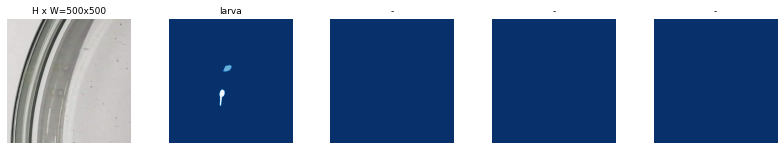

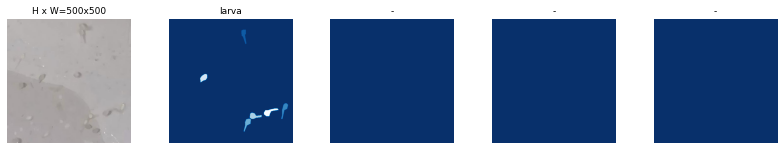

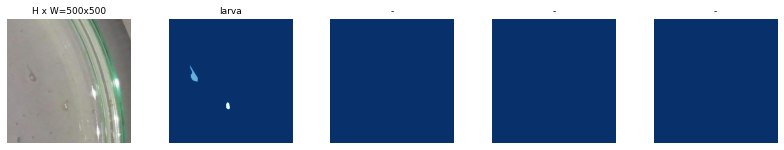

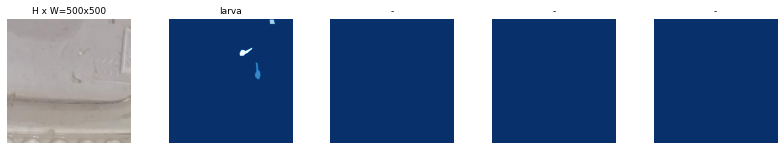

In [10]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image_id  28 C://My Proyects//Mask_RCNN//Mask_RCNN//larvaim\train\foto_190.jpg
image                    shape: (500, 500, 3)         min:   79.00000  max:  255.00000  uint8
mask                     shape: (500, 500, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (2, 4)                min:   51.00000  max:  297.00000  int32


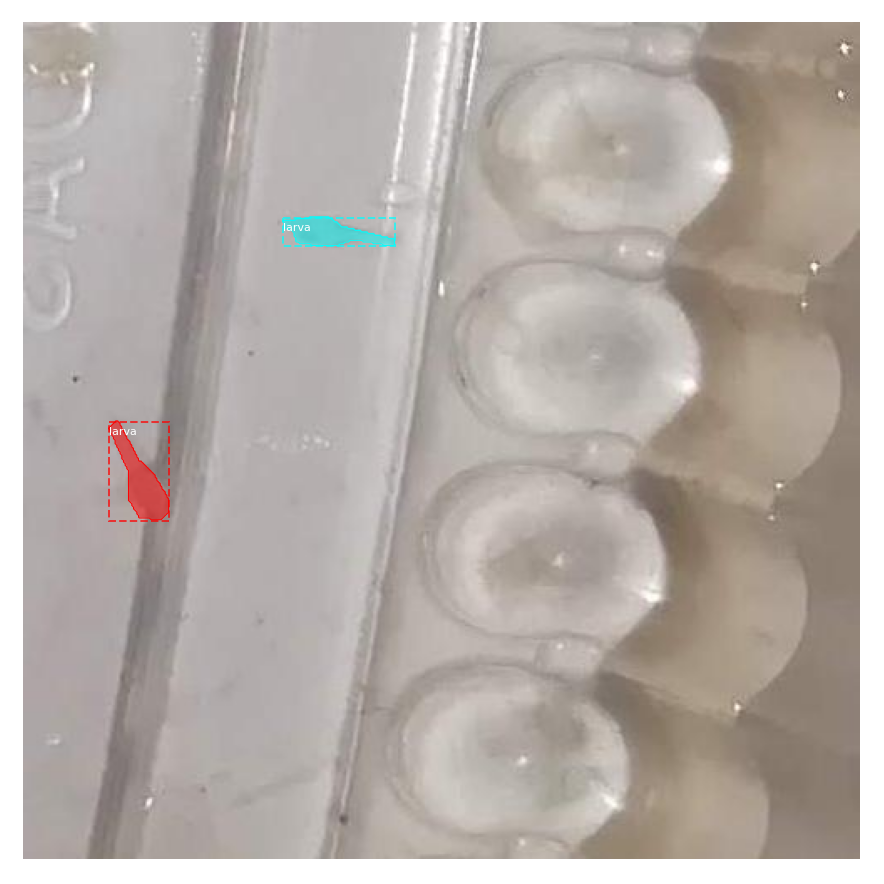

In [11]:
from mrcnn.model import log
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [12]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C://My Proyects//Mask_RCNN//Mask_RCNN\logs\larva20220413T1407\mask_rcnn_larva_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribut

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "







Epoch 1/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 39:28 - loss: 4.8225 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 3.4354 - mrcnn_class_loss: 1.3483 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 29:24 - loss: 4.6116 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 2.9111 - mrcnn_class_loss: 1.6637 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 25:53 - loss: 4.1211 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 2.8748 - mrcnn_class_loss: 1.2165 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 24:09 - loss: 3.3803 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 2.4291 - mrcnn_class_loss: 0.9260 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 23:07 - loss: 3.0735 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 2.3017 - mrcnn_class_loss: 0.7415 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 22:23 - loss: 2.7803 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 2.1304 - mrcnn_class_loss: 0.6183 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 21:49 - loss: 2.5213 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.9612 - mrcnn_class_loss: 0.5300 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 21:28 - loss: 2.5930 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.8787 - mrcnn_class_loss: 0.4867 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1351        

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 21:08 - loss: 2.4253 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.7788 - mrcnn_class_loss: 0.4326 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1201

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 20:52 - loss: 2.4941 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.7105 - mrcnn_class_loss: 0.4171 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.2393

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 20:38 - loss: 2.5231 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.6141 - mrcnn_class_loss: 0.3992 - mrcnn_bbox_loss: 0.1819 - mrcnn_mask_loss: 0.2876

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 20:26 - loss: 2.3630 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.5277 - mrcnn_class_loss: 0.3659 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.2636

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 20:19 - loss: 2.2291 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.4488 - mrcnn_class_loss: 0.3377 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.2433

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 20:10 - loss: 2.1146 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 1.3886 - mrcnn_class_loss: 0.3136 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2260

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 20:01 - loss: 2.1659 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.3719 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.2726

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 19:56 - loss: 2.0863 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 1.3401 - mrcnn_class_loss: 0.2913 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2556

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 19:51 - loss: 2.2148 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.3443 - mrcnn_class_loss: 0.3076 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.2884

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 19:45 - loss: 2.1393 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.3134 - mrcnn_class_loss: 0.2905 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.2723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 19:38 - loss: 2.1547 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.3654 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.2580

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 19:31 - loss: 2.1667 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.3169 - mrcnn_class_loss: 0.2758 - mrcnn_bbox_loss: 0.2249 - mrcnn_mask_loss: 0.2940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 19:24 - loss: 2.1176 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.3056 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.2800

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 19:17 - loss: 2.1091 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.3330 - mrcnn_class_loss: 0.2507 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.2673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 19:12 - loss: 2.0950 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.3517 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1956 - mrcnn_mask_loss: 0.2557

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 19:08 - loss: 2.0853 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.3719 - mrcnn_class_loss: 0.2298 - mrcnn_bbox_loss: 0.1875 - mrcnn_mask_loss: 0.2450

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 19:05 - loss: 2.1453 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.3686 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.2661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 19:01 - loss: 2.1849 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.3402 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.2531 - mrcnn_mask_loss: 0.2864

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:56 - loss: 2.2523 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.3252 - mrcnn_class_loss: 0.2824 - mrcnn_bbox_loss: 0.2866 - mrcnn_mask_loss: 0.3030

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:53 - loss: 2.2761 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.2967 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.2937 - mrcnn_mask_loss: 0.3183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:49 - loss: 2.2701 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.2589 - mrcnn_class_loss: 0.3183 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 0.3321

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:45 - loss: 2.2858 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.2417 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.3352 - mrcnn_mask_loss: 0.3443

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:40 - loss: 2.2654 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.2163 - mrcnn_class_loss: 0.3053 - mrcnn_bbox_loss: 0.3362 - mrcnn_mask_loss: 0.3552

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:35 - loss: 2.2227 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.2057 - mrcnn_class_loss: 0.2958 - mrcnn_bbox_loss: 0.3257 - mrcnn_mask_loss: 0.3441

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:31 - loss: 2.2271 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.1915 - mrcnn_class_loss: 0.2929 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.3533

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:28 - loss: 2.2423 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.1875 - mrcnn_class_loss: 0.2886 - mrcnn_bbox_loss: 0.3520 - mrcnn_mask_loss: 0.3615

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:24 - loss: 2.1913 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.1660 - mrcnn_class_loss: 0.2804 - mrcnn_bbox_loss: 0.3419 - mrcnn_mask_loss: 0.3511

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:20 - loss: 2.1425 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.1447 - mrcnn_class_loss: 0.2726 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.3414

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:17 - loss: 2.1031 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.1315 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.3322

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:13 - loss: 2.0679 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.1211 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.3150 - mrcnn_mask_loss: 0.3234

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 18:10 - loss: 2.0754 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.1125 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.3309

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 18:07 - loss: 2.1214 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.0998 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.3698 - mrcnn_mask_loss: 0.3383

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 18:03 - loss: 2.1174 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.0844 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.3444

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 18:00 - loss: 2.0888 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.0793 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.3696 - mrcnn_mask_loss: 0.3362

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:57 - loss: 2.1008 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.0705 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.3422

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:54 - loss: 2.1164 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.0724 - mrcnn_class_loss: 0.2566 - mrcnn_bbox_loss: 0.3911 - mrcnn_mask_loss: 0.3480

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:51 - loss: 2.1129 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 1.0576 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.3963 - mrcnn_mask_loss: 0.3521

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:48 - loss: 2.0926 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.0598 - mrcnn_class_loss: 0.2535 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.3445

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:45 - loss: 2.1100 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 1.0650 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.3975 - mrcnn_mask_loss: 0.3498

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:41 - loss: 2.0675 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.0438 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.3892 - mrcnn_mask_loss: 0.3425

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:38 - loss: 2.0634 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.0301 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.3476

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:35 - loss: 2.0668 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 1.0271 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.3520

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:32 - loss: 2.0616 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.0147 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.4113 - mrcnn_mask_loss: 0.3543

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:29 - loss: 2.0384 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.0104 - mrcnn_class_loss: 0.2310 - mrcnn_bbox_loss: 0.4034 - mrcnn_mask_loss: 0.3474

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:26 - loss: 2.0328 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.0034 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.3503

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:24 - loss: 2.0328 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.9921 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.3540

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:21 - loss: 2.0182 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.9764 - mrcnn_class_loss: 0.2239 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.3564

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:18 - loss: 1.9949 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.9713 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.4082 - mrcnn_mask_loss: 0.3501

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:15 - loss: 1.9890 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.9626 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.3515

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:13 - loss: 2.0014 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.9607 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.4212 - mrcnn_mask_loss: 0.3539

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:10 - loss: 2.0017 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.9603 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.4212 - mrcnn_mask_loss: 0.3552

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:07 - loss: 1.9986 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.9543 - mrcnn_class_loss: 0.2162 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.3562

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:04 - loss: 1.9895 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.9449 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.4257 - mrcnn_mask_loss: 0.3582

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:02 - loss: 1.9935 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.9428 - mrcnn_class_loss: 0.2132 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.3600

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 16:59 - loss: 2.0064 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.9458 - mrcnn_class_loss: 0.2100 - mrcnn_bbox_loss: 0.4420 - mrcnn_mask_loss: 0.3620

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 16:57 - loss: 1.9829 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.9386 - mrcnn_class_loss: 0.2068 - mrcnn_bbox_loss: 0.4351 - mrcnn_mask_loss: 0.3563

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 16:54 - loss: 1.9827 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.9333 - mrcnn_class_loss: 0.2038 - mrcnn_bbox_loss: 0.4429 - mrcnn_mask_loss: 0.3569

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 16:51 - loss: 1.9799 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.9252 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.4480 - mrcnn_mask_loss: 0.3582

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:49 - loss: 1.9786 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.9186 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.4538 - mrcnn_mask_loss: 0.3603

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:46 - loss: 1.9748 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.9127 - mrcnn_class_loss: 0.1976 - mrcnn_bbox_loss: 0.4557 - mrcnn_mask_loss: 0.3633

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:43 - loss: 1.9792 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.9055 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.4679 - mrcnn_mask_loss: 0.3656

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:41 - loss: 1.9610 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.9020 - mrcnn_class_loss: 0.1923 - mrcnn_bbox_loss: 0.4612 - mrcnn_mask_loss: 0.3603

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:38 - loss: 1.9375 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.8932 - mrcnn_class_loss: 0.1896 - mrcnn_bbox_loss: 0.4547 - mrcnn_mask_loss: 0.3553

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:35 - loss: 1.9339 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.8878 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.4552 - mrcnn_mask_loss: 0.3571

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:32 - loss: 1.9181 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.8763 - mrcnn_class_loss: 0.1876 - mrcnn_bbox_loss: 0.4525 - mrcnn_mask_loss: 0.3574

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:30 - loss: 1.9131 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.8697 - mrcnn_class_loss: 0.1861 - mrcnn_bbox_loss: 0.4552 - mrcnn_mask_loss: 0.3581

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:27 - loss: 1.9063 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.8623 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.4570 - mrcnn_mask_loss: 0.3575

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:24 - loss: 1.8944 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.8638 - mrcnn_class_loss: 0.1832 - mrcnn_bbox_loss: 0.4510 - mrcnn_mask_loss: 0.3528

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:22 - loss: 1.8891 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.8605 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 0.4516 - mrcnn_mask_loss: 0.3520

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:19 - loss: 1.8888 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.8564 - mrcnn_class_loss: 0.1809 - mrcnn_bbox_loss: 0.4549 - mrcnn_mask_loss: 0.3533

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:17 - loss: 1.8866 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.8529 - mrcnn_class_loss: 0.1795 - mrcnn_bbox_loss: 0.4569 - mrcnn_mask_loss: 0.3536

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:14 - loss: 1.8953 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.8545 - mrcnn_class_loss: 0.1783 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.3547

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:12 - loss: 1.8985 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.8571 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 0.4663 - mrcnn_mask_loss: 0.3547

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:09 - loss: 1.8960 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.8577 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.4661 - mrcnn_mask_loss: 0.3527

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:07 - loss: 1.8919 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.8503 - mrcnn_class_loss: 0.1758 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.3535

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:04 - loss: 1.8779 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.8480 - mrcnn_class_loss: 0.1737 - mrcnn_bbox_loss: 0.4626 - mrcnn_mask_loss: 0.3493

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:02 - loss: 1.8725 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.8487 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.4598 - mrcnn_mask_loss: 0.3475

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 15:59 - loss: 1.8709 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.8448 - mrcnn_class_loss: 0.1718 - mrcnn_bbox_loss: 0.4635 - mrcnn_mask_loss: 0.3462

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 15:57 - loss: 1.8708 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.8415 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.4703 - mrcnn_mask_loss: 0.3447

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 15:54 - loss: 1.8682 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.8421 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.4676 - mrcnn_mask_loss: 0.3448

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 15:51 - loss: 1.8575 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.8366 - mrcnn_class_loss: 0.1673 - mrcnn_bbox_loss: 0.4656 - mrcnn_mask_loss: 0.3437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 15:49 - loss: 1.8380 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.8282 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.4604 - mrcnn_mask_loss: 0.3399

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 15:46 - loss: 1.8187 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.8197 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.4554 - mrcnn_mask_loss: 0.3362

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 15:44 - loss: 1.8037 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.8153 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.4504 - mrcnn_mask_loss: 0.3325

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:41 - loss: 1.7961 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.8086 - mrcnn_class_loss: 0.1613 - mrcnn_bbox_loss: 0.4501 - mrcnn_mask_loss: 0.3328

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:39 - loss: 1.7928 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.8086 - mrcnn_class_loss: 0.1597 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.3308

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:36 - loss: 1.7908 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.8060 - mrcnn_class_loss: 0.1597 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.3316

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:34 - loss: 1.7872 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.8068 - mrcnn_class_loss: 0.1581 - mrcnn_bbox_loss: 0.4482 - mrcnn_mask_loss: 0.3308

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:32 - loss: 1.7844 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.8041 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.4483 - mrcnn_mask_loss: 0.3320

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:29 - loss: 1.7813 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.8041 - mrcnn_class_loss: 0.1556 - mrcnn_bbox_loss: 0.4465 - mrcnn_mask_loss: 0.3321

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:27 - loss: 1.7735 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.7990 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.3312

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:24 - loss: 1.7728 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.8020 - mrcnn_class_loss: 0.1532 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.3306

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:22 - loss: 1.7674 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.7998 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.4428 - mrcnn_mask_loss: 0.3292

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:20 - loss: 1.7641 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.7982 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.4434 - mrcnn_mask_loss: 0.3282

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:17 - loss: 1.7611 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.7945 - mrcnn_class_loss: 0.1512 - mrcnn_bbox_loss: 0.4436 - mrcnn_mask_loss: 0.3291

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:15 - loss: 1.7579 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.7926 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.4433 - mrcnn_mask_loss: 0.3292

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:13 - loss: 1.7522 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.7890 - mrcnn_class_loss: 0.1488 - mrcnn_bbox_loss: 0.4435 - mrcnn_mask_loss: 0.3282

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:11 - loss: 1.7534 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.7893 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.4446 - mrcnn_mask_loss: 0.3278

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:09 - loss: 1.7538 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.7878 - mrcnn_class_loss: 0.1480 - mrcnn_bbox_loss: 0.4467 - mrcnn_mask_loss: 0.3283

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:06 - loss: 1.7506 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.7862 - mrcnn_class_loss: 0.1470 - mrcnn_bbox_loss: 0.4471 - mrcnn_mask_loss: 0.3274

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:04 - loss: 1.7568 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.7880 - mrcnn_class_loss: 0.1479 - mrcnn_bbox_loss: 0.4502 - mrcnn_mask_loss: 0.3275

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:02 - loss: 1.7552 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.7846 - mrcnn_class_loss: 0.1481 - mrcnn_bbox_loss: 0.4510 - mrcnn_mask_loss: 0.3281

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:00 - loss: 1.7509 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.7825 - mrcnn_class_loss: 0.1473 - mrcnn_bbox_loss: 0.4496 - mrcnn_mask_loss: 0.3284

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 14:57 - loss: 1.7472 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.7808 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.4488 - mrcnn_mask_loss: 0.3281

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 14:55 - loss: 1.7469 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.7769 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.4510 - mrcnn_mask_loss: 0.3308

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 14:53 - loss: 1.7322 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.7706 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.4470 - mrcnn_mask_loss: 0.3279

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 14:51 - loss: 1.7243 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.7640 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.4463 - mrcnn_mask_loss: 0.3282

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 14:48 - loss: 1.7246 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.7593 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.4501 - mrcnn_mask_loss: 0.3304

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 14:46 - loss: 1.7229 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.7560 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.4516 - mrcnn_mask_loss: 0.3310

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:44 - loss: 1.7171 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7528 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.4515 - mrcnn_mask_loss: 0.3297

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:42 - loss: 1.7106 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.7542 - mrcnn_class_loss: 0.1400 - mrcnn_bbox_loss: 0.4478 - mrcnn_mask_loss: 0.3269

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:39 - loss: 1.7093 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7527 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.3261

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:37 - loss: 1.7029 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7494 - mrcnn_class_loss: 0.1397 - mrcnn_bbox_loss: 0.4463 - mrcnn_mask_loss: 0.3259

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:35 - loss: 1.7011 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7473 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.4465 - mrcnn_mask_loss: 0.3261

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:32 - loss: 1.6937 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.7417 - mrcnn_class_loss: 0.1389 - mrcnn_bbox_loss: 0.4439 - mrcnn_mask_loss: 0.3278

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:30 - loss: 1.6921 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7382 - mrcnn_class_loss: 0.1395 - mrcnn_bbox_loss: 0.4444 - mrcnn_mask_loss: 0.3285

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:28 - loss: 1.6897 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.7352 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.4451 - mrcnn_mask_loss: 0.3287

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:26 - loss: 1.6894 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7374 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.3282

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:24 - loss: 1.6870 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7365 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.4415 - mrcnn_mask_loss: 0.3285

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:22 - loss: 1.6898 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.7381 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.4422 - mrcnn_mask_loss: 0.3288

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:19 - loss: 1.6840 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.7340 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.3288

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:17 - loss: 1.6851 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.7347 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.4419 - mrcnn_mask_loss: 0.3285

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:15 - loss: 1.6828 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.7338 - mrcnn_class_loss: 0.1374 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.3278

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:13 - loss: 1.6852 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7344 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.4450 - mrcnn_mask_loss: 0.3267

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:10 - loss: 1.6879 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7332 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.4509 - mrcnn_mask_loss: 0.3255

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:08 - loss: 1.6812 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.7294 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.4493 - mrcnn_mask_loss: 0.3251

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:06 - loss: 1.6799 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.7301 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.4481 - mrcnn_mask_loss: 0.3249

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:03 - loss: 1.6776 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.7295 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.4474 - mrcnn_mask_loss: 0.3246

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:01 - loss: 1.6661 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7247 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.4442 - mrcnn_mask_loss: 0.3222

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 13:59 - loss: 1.6633 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7229 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.3215

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 13:56 - loss: 1.6560 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7193 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.4420 - mrcnn_mask_loss: 0.3209

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 13:54 - loss: 1.6510 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.7176 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.4398 - mrcnn_mask_loss: 0.3205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 13:52 - loss: 1.6479 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.7166 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.4377 - mrcnn_mask_loss: 0.3213

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 13:49 - loss: 1.6422 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.7143 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.4364 - mrcnn_mask_loss: 0.3203

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 13:47 - loss: 1.6383 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.7123 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.4352 - mrcnn_mask_loss: 0.3203

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:44 - loss: 1.6346 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.7110 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.3195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:42 - loss: 1.6303 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.7129 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.4313 - mrcnn_mask_loss: 0.3173

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:39 - loss: 1.6270 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7116 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.4310 - mrcnn_mask_loss: 0.3165

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:37 - loss: 1.6270 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.7118 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.3159

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:34 - loss: 1.6243 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7106 - mrcnn_class_loss: 0.1262 - mrcnn_bbox_loss: 0.4310 - mrcnn_mask_loss: 0.3160

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:32 - loss: 1.6223 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.7083 - mrcnn_class_loss: 0.1254 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.3151

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:29 - loss: 1.6219 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.7058 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.4346 - mrcnn_mask_loss: 0.3163

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:27 - loss: 1.6206 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.7050 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.3166

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:25 - loss: 1.6170 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.7034 - mrcnn_class_loss: 0.1236 - mrcnn_bbox_loss: 0.4337 - mrcnn_mask_loss: 0.3163

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:22 - loss: 1.6161 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.7041 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.4329 - mrcnn_mask_loss: 0.3159

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:20 - loss: 1.6118 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.7028 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.3150

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:17 - loss: 1.6069 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.7017 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.3140

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:15 - loss: 1.6026 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.7000 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.3132

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:13 - loss: 1.6010 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.6997 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.4273 - mrcnn_mask_loss: 0.3128

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:10 - loss: 1.5967 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.6976 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.4258 - mrcnn_mask_loss: 0.3125

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:08 - loss: 1.5911 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.6951 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.3118

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:05 - loss: 1.5839 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.6911 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.4222 - mrcnn_mask_loss: 0.3112

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:03 - loss: 1.5811 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.6887 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.3114

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:01 - loss: 1.5775 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.6881 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.3105

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 12:58 - loss: 1.5747 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.6869 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.4198 - mrcnn_mask_loss: 0.3102

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 12:56 - loss: 1.5760 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6887 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.4198 - mrcnn_mask_loss: 0.3099

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 12:54 - loss: 1.5744 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6878 - mrcnn_class_loss: 0.1180 - mrcnn_bbox_loss: 0.4201 - mrcnn_mask_loss: 0.3092

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 12:51 - loss: 1.5753 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.6886 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.4209 - mrcnn_mask_loss: 0.3084

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 12:49 - loss: 1.5726 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.6874 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.4200 - mrcnn_mask_loss: 0.3079

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 12:46 - loss: 1.5681 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.6848 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.4184 - mrcnn_mask_loss: 0.3078

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:44 - loss: 1.5697 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.6862 - mrcnn_class_loss: 0.1180 - mrcnn_bbox_loss: 0.4181 - mrcnn_mask_loss: 0.3076

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:42 - loss: 1.5693 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.6854 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.3082

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:40 - loss: 1.5638 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.6824 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.3076

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:38 - loss: 1.5629 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.6810 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.3082

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:35 - loss: 1.5623 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.6785 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.4177 - mrcnn_mask_loss: 0.3095

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:33 - loss: 1.5603 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.6783 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.3091

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:31 - loss: 1.5524 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6753 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.3073

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:29 - loss: 1.5500 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.6750 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.4131 - mrcnn_mask_loss: 0.3072

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:26 - loss: 1.5463 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6712 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.3092

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:24 - loss: 1.5451 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6703 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.4115 - mrcnn_mask_loss: 0.3091

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:22 - loss: 1.5372 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.6672 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.4092 - mrcnn_mask_loss: 0.3073

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:20 - loss: 1.5327 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.6658 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.4078 - mrcnn_mask_loss: 0.3064

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:18 - loss: 1.5309 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.6631 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.4082 - mrcnn_mask_loss: 0.3073

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:15 - loss: 1.5228 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.6597 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.4060 - mrcnn_mask_loss: 0.3056

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:13 - loss: 1.5208 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.6596 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.4049 - mrcnn_mask_loss: 0.3052

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:11 - loss: 1.5194 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.6590 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.4041 - mrcnn_mask_loss: 0.3054

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:09 - loss: 1.5172 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.6586 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.4035 - mrcnn_mask_loss: 0.3046

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:07 - loss: 1.5124 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.6557 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.4021 - mrcnn_mask_loss: 0.3046

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:04 - loss: 1.5100 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.6552 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.4016 - mrcnn_mask_loss: 0.3037

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:02 - loss: 1.5069 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.6541 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.4008 - mrcnn_mask_loss: 0.3031

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:00 - loss: 1.5048 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.6533 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.4001 - mrcnn_mask_loss: 0.3030

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 11:57 - loss: 1.5023 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.6512 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.3023

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 11:55 - loss: 1.4980 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.6482 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.4007 - mrcnn_mask_loss: 0.3019

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 11:53 - loss: 1.4950 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6467 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.3017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 11:51 - loss: 1.4925 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6460 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.3974 - mrcnn_mask_loss: 0.3020

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:48 - loss: 1.4925 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6459 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.3974 - mrcnn_mask_loss: 0.3022

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:46 - loss: 1.4851 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6427 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.3007

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:44 - loss: 1.4820 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6420 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.3941 - mrcnn_mask_loss: 0.3000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:42 - loss: 1.4802 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6417 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.2997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:39 - loss: 1.4829 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6431 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.2995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:37 - loss: 1.4824 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6438 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.2993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:35 - loss: 1.4785 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6417 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.3911 - mrcnn_mask_loss: 0.2995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:33 - loss: 1.4768 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6400 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.3909 - mrcnn_mask_loss: 0.2994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:30 - loss: 1.4759 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6406 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.3901 - mrcnn_mask_loss: 0.2987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:28 - loss: 1.4728 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6393 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.2978

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:26 - loss: 1.4692 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.6382 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.3884 - mrcnn_mask_loss: 0.2973

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:23 - loss: 1.4676 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.6381 - mrcnn_class_loss: 0.1069 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.2971

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:21 - loss: 1.4692 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6370 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.2980

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:19 - loss: 1.4698 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6388 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.2976

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:17 - loss: 1.4681 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6358 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.2989

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:14 - loss: 1.4667 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.6351 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.3883 - mrcnn_mask_loss: 0.2986

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:12 - loss: 1.4619 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6322 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.2981

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:10 - loss: 1.4589 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6319 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.2973

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:08 - loss: 1.4574 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.6315 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.2969

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:05 - loss: 1.4534 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.6301 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.2963

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:03 - loss: 1.4531 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.6300 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.2959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:01 - loss: 1.4495 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.6283 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.2950

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 10:59 - loss: 1.4470 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.6273 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.2951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 10:56 - loss: 1.4458 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.6262 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.2945

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 10:54 - loss: 1.4432 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6235 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.3823 - mrcnn_mask_loss: 0.2957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 10:52 - loss: 1.4407 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6222 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.2953

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:49 - loss: 1.4386 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6206 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.3820 - mrcnn_mask_loss: 0.2952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:47 - loss: 1.4372 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6185 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.2957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:45 - loss: 1.4380 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6200 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.2955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:43 - loss: 1.4384 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6206 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.2952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:40 - loss: 1.4361 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6190 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.2949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:38 - loss: 1.4331 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6179 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.2945

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:36 - loss: 1.4289 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6162 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.3791 - mrcnn_mask_loss: 0.2940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:34 - loss: 1.4288 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6155 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.3791 - mrcnn_mask_loss: 0.2938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:31 - loss: 1.4269 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6150 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.3780 - mrcnn_mask_loss: 0.2938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:29 - loss: 1.4249 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.3772 - mrcnn_mask_loss: 0.2936

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:27 - loss: 1.4225 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6129 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.3762 - mrcnn_mask_loss: 0.2936

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:24 - loss: 1.4225 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6115 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.3765 - mrcnn_mask_loss: 0.2944

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:22 - loss: 1.4222 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6105 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.3769 - mrcnn_mask_loss: 0.2949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:20 - loss: 1.4201 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6091 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.3770 - mrcnn_mask_loss: 0.2947

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:18 - loss: 1.4232 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6109 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.3774 - mrcnn_mask_loss: 0.2951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:15 - loss: 1.4219 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6113 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.3765 - mrcnn_mask_loss: 0.2945

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:13 - loss: 1.4165 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6092 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.3749 - mrcnn_mask_loss: 0.2933

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:11 - loss: 1.4142 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6074 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.3751 - mrcnn_mask_loss: 0.2928

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:09 - loss: 1.4124 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6071 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.3745 - mrcnn_mask_loss: 0.2923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:06 - loss: 1.4118 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.6060 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.3758 - mrcnn_mask_loss: 0.2918

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:04 - loss: 1.4119 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6059 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.2922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:02 - loss: 1.4109 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6060 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.3746 - mrcnn_mask_loss: 0.2916

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 9:59 - loss: 1.4098 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6053 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.3738 - mrcnn_mask_loss: 0.2917 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 9:57 - loss: 1.4041 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6028 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.2905

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 9:55 - loss: 1.4028 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6020 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.3717 - mrcnn_mask_loss: 0.2907

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 9:53 - loss: 1.3996 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.6009 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.3704 - mrcnn_mask_loss: 0.2902

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:50 - loss: 1.4000 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6013 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.3699 - mrcnn_mask_loss: 0.2902

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:48 - loss: 1.3965 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.5992 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.3693 - mrcnn_mask_loss: 0.2898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:46 - loss: 1.3953 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.5987 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.3685 - mrcnn_mask_loss: 0.2897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:43 - loss: 1.3963 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.5997 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.3683 - mrcnn_mask_loss: 0.2897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:41 - loss: 1.3945 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.5993 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.3675 - mrcnn_mask_loss: 0.2894

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:39 - loss: 1.3928 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.3672 - mrcnn_mask_loss: 0.2896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:36 - loss: 1.3899 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.5964 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.3661 - mrcnn_mask_loss: 0.2894

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:34 - loss: 1.3884 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.5962 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.3659 - mrcnn_mask_loss: 0.2887

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:32 - loss: 1.3851 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.5943 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.3651 - mrcnn_mask_loss: 0.2885

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:29 - loss: 1.3849 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.5958 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.2880

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:27 - loss: 1.3826 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.5950 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.3637 - mrcnn_mask_loss: 0.2875

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:25 - loss: 1.3797 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.5932 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.3628 - mrcnn_mask_loss: 0.2875

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:23 - loss: 1.3781 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.5926 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.3626 - mrcnn_mask_loss: 0.2871

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:20 - loss: 1.3738 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.5912 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.3612 - mrcnn_mask_loss: 0.2860

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:18 - loss: 1.3732 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.5914 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.3606 - mrcnn_mask_loss: 0.2860

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:16 - loss: 1.3722 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.5893 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.2866

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:13 - loss: 1.3704 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.5882 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.3609 - mrcnn_mask_loss: 0.2866

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:11 - loss: 1.3679 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.5871 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.3605 - mrcnn_mask_loss: 0.2861

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:09 - loss: 1.3662 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.5869 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.3599 - mrcnn_mask_loss: 0.2856

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:06 - loss: 1.3656 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.5872 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.3595 - mrcnn_mask_loss: 0.2853

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:04 - loss: 1.3641 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.5868 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.3593 - mrcnn_mask_loss: 0.2848

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:02 - loss: 1.3633 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.5864 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.3592 - mrcnn_mask_loss: 0.2847

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 8:59 - loss: 1.3606 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5850 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.3586 - mrcnn_mask_loss: 0.2845

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 8:57 - loss: 1.3603 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5840 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.3582 - mrcnn_mask_loss: 0.2851

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 8:55 - loss: 1.3585 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.5835 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.2849

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:52 - loss: 1.3564 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.3563 - mrcnn_mask_loss: 0.2846

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:50 - loss: 1.3546 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5829 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.2839

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:48 - loss: 1.3547 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.5840 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.3554 - mrcnn_mask_loss: 0.2834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:46 - loss: 1.3552 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.5848 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.3548 - mrcnn_mask_loss: 0.2833

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:43 - loss: 1.3534 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.5842 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.3539 - mrcnn_mask_loss: 0.2834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:41 - loss: 1.3512 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.5821 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.3533 - mrcnn_mask_loss: 0.2843

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:39 - loss: 1.3503 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.5821 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.3525 - mrcnn_mask_loss: 0.2843

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:36 - loss: 1.3482 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.5806 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.3522 - mrcnn_mask_loss: 0.2842

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:34 - loss: 1.3458 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.3518 - mrcnn_mask_loss: 0.2837

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:32 - loss: 1.3444 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5789 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.3511 - mrcnn_mask_loss: 0.2838

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:30 - loss: 1.3425 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5777 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.3509 - mrcnn_mask_loss: 0.2836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:27 - loss: 1.3425 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5765 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.3512 - mrcnn_mask_loss: 0.2843

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:25 - loss: 1.3397 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.5750 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.3503 - mrcnn_mask_loss: 0.2842

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:23 - loss: 1.3379 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.5742 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.3497 - mrcnn_mask_loss: 0.2840

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:20 - loss: 1.3364 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.5729 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.3493 - mrcnn_mask_loss: 0.2843

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:18 - loss: 1.3341 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.5723 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.3485 - mrcnn_mask_loss: 0.2838

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:16 - loss: 1.3319 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.5714 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.3482 - mrcnn_mask_loss: 0.2831

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:14 - loss: 1.3312 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.5714 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.3481 - mrcnn_mask_loss: 0.2827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:11 - loss: 1.3280 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.5696 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.2823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:09 - loss: 1.3268 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.5691 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.3471 - mrcnn_mask_loss: 0.2820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:07 - loss: 1.3258 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.5686 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.3470 - mrcnn_mask_loss: 0.2814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:05 - loss: 1.3233 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.3462 - mrcnn_mask_loss: 0.2811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:02 - loss: 1.3214 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.5663 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.2806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:00 - loss: 1.3209 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.5662 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.3456 - mrcnn_mask_loss: 0.2804

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 7:58 - loss: 1.3165 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.3444 - mrcnn_mask_loss: 0.2794

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:56 - loss: 1.3150 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5636 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.3442 - mrcnn_mask_loss: 0.2790

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:53 - loss: 1.3147 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5636 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.3437 - mrcnn_mask_loss: 0.2789

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:51 - loss: 1.3159 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.5645 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.2787

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:49 - loss: 1.3140 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5632 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.3440 - mrcnn_mask_loss: 0.2784

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:47 - loss: 1.3133 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5615 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.3446 - mrcnn_mask_loss: 0.2789

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:45 - loss: 1.3112 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5599 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.3443 - mrcnn_mask_loss: 0.2790

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:42 - loss: 1.3103 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.3437 - mrcnn_mask_loss: 0.2789

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:40 - loss: 1.3107 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5612 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.3432 - mrcnn_mask_loss: 0.2787

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:38 - loss: 1.3085 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5603 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.3422 - mrcnn_mask_loss: 0.2784

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:35 - loss: 1.3072 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5600 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.3417 - mrcnn_mask_loss: 0.2782

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:33 - loss: 1.3059 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5596 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.3412 - mrcnn_mask_loss: 0.2780

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:31 - loss: 1.3018 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5579 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.3401 - mrcnn_mask_loss: 0.2771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:28 - loss: 1.3002 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5579 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.3393 - mrcnn_mask_loss: 0.2765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:26 - loss: 1.2981 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.5574 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.3386 - mrcnn_mask_loss: 0.2759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:24 - loss: 1.2967 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5570 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.3379 - mrcnn_mask_loss: 0.2757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:21 - loss: 1.2966 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5570 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.3376 - mrcnn_mask_loss: 0.2758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:19 - loss: 1.2974 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5574 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.2757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:17 - loss: 1.2957 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5558 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.2760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:14 - loss: 1.2928 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.5543 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.3369 - mrcnn_mask_loss: 0.2756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:12 - loss: 1.2906 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.5530 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.3364 - mrcnn_mask_loss: 0.2755

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:10 - loss: 1.2883 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.5520 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.3357 - mrcnn_mask_loss: 0.2752

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:07 - loss: 1.2869 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.5513 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.3349 - mrcnn_mask_loss: 0.2752

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:05 - loss: 1.2851 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.5506 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.2748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:03 - loss: 1.2856 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.5515 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.3337 - mrcnn_mask_loss: 0.2748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:00 - loss: 1.2840 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.5508 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.3330 - mrcnn_mask_loss: 0.2748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 6:58 - loss: 1.2813 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.5495 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.3321 - mrcnn_mask_loss: 0.2745

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:56 - loss: 1.2793 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.5479 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.2750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:53 - loss: 1.2769 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.5471 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.3305 - mrcnn_mask_loss: 0.2746

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:51 - loss: 1.2768 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.3305 - mrcnn_mask_loss: 0.2748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:49 - loss: 1.2749 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.2747

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:46 - loss: 1.2727 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.5441 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.2746

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:44 - loss: 1.2711 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.2745

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:42 - loss: 1.2699 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.3282 - mrcnn_mask_loss: 0.2741

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:39 - loss: 1.2681 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.5416 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.3279 - mrcnn_mask_loss: 0.2740

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:37 - loss: 1.2674 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.3277 - mrcnn_mask_loss: 0.2737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:35 - loss: 1.2674 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.3275 - mrcnn_mask_loss: 0.2735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:32 - loss: 1.2659 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.2730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:30 - loss: 1.2644 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.5407 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.3269 - mrcnn_mask_loss: 0.2728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:28 - loss: 1.2629 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.2724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:25 - loss: 1.2610 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.5388 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.3266 - mrcnn_mask_loss: 0.2720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:23 - loss: 1.2576 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.5375 - mrcnn_class_loss: 0.0882 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.2712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:21 - loss: 1.2561 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.5369 - mrcnn_class_loss: 0.0882 - mrcnn_bbox_loss: 0.3251 - mrcnn_mask_loss: 0.2709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:18 - loss: 1.2550 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.5366 - mrcnn_class_loss: 0.0882 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.2708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:16 - loss: 1.2538 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5359 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.2704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:14 - loss: 1.2522 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.3236 - mrcnn_mask_loss: 0.2705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:11 - loss: 1.2497 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.3231 - mrcnn_mask_loss: 0.2701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:09 - loss: 1.2492 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5335 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.3232 - mrcnn_mask_loss: 0.2698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:07 - loss: 1.2482 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5333 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.2697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:04 - loss: 1.2480 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5331 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.2696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:02 - loss: 1.2462 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5319 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.3218 - mrcnn_mask_loss: 0.2698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:00 - loss: 1.2457 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5320 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.2696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:57 - loss: 1.2482 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5332 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.2700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:55 - loss: 1.2477 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.5331 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.2697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:53 - loss: 1.2456 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5319 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.2695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:50 - loss: 1.2433 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.5307 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.2693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:48 - loss: 1.2417 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5301 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.2692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:46 - loss: 1.2408 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5288 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.2698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:43 - loss: 1.2392 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.5281 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.3197 - mrcnn_mask_loss: 0.2699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:41 - loss: 1.2395 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.5289 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.3190 - mrcnn_mask_loss: 0.2699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:39 - loss: 1.2380 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.5280 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.3186 - mrcnn_mask_loss: 0.2699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:36 - loss: 1.2373 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.5271 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.3186 - mrcnn_mask_loss: 0.2698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:34 - loss: 1.2375 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.5273 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.2700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:32 - loss: 1.2373 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.5266 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.3183 - mrcnn_mask_loss: 0.2703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:29 - loss: 1.2346 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.5252 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.3176 - mrcnn_mask_loss: 0.2700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:27 - loss: 1.2324 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.5243 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.3168 - mrcnn_mask_loss: 0.2696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:25 - loss: 1.2312 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.5236 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.3163 - mrcnn_mask_loss: 0.2697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:22 - loss: 1.2291 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.5226 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.3156 - mrcnn_mask_loss: 0.2695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:20 - loss: 1.2272 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.5213 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.3149 - mrcnn_mask_loss: 0.2697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:18 - loss: 1.2256 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.5207 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.3144 - mrcnn_mask_loss: 0.2695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:15 - loss: 1.2242 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5198 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 0.2693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:13 - loss: 1.2245 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.5201 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 0.2693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:11 - loss: 1.2228 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5194 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.3136 - mrcnn_mask_loss: 0.2688

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:08 - loss: 1.2227 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5187 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.3134 - mrcnn_mask_loss: 0.2690

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:06 - loss: 1.2243 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.5197 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.3135 - mrcnn_mask_loss: 0.2695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:04 - loss: 1.2234 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.5195 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.3132 - mrcnn_mask_loss: 0.2692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:01 - loss: 1.2215 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.5182 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.3132 - mrcnn_mask_loss: 0.2689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 4:59 - loss: 1.2202 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5176 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.2687

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:57 - loss: 1.2185 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5169 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.3126 - mrcnn_mask_loss: 0.2684

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:54 - loss: 1.2171 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.5161 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.2681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:52 - loss: 1.2142 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.5149 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.3116 - mrcnn_mask_loss: 0.2674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:50 - loss: 1.2122 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.5138 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.3109 - mrcnn_mask_loss: 0.2673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:47 - loss: 1.2107 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.5127 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 0.2673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:45 - loss: 1.2082 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.5113 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.3099 - mrcnn_mask_loss: 0.2670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:43 - loss: 1.2078 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.5112 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.3098 - mrcnn_mask_loss: 0.2668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:40 - loss: 1.2076 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.5110 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.2668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:38 - loss: 1.2062 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.5101 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.3092 - mrcnn_mask_loss: 0.2669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:36 - loss: 1.2051 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.5099 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.2666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:33 - loss: 1.2030 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5087 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.3083 - mrcnn_mask_loss: 0.2664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:31 - loss: 1.2019 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5084 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.3077 - mrcnn_mask_loss: 0.2662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:29 - loss: 1.2019 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.2661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:26 - loss: 1.2004 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5085 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.3065 - mrcnn_mask_loss: 0.2660

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:24 - loss: 1.1990 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5085 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.3058 - mrcnn_mask_loss: 0.2656

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:22 - loss: 1.1990 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.5087 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.3054 - mrcnn_mask_loss: 0.2656

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:19 - loss: 1.1983 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.5084 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.2654

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:17 - loss: 1.1975 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5072 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.3056 - mrcnn_mask_loss: 0.2656

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:15 - loss: 1.1960 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5065 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.2653

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:12 - loss: 1.1945 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5060 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.2651

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:10 - loss: 1.1924 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.5051 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 0.2648

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:08 - loss: 1.1907 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.5045 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.2645

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:05 - loss: 1.1899 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.3031 - mrcnn_mask_loss: 0.2642

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:03 - loss: 1.1887 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5031 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.3032 - mrcnn_mask_loss: 0.2642

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:01 - loss: 1.1890 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5034 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.3031 - mrcnn_mask_loss: 0.2640

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:58 - loss: 1.1871 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5023 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.2638

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:56 - loss: 1.1857 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.3024 - mrcnn_mask_loss: 0.2635

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:54 - loss: 1.1843 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.5012 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.2635

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:51 - loss: 1.1832 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.5008 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.3012 - mrcnn_mask_loss: 0.2632

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:49 - loss: 1.1817 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.4998 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.2630

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:47 - loss: 1.1803 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4987 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.2628

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:44 - loss: 1.1803 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.4988 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.2628

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:42 - loss: 1.1777 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4979 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 0.2622

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:40 - loss: 1.1771 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4980 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.2995 - mrcnn_mask_loss: 0.2618

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:37 - loss: 1.1758 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4975 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.2617

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:35 - loss: 1.1740 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4964 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.2617

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 1.1725 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4956 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.2981 - mrcnn_mask_loss: 0.2615

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:30 - loss: 1.1710 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4948 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.2976 - mrcnn_mask_loss: 0.2614

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:28 - loss: 1.1696 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4938 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.2973 - mrcnn_mask_loss: 0.2616

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 1.1697 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4936 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.2972 - mrcnn_mask_loss: 0.2616

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:23 - loss: 1.1690 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4934 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.2969 - mrcnn_mask_loss: 0.2614

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:21 - loss: 1.1688 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4929 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.2970 - mrcnn_mask_loss: 0.2616

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 1.1673 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4920 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.2614

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:16 - loss: 1.1660 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4916 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.2610

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:14 - loss: 1.1667 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4923 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.2967 - mrcnn_mask_loss: 0.2610

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 1.1659 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4920 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.2607

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:09 - loss: 1.1642 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4909 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2606

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:07 - loss: 1.1642 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4915 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.2605

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 1.1624 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4904 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.2604

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:02 - loss: 1.1620 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4906 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.2603

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:00 - loss: 1.1619 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4908 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.2947 - mrcnn_mask_loss: 0.2602

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 1.1598 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4897 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.2600

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:55 - loss: 1.1597 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4896 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.2600

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:53 - loss: 1.1578 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.4885 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.2600

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 1.1567 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.4875 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.2936 - mrcnn_mask_loss: 0.2600

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:48 - loss: 1.1550 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.4864 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.2598

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 1.1529 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.4853 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.2927 - mrcnn_mask_loss: 0.2595

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 1.1516 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.4847 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.2922 - mrcnn_mask_loss: 0.2592

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:41 - loss: 1.1501 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.4842 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.2916 - mrcnn_mask_loss: 0.2590

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 1.1482 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.4832 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.2588

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 1.1471 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4825 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.2912 - mrcnn_mask_loss: 0.2585

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:34 - loss: 1.1459 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4818 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.2909 - mrcnn_mask_loss: 0.2584

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 1.1455 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4817 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.2906 - mrcnn_mask_loss: 0.2585

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 1.1445 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4814 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.2902 - mrcnn_mask_loss: 0.2583

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:27 - loss: 1.1428 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.4807 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.2581

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 1.1415 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.4800 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.2579

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 1.1402 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4794 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.2577

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:20 - loss: 1.1378 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4785 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.2885 - mrcnn_mask_loss: 0.2572

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 1.1378 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.2570

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 1.1364 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4781 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.2570

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:13 - loss: 1.1358 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4780 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.2569

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 1.1345 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4771 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.2873 - mrcnn_mask_loss: 0.2568

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 1.1339 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4769 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.2872 - mrcnn_mask_loss: 0.2568

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 1.1325 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4761 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 0.2568

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 1.1312 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4756 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.2863 - mrcnn_mask_loss: 0.2566

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:01 - loss: 1.1312 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4756 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 0.2565

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 1.1316 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4762 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.2565

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 1.1315 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4757 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.2857 - mrcnn_mask_loss: 0.2569

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:54 - loss: 1.1299 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4749 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.2853 - mrcnn_mask_loss: 0.2568

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 1.1287 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4741 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.2852 - mrcnn_mask_loss: 0.2567

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 1.1269 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4731 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.2847 - mrcnn_mask_loss: 0.2565

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:47 - loss: 1.1259 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4728 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.2563

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 1.1253 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4726 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.2840 - mrcnn_mask_loss: 0.2562

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 1.1245 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4721 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.2560

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:40 - loss: 1.1248 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4727 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.2559

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 1.1242 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.2832 - mrcnn_mask_loss: 0.2557

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 1.1229 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4718 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.2828 - mrcnn_mask_loss: 0.2557

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:33 - loss: 1.1224 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4712 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.2825 - mrcnn_mask_loss: 0.2558

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 1.1214 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4712 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.2820 - mrcnn_mask_loss: 0.2556

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 1.1203 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4703 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.2817 - mrcnn_mask_loss: 0.2554

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:26 - loss: 1.1191 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4699 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.2814 - mrcnn_mask_loss: 0.2552

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 1.1182 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4691 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.2813 - mrcnn_mask_loss: 0.2553

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 1.1170 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4686 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.2809 - mrcnn_mask_loss: 0.2550

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 1.1169 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4691 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.2805 - mrcnn_mask_loss: 0.2550

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 1.1156 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4681 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.2802 - mrcnn_mask_loss: 0.2551

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 1.1141 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4672 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.2799 - mrcnn_mask_loss: 0.2548

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 1.1131 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4668 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.2547

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 1.1132 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4667 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.2547

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 1.1120 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4661 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.2793 - mrcnn_mask_loss: 0.2544

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 1.1106 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4653 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.2792 - mrcnn_mask_loss: 0.2541

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 1.1105 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.2788 - mrcnn_mask_loss: 0.2541

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 1.1088 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4647 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.2538

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 1.1072 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4638 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.2778 - mrcnn_mask_loss: 0.2538 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 1.1051 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.4630 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.2532

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 54s - loss: 1.1041 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.4625 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.2771 - mrcnn_mask_loss: 0.2530

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 1.1027 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4615 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.2769 - mrcnn_mask_loss: 0.2528

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 1.1031 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4620 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.2527

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 46s - loss: 1.1019 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4612 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.2768 - mrcnn_mask_loss: 0.2526

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 1.1011 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.2525

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 1.1010 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4609 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.2525

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 1.0997 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.2758 - mrcnn_mask_loss: 0.2523

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 1.0989 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4597 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 0.2523

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 1.0974 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4588 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.2756 - mrcnn_mask_loss: 0.2520

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 1.0961 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4581 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.2755 - mrcnn_mask_loss: 0.2517

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 1.0955 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4576 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.2753 - mrcnn_mask_loss: 0.2516

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 1.0957 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4580 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.2750 - mrcnn_mask_loss: 0.2515

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 1.0942 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4572 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.2514

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 1.0935 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4570 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.2745 - mrcnn_mask_loss: 0.2511

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 1.0933 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4572 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.2743 - mrcnn_mask_loss: 0.2510

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 1.0917 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.4563 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.2739 - mrcnn_mask_loss: 0.2508

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 1.0910 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.4560 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.2737 - mrcnn_mask_loss: 0.2507

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 1.0889 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.4552 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.2731 - mrcnn_mask_loss: 0.2502

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 1.0879 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.4546 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.2728 - mrcnn_mask_loss: 0.2502

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 1.0870 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4539 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.2728 - mrcnn_mask_loss: 0.2500 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 1.0857 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.2499

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 1.0856 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4530 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.2723 - mrcnn_mask_loss: 0.2499

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 1.0856 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4534 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.2720 - mrcnn_mask_loss: 0.2498

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1179s 2s/step - loss: 1.0841 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4526 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.2716 - mrcnn_mask_loss: 0.2497 - val_loss: 1.6129 - val_rpn_class_loss: 0.0637 - val_rpn_bbox_loss: 0.7272 - val_mrcnn_class_loss: 0.2465 - val_mrcnn_bbox_loss: 0.5112 - val_mrcnn_mask_loss: 0.3703

Epoch 2/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 20:29 - loss: 0.9361 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.2001 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.3751

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 20:17 - loss: 0.7415 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.1708 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.2978

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 20:12 - loss: 0.7844 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2449 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2015 - mrcnn_mask_loss: 0.2614

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 20:06 - loss: 0.6710 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2008 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.2367

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 20:03 - loss: 0.7243 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.2384

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 20:01 - loss: 0.6951 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2033 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.1585 - mrcnn_mask_loss: 0.2331

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:57 - loss: 0.6610 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2329

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:53 - loss: 0.6165 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1758 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.2197

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:51 - loss: 0.5929 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1780 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2105

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:46 - loss: 0.6499 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.2104

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:41 - loss: 0.6599 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.1321 - mrcnn_mask_loss: 0.2075

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 19:35 - loss: 0.6367 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.2029

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 19:31 - loss: 0.5965 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1872

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 19:27 - loss: 0.5874 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1866 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.1962

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 19:23 - loss: 0.5854 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1821 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.1976

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 19:19 - loss: 0.6175 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 19:16 - loss: 0.6114 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2057 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 19:12 - loss: 0.6222 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 19:08 - loss: 0.6247 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 19:05 - loss: 0.6105 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2017 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1905

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 19:02 - loss: 0.6219 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1885

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:59 - loss: 0.6388 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:56 - loss: 0.6373 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.1935

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:53 - loss: 0.6422 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.1933

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:50 - loss: 0.6572 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.2301 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1946

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:47 - loss: 0.6720 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.2350 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:45 - loss: 0.6632 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2317 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:43 - loss: 0.6736 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.1983

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:40 - loss: 0.6645 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.1965

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:37 - loss: 0.6588 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2194 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1962

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:34 - loss: 0.6586 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.1942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:31 - loss: 0.6494 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1939

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:28 - loss: 0.6613 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:26 - loss: 0.6554 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1953

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:23 - loss: 0.6447 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1931

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:21 - loss: 0.6623 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.2241 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1960

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:18 - loss: 0.6567 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1933

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:16 - loss: 0.6591 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 18:14 - loss: 0.6560 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 18:12 - loss: 0.6528 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.1912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 18:09 - loss: 0.6486 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.1899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 18:06 - loss: 0.6406 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2118 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1885

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 18:03 - loss: 0.6280 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1841

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 18:01 - loss: 0.6320 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:58 - loss: 0.6339 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.1824

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:56 - loss: 0.6269 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:53 - loss: 0.6241 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.1830

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:51 - loss: 0.6228 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2030 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.1819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:48 - loss: 0.6328 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2053 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1865

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:46 - loss: 0.6258 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2023 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.1850

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:43 - loss: 0.6343 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.1860

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:41 - loss: 0.6297 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2070 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1861

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:39 - loss: 0.6456 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.1871

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:36 - loss: 0.6359 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:33 - loss: 0.6334 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:31 - loss: 0.6313 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:29 - loss: 0.6263 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:26 - loss: 0.6211 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:24 - loss: 0.6251 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1824

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:22 - loss: 0.6309 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:19 - loss: 0.6297 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.1838

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:16 - loss: 0.6316 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.1834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:14 - loss: 0.6357 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1844

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 17:12 - loss: 0.6300 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2101 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1844

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 17:10 - loss: 0.6342 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2122 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1851

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 17:07 - loss: 0.6410 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1855

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 17:05 - loss: 0.6395 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1861

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 17:03 - loss: 0.6473 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1856

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 17:00 - loss: 0.6421 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1845

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:58 - loss: 0.6410 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1850

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:56 - loss: 0.6402 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1857

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:53 - loss: 0.6415 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.1852

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:51 - loss: 0.6395 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2167 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1846

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:48 - loss: 0.6360 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.1844

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:46 - loss: 0.6313 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1833

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:43 - loss: 0.6325 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:41 - loss: 0.6353 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1855

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:39 - loss: 0.6328 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1841

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:36 - loss: 0.6300 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1840

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:34 - loss: 0.6248 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2041 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1832

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:31 - loss: 0.6240 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1830

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:29 - loss: 0.6224 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:26 - loss: 0.6269 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2057 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1831

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:24 - loss: 0.6244 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.1827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:21 - loss: 0.6182 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2024 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:19 - loss: 0.6154 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2009 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:16 - loss: 0.6151 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1799

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:14 - loss: 0.6189 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1804

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:11 - loss: 0.6161 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2011 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 16:09 - loss: 0.6164 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 16:06 - loss: 0.6192 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.2013 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 16:04 - loss: 0.6223 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.1815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 16:02 - loss: 0.6184 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 16:00 - loss: 0.6250 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2070 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:57 - loss: 0.6288 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:55 - loss: 0.6265 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2063 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:53 - loss: 0.6268 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2077 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:50 - loss: 0.6303 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:48 - loss: 0.6271 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:46 - loss: 0.6320 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2122 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:43 - loss: 0.6339 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:41 - loss: 0.6353 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:39 - loss: 0.6328 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:36 - loss: 0.6313 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:34 - loss: 0.6278 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2095 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:31 - loss: 0.6242 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2076 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:29 - loss: 0.6258 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:26 - loss: 0.6298 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1805

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:24 - loss: 0.6301 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1801

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:22 - loss: 0.6301 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1799

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:19 - loss: 0.6280 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1803

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:17 - loss: 0.6331 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:15 - loss: 0.6327 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1799

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:12 - loss: 0.6327 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1795

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 15:10 - loss: 0.6349 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.1805

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 15:07 - loss: 0.6374 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 15:05 - loss: 0.6349 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1802

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 15:03 - loss: 0.6382 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.2205 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1805

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 15:00 - loss: 0.6346 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1800

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:58 - loss: 0.6331 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1796

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:56 - loss: 0.6298 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1790

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:53 - loss: 0.6290 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1791

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:51 - loss: 0.6263 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.1777

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:49 - loss: 0.6256 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:46 - loss: 0.6248 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:44 - loss: 0.6240 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1777

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:41 - loss: 0.6235 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2116 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1778

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:39 - loss: 0.6240 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1780

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:37 - loss: 0.6242 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1785

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:34 - loss: 0.6213 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1778

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:32 - loss: 0.6200 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2080 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1781

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:30 - loss: 0.6188 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2071 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1783

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:27 - loss: 0.6166 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2058 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1784

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:25 - loss: 0.6142 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1778

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:22 - loss: 0.6123 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.1773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:20 - loss: 0.6108 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2018 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:18 - loss: 0.6094 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2007 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:15 - loss: 0.6113 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2025 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:13 - loss: 0.6126 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:11 - loss: 0.6129 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 14:08 - loss: 0.6151 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 14:06 - loss: 0.6167 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1785

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 14:04 - loss: 0.6198 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2084 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1791

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 14:01 - loss: 0.6186 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2072 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1797

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:59 - loss: 0.6158 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.1791

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:56 - loss: 0.6146 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1794

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:54 - loss: 0.6133 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.1794

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:51 - loss: 0.6150 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2058 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1793

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:49 - loss: 0.6126 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.1793

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:46 - loss: 0.6162 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2063 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1797

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:44 - loss: 0.6176 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1803

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:41 - loss: 0.6176 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2066 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1803

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:39 - loss: 0.6178 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1801

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:37 - loss: 0.6162 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2055 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1796

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:34 - loss: 0.6165 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2053 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1803

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:32 - loss: 0.6143 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1798

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:29 - loss: 0.6124 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1798

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:27 - loss: 0.6128 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2033 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1796

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:24 - loss: 0.6117 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2023 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1798

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:22 - loss: 0.6082 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2012 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1786

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:20 - loss: 0.6059 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2003 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1784

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:17 - loss: 0.6045 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1992 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1784

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:15 - loss: 0.6061 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2007 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.1784

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:13 - loss: 0.6077 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2015 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.1788

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:10 - loss: 0.6059 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2004 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1787

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:08 - loss: 0.6058 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1787

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 13:05 - loss: 0.6043 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1996 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1786

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 13:03 - loss: 0.6029 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1990 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.1785

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 13:01 - loss: 0.6033 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1986 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1793

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:58 - loss: 0.6023 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1978 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.1793

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:56 - loss: 0.6003 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1968 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.1788

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:53 - loss: 0.6008 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1961 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1786

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:51 - loss: 0.6012 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1967 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.1788

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:48 - loss: 0.5989 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.1782

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:46 - loss: 0.5959 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:44 - loss: 0.5977 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1966 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:41 - loss: 0.5970 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.1770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:39 - loss: 0.5971 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:36 - loss: 0.5992 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1965 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.1774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:34 - loss: 0.5974 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1960 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.1770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:32 - loss: 0.5973 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.1769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:29 - loss: 0.5960 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:27 - loss: 0.5969 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1970 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:25 - loss: 0.5978 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:22 - loss: 0.5966 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:20 - loss: 0.5955 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1956 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:17 - loss: 0.5984 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1985 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:15 - loss: 0.6010 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2003 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:13 - loss: 0.5998 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1995 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:10 - loss: 0.6012 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.1780

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:08 - loss: 0.6016 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1992 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.1781

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:05 - loss: 0.6003 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1986 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.1781

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 12:03 - loss: 0.6002 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.1780

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 12:01 - loss: 0.5989 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1979 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1784

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:58 - loss: 0.5989 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.1786

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:56 - loss: 0.5996 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1978 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1788

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:53 - loss: 0.5987 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1974 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1786

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:51 - loss: 0.5998 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1986 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1786

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:49 - loss: 0.5981 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.1369 - mrcnn_mask_loss: 0.1787

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:46 - loss: 0.5961 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1967 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.1783

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:44 - loss: 0.5984 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1787

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:41 - loss: 0.5978 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1977 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1786

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:39 - loss: 0.5956 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1782

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:37 - loss: 0.5954 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1780

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:34 - loss: 0.5941 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.1780

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:32 - loss: 0.5939 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.1778

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:30 - loss: 0.5924 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1956 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:27 - loss: 0.5908 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1946 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:25 - loss: 0.5910 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:22 - loss: 0.5898 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1947 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:20 - loss: 0.5873 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1940 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:18 - loss: 0.5860 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:15 - loss: 0.5849 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.1339 - mrcnn_mask_loss: 0.1761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:13 - loss: 0.5857 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1936 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1339 - mrcnn_mask_loss: 0.1760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:10 - loss: 0.5911 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:08 - loss: 0.5902 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:06 - loss: 0.5918 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1369 - mrcnn_mask_loss: 0.1774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:03 - loss: 0.5938 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.1778

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 11:01 - loss: 0.5942 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.1780

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:59 - loss: 0.5928 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:57 - loss: 0.5916 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1928 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:54 - loss: 0.5923 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1938 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:52 - loss: 0.5923 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:50 - loss: 0.5912 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1928 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:47 - loss: 0.5924 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.1772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:45 - loss: 0.5907 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:42 - loss: 0.5900 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1927 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:40 - loss: 0.5902 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.1767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:38 - loss: 0.5895 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:35 - loss: 0.5888 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1923 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.1766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:33 - loss: 0.5897 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1931 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:31 - loss: 0.5882 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1923 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1347 - mrcnn_mask_loss: 0.1763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:28 - loss: 0.5873 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1347 - mrcnn_mask_loss: 0.1762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:26 - loss: 0.5874 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1921 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.1761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:24 - loss: 0.5865 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1915 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:21 - loss: 0.5855 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.1763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:19 - loss: 0.5853 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:16 - loss: 0.5841 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:14 - loss: 0.5818 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1897 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1751

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:12 - loss: 0.5827 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1894 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1339 - mrcnn_mask_loss: 0.1753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:09 - loss: 0.5813 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:07 - loss: 0.5797 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1882 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.1747

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:05 - loss: 0.5821 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1895 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 10:02 - loss: 0.5828 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1891 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1752

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 10:00 - loss: 0.5819 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:58 - loss: 0.5828 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1886 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1751 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:55 - loss: 0.5841 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1890 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:53 - loss: 0.5855 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1900 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1751

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:51 - loss: 0.5852 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:48 - loss: 0.5846 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1897 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:46 - loss: 0.5869 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1890 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.1757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:43 - loss: 0.5860 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1886 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:41 - loss: 0.5862 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1889 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:39 - loss: 0.5872 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1896 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:36 - loss: 0.5865 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1891 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:34 - loss: 0.5850 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1884 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.1754

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:32 - loss: 0.5850 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1885 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1358 - mrcnn_mask_loss: 0.1754

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:29 - loss: 0.5853 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1889 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1754

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:27 - loss: 0.5846 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1885 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:24 - loss: 0.5839 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1879 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:22 - loss: 0.5827 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1872 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:20 - loss: 0.5812 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1865 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1747

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:17 - loss: 0.5803 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1860 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.1748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:15 - loss: 0.5811 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.1749

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:13 - loss: 0.5805 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1858 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:10 - loss: 0.5796 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1851 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1347 - mrcnn_mask_loss: 0.1748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:08 - loss: 0.5808 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1860 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1749

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:06 - loss: 0.5805 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1855 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.1750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:03 - loss: 0.5802 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 9:01 - loss: 0.5799 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.1749

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:58 - loss: 0.5810 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1751

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:56 - loss: 0.5800 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1845 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.1749

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:54 - loss: 0.5801 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1849 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1351 - mrcnn_mask_loss: 0.1749

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:51 - loss: 0.5794 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1848 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.1746

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:49 - loss: 0.5787 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1844 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1746

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:47 - loss: 0.5777 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1743

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:44 - loss: 0.5789 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1847 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.1743

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:42 - loss: 0.5784 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1843 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.1744

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:40 - loss: 0.5797 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1853 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.1744

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:37 - loss: 0.5790 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1848 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1743

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:35 - loss: 0.5795 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1856 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1741

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:32 - loss: 0.5780 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.1739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:30 - loss: 0.5769 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1846 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.1737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:28 - loss: 0.5755 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:25 - loss: 0.5764 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1846 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:23 - loss: 0.5757 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1841 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:21 - loss: 0.5765 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1848 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:18 - loss: 0.5772 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1852 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:16 - loss: 0.5772 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1846 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:14 - loss: 0.5759 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.1731

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:11 - loss: 0.5758 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1835 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1732

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:09 - loss: 0.5749 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1829 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1732

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:06 - loss: 0.5739 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:04 - loss: 0.5733 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1818 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.1729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:02 - loss: 0.5738 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1822 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.1730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:59 - loss: 0.5726 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1818 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1726

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:57 - loss: 0.5734 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1825 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:55 - loss: 0.5726 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1820 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:52 - loss: 0.5732 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1819 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:50 - loss: 0.5725 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.1815 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:48 - loss: 0.5739 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1824 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1731

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:45 - loss: 0.5740 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1732

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:43 - loss: 0.5742 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1731

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:41 - loss: 0.5733 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1819 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.1321 - mrcnn_mask_loss: 0.1730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:38 - loss: 0.5730 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.1819 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:36 - loss: 0.5717 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.1813 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.1727

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:33 - loss: 0.5717 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.1814 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1727

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:31 - loss: 0.5711 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1727

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:29 - loss: 0.5718 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.1804 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:26 - loss: 0.5709 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1799 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.1734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:24 - loss: 0.5699 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.1733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:22 - loss: 0.5688 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1788 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:19 - loss: 0.5684 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1787 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:17 - loss: 0.5683 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1792 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.1729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:15 - loss: 0.5673 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1788 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.1725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:12 - loss: 0.5676 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:10 - loss: 0.5666 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1789 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:07 - loss: 0.5677 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1792 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:05 - loss: 0.5668 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1787 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.1724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:03 - loss: 0.5672 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1785 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 7:00 - loss: 0.5671 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1781 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.1724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:58 - loss: 0.5664 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1776 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:56 - loss: 0.5667 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:53 - loss: 0.5667 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:51 - loss: 0.5668 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1774 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.1314 - mrcnn_mask_loss: 0.1725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:49 - loss: 0.5661 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1769 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.1723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:46 - loss: 0.5654 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1764 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:44 - loss: 0.5652 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1760 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:42 - loss: 0.5644 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1755 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:39 - loss: 0.5635 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:37 - loss: 0.5635 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:34 - loss: 0.5628 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1321 - mrcnn_mask_loss: 0.1718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:32 - loss: 0.5629 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1739 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:30 - loss: 0.5631 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:27 - loss: 0.5637 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1752 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.1718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:25 - loss: 0.5630 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1321 - mrcnn_mask_loss: 0.1718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:23 - loss: 0.5619 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1743 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:20 - loss: 0.5628 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.1717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:18 - loss: 0.5628 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:16 - loss: 0.5632 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:13 - loss: 0.5631 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1749 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:11 - loss: 0.5623 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.1720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:09 - loss: 0.5626 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:06 - loss: 0.5620 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1736 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:04 - loss: 0.5620 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:02 - loss: 0.5630 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:59 - loss: 0.5620 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:57 - loss: 0.5621 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1743 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.1717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:55 - loss: 0.5626 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:52 - loss: 0.5635 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:50 - loss: 0.5631 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1748 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:48 - loss: 0.5633 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:45 - loss: 0.5626 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1745 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:43 - loss: 0.5619 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1741 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:41 - loss: 0.5625 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:38 - loss: 0.5623 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1738 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:36 - loss: 0.5615 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1734 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.1714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:33 - loss: 0.5604 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:31 - loss: 0.5595 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1725 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.1711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:29 - loss: 0.5600 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.1711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:26 - loss: 0.5601 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:24 - loss: 0.5594 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1726 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:22 - loss: 0.5591 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:19 - loss: 0.5590 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:17 - loss: 0.5580 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1714 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:15 - loss: 0.5573 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:12 - loss: 0.5566 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1706 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:10 - loss: 0.5560 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1702 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:08 - loss: 0.5565 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.1707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:05 - loss: 0.5568 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.1709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:03 - loss: 0.5559 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:00 - loss: 0.5561 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.1711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:58 - loss: 0.5560 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1695 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:56 - loss: 0.5550 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1692 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:53 - loss: 0.5554 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1697 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:51 - loss: 0.5546 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.1707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:49 - loss: 0.5534 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1692 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:46 - loss: 0.5527 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1688 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:44 - loss: 0.5519 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.1702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:42 - loss: 0.5524 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:39 - loss: 0.5522 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:37 - loss: 0.5515 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1679 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:35 - loss: 0.5513 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1676 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:32 - loss: 0.5516 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1678 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:30 - loss: 0.5507 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1674 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:28 - loss: 0.5506 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1675 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:25 - loss: 0.5502 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1671 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:23 - loss: 0.5498 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1668 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.1703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:20 - loss: 0.5491 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.1703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:18 - loss: 0.5482 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:16 - loss: 0.5477 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1657 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.1702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:13 - loss: 0.5477 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.1702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:11 - loss: 0.5470 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:09 - loss: 0.5472 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:06 - loss: 0.5469 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1653 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:04 - loss: 0.5467 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1652 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:02 - loss: 0.5458 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1649 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.5466 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:57 - loss: 0.5477 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1660 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:55 - loss: 0.5480 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1663 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.5477 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:50 - loss: 0.5472 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1660 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:48 - loss: 0.5468 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.5474 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1658 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:43 - loss: 0.5467 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:40 - loss: 0.5466 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:38 - loss: 0.5465 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:36 - loss: 0.5466 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1652 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 0.5471 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1657 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.1701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:31 - loss: 0.5467 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:29 - loss: 0.5458 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 0.5456 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1647 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:24 - loss: 0.5457 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1649 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:22 - loss: 0.5463 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.5456 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:17 - loss: 0.5454 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1647 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:15 - loss: 0.5453 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1647 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.5449 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1644 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:10 - loss: 0.5444 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1641 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:08 - loss: 0.5441 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1638 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.5433 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1634 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:03 - loss: 0.5438 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:00 - loss: 0.5432 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1630 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.5433 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.1694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:56 - loss: 0.5433 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1636 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:53 - loss: 0.5427 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.5424 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1631 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:49 - loss: 0.5425 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1630 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.5419 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1627 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.1692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.5413 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1624 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.1692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:42 - loss: 0.5418 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1628 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.1692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.5419 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1629 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.5420 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1626 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.1693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:35 - loss: 0.5420 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1623 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.1693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.5428 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1622 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.5423 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:28 - loss: 0.5419 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.5412 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1614 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.5414 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:21 - loss: 0.5410 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1613 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.5412 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1690

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 0.5409 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1613 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1690

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:13 - loss: 0.5405 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.5409 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1612 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 0.5415 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1617 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1688

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 0.5410 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1614 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1687

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.5406 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1613 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1686

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:02 - loss: 0.5402 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1686

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.5397 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1607 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.5401 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1611 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1686

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:55 - loss: 0.5399 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1613 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.1685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.5388 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.5384 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1608 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.1681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:48 - loss: 0.5377 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1605 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.1680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.5372 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.1679

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.5364 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1599 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.1677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:41 - loss: 0.5362 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1599 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.1676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.5357 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1596 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.1675

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.5358 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1597 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.1675

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:34 - loss: 0.5351 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1595 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.5345 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1592 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.1673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.5339 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1589 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.1672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:26 - loss: 0.5339 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1590 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.1671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.5333 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1587 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.5332 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1586 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.5328 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.5325 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1582 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.5318 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1579 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.5321 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1582 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.5315 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1579 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 0.5312 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.5314 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1575 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.5314 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 0.5311 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.5329 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1589 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1668 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.5327 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1589 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 54s - loss: 0.5323 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1586 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.5316 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.5312 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1580 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1665

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 46s - loss: 0.5310 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1578 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.1665

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.5311 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1579 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.5314 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.5309 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1581 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.5304 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1578 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.5301 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.5310 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1581 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1665

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.5307 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1580 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.5301 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1578 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.5298 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1575 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.1663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.5304 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.5306 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1665

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.5300 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1574 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.1664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.5292 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1572 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.5295 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1574 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.5289 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1571 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.5283 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1568 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1662 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.5286 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1571 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.5292 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1574 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.5286 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1571 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1178s 2s/step - loss: 0.5279 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1568 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1661 - val_loss: 2.2696 - val_rpn_class_loss: 0.0588 - val_rpn_bbox_loss: 0.7326 - val_mrcnn_class_loss: 0.4553 - val_mrcnn_bbox_loss: 0.5168 - val_mrcnn_mask_loss: 0.4047
Epoch 3/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 19:14 - loss: 0.3195 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1638

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 19:15 - loss: 0.3206 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 19:12 - loss: 0.3010 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1560

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 19:08 - loss: 0.2564 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1334

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 19:07 - loss: 0.3042 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1433

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 19:06 - loss: 0.3204 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1395

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:04 - loss: 0.3406 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1366

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:01 - loss: 0.3414 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1387

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:01 - loss: 0.3625 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.1430

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:01 - loss: 0.3721 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1408

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:00 - loss: 0.3676 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1376

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 18:59 - loss: 0.4102 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1405

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 18:56 - loss: 0.3892 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1372

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 18:53 - loss: 0.3940 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1383

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 18:51 - loss: 0.4243 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1424

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 18:49 - loss: 0.4190 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1405

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 18:46 - loss: 0.4252 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1448

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 18:44 - loss: 0.4187 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1458

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 18:42 - loss: 0.4129 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1435

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 18:41 - loss: 0.4241 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1465

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 18:39 - loss: 0.4432 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1478

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:36 - loss: 0.4301 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1452

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:33 - loss: 0.4332 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1466

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:32 - loss: 0.4471 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1501

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:29 - loss: 0.4510 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1520

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:27 - loss: 0.4441 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1514

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:25 - loss: 0.4358 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1493

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:22 - loss: 0.4479 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1514

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:20 - loss: 0.4610 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1528

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:17 - loss: 0.4533 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1534

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:15 - loss: 0.4504 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1534

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:13 - loss: 0.4442 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1535

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:10 - loss: 0.4423 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1037 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1545

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:08 - loss: 0.4427 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1543

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:05 - loss: 0.4377 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1533

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:03 - loss: 0.4460 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1554

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:01 - loss: 0.4494 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1548

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 17:59 - loss: 0.4481 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1556

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 17:57 - loss: 0.4416 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1047 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1542

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 17:55 - loss: 0.4413 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1536

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 17:53 - loss: 0.4364 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1525

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 17:50 - loss: 0.4410 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1045 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1527

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:48 - loss: 0.4357 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1517

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:46 - loss: 0.4337 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1005 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1516

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:43 - loss: 0.4301 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1497

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:41 - loss: 0.4296 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1500

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:38 - loss: 0.4292 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1505

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:36 - loss: 0.4344 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1010 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1516

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:34 - loss: 0.4319 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1511

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:31 - loss: 0.4306 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1516

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:29 - loss: 0.4288 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1522

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:27 - loss: 0.4305 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1540

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:24 - loss: 0.4283 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1538

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:22 - loss: 0.4235 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1524

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:20 - loss: 0.4196 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1520

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:18 - loss: 0.4255 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1524

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:15 - loss: 0.4218 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1523

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:13 - loss: 0.4237 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1524

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:11 - loss: 0.4229 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1515

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:08 - loss: 0.4227 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.1508

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:06 - loss: 0.4236 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1511

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:03 - loss: 0.4230 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1506

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:01 - loss: 0.4250 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1506

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 16:58 - loss: 0.4210 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.1496

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 16:56 - loss: 0.4198 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1498

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 16:54 - loss: 0.4157 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1488

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:51 - loss: 0.4159 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1489

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:49 - loss: 0.4135 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1489

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:47 - loss: 0.4146 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1489

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:45 - loss: 0.4163 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1493

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:42 - loss: 0.4185 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1499

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:40 - loss: 0.4157 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1494

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:37 - loss: 0.4172 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1490

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:35 - loss: 0.4172 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.1490

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:33 - loss: 0.4222 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1493

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:30 - loss: 0.4191 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.1482

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:28 - loss: 0.4168 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1479

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:26 - loss: 0.4171 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.1484

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:23 - loss: 0.4168 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.1482

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:21 - loss: 0.4182 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1484

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:19 - loss: 0.4157 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1487

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:16 - loss: 0.4146 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.1481

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:14 - loss: 0.4131 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1478

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:11 - loss: 0.4117 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1479

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:09 - loss: 0.4088 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1476

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:06 - loss: 0.4087 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1471

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:04 - loss: 0.4091 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1469

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:02 - loss: 0.4070 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1466

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:00 - loss: 0.4039 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1457

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 15:57 - loss: 0.4060 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1469

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 15:55 - loss: 0.4062 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1467

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 15:52 - loss: 0.4040 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1460

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:50 - loss: 0.4029 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1459

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:48 - loss: 0.4026 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1459

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:45 - loss: 0.4028 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1456

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:43 - loss: 0.4058 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1460

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:41 - loss: 0.4070 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.1464

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:39 - loss: 0.4048 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1461

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:36 - loss: 0.4068 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1461

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:34 - loss: 0.4076 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1460

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:32 - loss: 0.4048 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1453

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:29 - loss: 0.4032 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1453

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:27 - loss: 0.4016 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1451

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:24 - loss: 0.4047 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1455

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:22 - loss: 0.4027 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1452

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:20 - loss: 0.4032 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1451

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:17 - loss: 0.4022 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1452

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:15 - loss: 0.4019 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1456

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:13 - loss: 0.4042 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1456

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:10 - loss: 0.4042 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1456

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:08 - loss: 0.4034 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1454

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:06 - loss: 0.4011 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1447

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:03 - loss: 0.4013 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1444

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:01 - loss: 0.4002 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1438

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 14:59 - loss: 0.3987 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1435

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 14:57 - loss: 0.3973 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1430

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 14:54 - loss: 0.3968 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1431

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:52 - loss: 0.3955 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1430

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:49 - loss: 0.3945 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1426

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:47 - loss: 0.3938 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1424

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:45 - loss: 0.3936 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1423

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:42 - loss: 0.3927 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1424

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:40 - loss: 0.3994 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1427

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:38 - loss: 0.4008 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1431

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:36 - loss: 0.4008 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1431

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:33 - loss: 0.4008 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.1430

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:31 - loss: 0.4026 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1435

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:29 - loss: 0.4042 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1434

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:26 - loss: 0.4078 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:24 - loss: 0.4078 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.1434

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:22 - loss: 0.4078 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:19 - loss: 0.4078 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.1442

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:17 - loss: 0.4096 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1444

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:15 - loss: 0.4084 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.1441

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:13 - loss: 0.4070 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1438

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:10 - loss: 0.4078 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1440

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:08 - loss: 0.4071 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1445

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:05 - loss: 0.4091 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1448

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:03 - loss: 0.4096 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.1447

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:01 - loss: 0.4097 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1448

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 13:59 - loss: 0.4087 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1447

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 13:56 - loss: 0.4082 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1445

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 13:54 - loss: 0.4078 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1442

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:52 - loss: 0.4079 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1439

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:49 - loss: 0.4073 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1439

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:47 - loss: 0.4058 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1436

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:45 - loss: 0.4062 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.1434

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:42 - loss: 0.4075 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1435

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:40 - loss: 0.4082 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1433

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:38 - loss: 0.4076 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1436

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:35 - loss: 0.4089 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1441

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:33 - loss: 0.4082 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1439

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:31 - loss: 0.4076 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1445

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:29 - loss: 0.4065 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1443

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:26 - loss: 0.4052 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.1443

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:24 - loss: 0.4036 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:22 - loss: 0.4043 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1435

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:19 - loss: 0.4040 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.1436

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:17 - loss: 0.4027 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.1432

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:15 - loss: 0.4020 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.1031 - mrcnn_mask_loss: 0.1434

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:12 - loss: 0.4015 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.1434

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:10 - loss: 0.4009 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1433

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:07 - loss: 0.3997 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.1432

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:05 - loss: 0.4007 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1023 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:03 - loss: 0.4016 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.1441

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:00 - loss: 0.4008 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.1023 - mrcnn_mask_loss: 0.1438

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 12:58 - loss: 0.4014 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.1438

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 12:56 - loss: 0.3998 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1434

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:53 - loss: 0.4011 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.1436

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:51 - loss: 0.3998 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1435

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:49 - loss: 0.3995 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:46 - loss: 0.4002 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.1439

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:44 - loss: 0.4007 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1438

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:42 - loss: 0.4020 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1441

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:40 - loss: 0.4018 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1439

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:37 - loss: 0.4020 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1441

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:35 - loss: 0.4032 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.1443

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:33 - loss: 0.4019 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1440

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:30 - loss: 0.4014 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1440

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:28 - loss: 0.4001 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:26 - loss: 0.3994 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1436

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:24 - loss: 0.3996 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:22 - loss: 0.3998 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1436

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:19 - loss: 0.3999 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:17 - loss: 0.4002 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.1437

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:15 - loss: 0.3995 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1434

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:12 - loss: 0.3999 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1433

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:10 - loss: 0.3986 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1430

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:08 - loss: 0.3983 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.1428

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:05 - loss: 0.3973 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1425

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:03 - loss: 0.3967 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1426

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:01 - loss: 0.3958 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.1424

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 11:59 - loss: 0.3961 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.1425

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:56 - loss: 0.3959 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1427

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:54 - loss: 0.3954 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1429

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:52 - loss: 0.3947 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1426

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:50 - loss: 0.3951 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1426

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:47 - loss: 0.3944 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1425

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:45 - loss: 0.3932 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1422

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:43 - loss: 0.3933 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1421

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:40 - loss: 0.3921 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1417

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:38 - loss: 0.3912 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.1416

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:35 - loss: 0.3902 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1413

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:33 - loss: 0.3890 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.1410

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:31 - loss: 0.3894 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.1410

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:28 - loss: 0.3904 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1411

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:26 - loss: 0.3910 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1411

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:24 - loss: 0.3909 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1411

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:21 - loss: 0.3900 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1411

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:19 - loss: 0.3888 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1407

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:17 - loss: 0.3880 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1406

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:14 - loss: 0.3874 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:12 - loss: 0.3868 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1402

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:10 - loss: 0.3881 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1403

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:07 - loss: 0.3885 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:05 - loss: 0.3886 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:03 - loss: 0.3885 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1403

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:00 - loss: 0.3883 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1403

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 10:58 - loss: 0.3874 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1403

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:56 - loss: 0.3880 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:53 - loss: 0.3891 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1405

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:51 - loss: 0.3887 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1405

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:49 - loss: 0.3875 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1402

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:46 - loss: 0.3875 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:44 - loss: 0.3879 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1403

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:42 - loss: 0.3876 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:39 - loss: 0.3867 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1402

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:37 - loss: 0.3877 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:35 - loss: 0.3885 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1405

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:32 - loss: 0.3880 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:30 - loss: 0.3887 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1404

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:28 - loss: 0.3886 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1405

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:25 - loss: 0.3883 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1403

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:23 - loss: 0.3877 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1402

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:21 - loss: 0.3875 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1401

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:18 - loss: 0.3870 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1402

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:16 - loss: 0.3864 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1402

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:13 - loss: 0.3877 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1403

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:11 - loss: 0.3869 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1400

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:09 - loss: 0.3865 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1401

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:06 - loss: 0.3859 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1399

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:04 - loss: 0.3859 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1398

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:02 - loss: 0.3861 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1398

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 9:59 - loss: 0.3852 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1397 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 9:57 - loss: 0.3844 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1397

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:55 - loss: 0.3845 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1397

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:52 - loss: 0.3839 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1395

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:50 - loss: 0.3835 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1393

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:48 - loss: 0.3832 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1391

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:45 - loss: 0.3842 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1393

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:43 - loss: 0.3836 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1392

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:41 - loss: 0.3841 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1393

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:38 - loss: 0.3844 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1394

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:36 - loss: 0.3840 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1393

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:34 - loss: 0.3840 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.1394

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:31 - loss: 0.3845 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1395

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:29 - loss: 0.3841 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1396

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:27 - loss: 0.3838 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1395

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:24 - loss: 0.3835 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.1395

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:22 - loss: 0.3829 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1396

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:20 - loss: 0.3826 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1394

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:17 - loss: 0.3821 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1392

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:15 - loss: 0.3823 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1391

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:13 - loss: 0.3817 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1391

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:10 - loss: 0.3824 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1392

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:08 - loss: 0.3817 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1391

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:06 - loss: 0.3816 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1390

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:03 - loss: 0.3814 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1389

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:01 - loss: 0.3815 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.1389

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 8:59 - loss: 0.3807 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1387

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:56 - loss: 0.3800 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1385

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:54 - loss: 0.3795 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1384

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:52 - loss: 0.3799 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1383

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:49 - loss: 0.3813 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1391

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:47 - loss: 0.3824 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1393

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:45 - loss: 0.3822 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1392

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:42 - loss: 0.3825 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1393

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:40 - loss: 0.3819 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1392

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:37 - loss: 0.3819 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1391

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:35 - loss: 0.3812 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1388

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:33 - loss: 0.3809 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1388

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:30 - loss: 0.3819 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1390

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:28 - loss: 0.3812 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1388

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:26 - loss: 0.3808 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.1387

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:23 - loss: 0.3806 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1388

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:21 - loss: 0.3814 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1392

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:19 - loss: 0.3807 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1390

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:16 - loss: 0.3809 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1391

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:14 - loss: 0.3812 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1392

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:12 - loss: 0.3811 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1392

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:09 - loss: 0.3803 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1390

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:07 - loss: 0.3803 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.1389

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:05 - loss: 0.3807 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1390

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:02 - loss: 0.3805 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1389

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:00 - loss: 0.3803 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1389

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:58 - loss: 0.3801 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1388

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:55 - loss: 0.3802 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1387

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:53 - loss: 0.3806 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1387

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:51 - loss: 0.3810 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1388

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:48 - loss: 0.3805 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1387

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:46 - loss: 0.3799 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1386

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:44 - loss: 0.3795 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1386

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:41 - loss: 0.3788 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.1385

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:39 - loss: 0.3784 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1384

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:37 - loss: 0.3795 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1384

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:34 - loss: 0.3787 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1382

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:32 - loss: 0.3784 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1382

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:30 - loss: 0.3785 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1380

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:27 - loss: 0.3782 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1379

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:25 - loss: 0.3776 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1378

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:22 - loss: 0.3768 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1375

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:20 - loss: 0.3767 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1376

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:18 - loss: 0.3759 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1374

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:15 - loss: 0.3766 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1375

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:13 - loss: 0.3765 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1374

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:11 - loss: 0.3763 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1376

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:08 - loss: 0.3762 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1375

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:06 - loss: 0.3757 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1375

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:04 - loss: 0.3767 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1375

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:01 - loss: 0.3768 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1376

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 6:59 - loss: 0.3762 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1375

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:57 - loss: 0.3758 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1376

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:54 - loss: 0.3753 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0963 - mrcnn_mask_loss: 0.1374

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:52 - loss: 0.3747 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1373

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:50 - loss: 0.3742 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1371

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:47 - loss: 0.3735 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1370

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:45 - loss: 0.3737 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1369

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:43 - loss: 0.3733 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1369

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:40 - loss: 0.3736 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1369

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:38 - loss: 0.3738 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1370

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:36 - loss: 0.3736 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1370

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:33 - loss: 0.3736 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1370

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:31 - loss: 0.3728 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1369

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:29 - loss: 0.3721 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1366

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:26 - loss: 0.3719 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1366

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:24 - loss: 0.3720 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1366

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:22 - loss: 0.3730 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1367

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:19 - loss: 0.3727 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1366

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:17 - loss: 0.3721 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1364

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:15 - loss: 0.3718 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1365

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:12 - loss: 0.3719 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1364

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:10 - loss: 0.3718 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1364

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:07 - loss: 0.3715 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1365

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:05 - loss: 0.3721 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1366

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:03 - loss: 0.3716 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1365

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:01 - loss: 0.3719 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1366

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:58 - loss: 0.3718 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1366

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:56 - loss: 0.3718 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1365

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:53 - loss: 0.3715 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1365

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:51 - loss: 0.3711 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1364

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:49 - loss: 0.3716 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1363

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:46 - loss: 0.3716 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1365

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:44 - loss: 0.3710 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1363

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:42 - loss: 0.3707 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1363

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:39 - loss: 0.3700 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1362

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:37 - loss: 0.3698 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1363

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:35 - loss: 0.3695 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1362

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:32 - loss: 0.3697 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1364

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:30 - loss: 0.3695 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1364

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:28 - loss: 0.3700 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1365

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:25 - loss: 0.3694 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1363

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:23 - loss: 0.3689 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1361

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:21 - loss: 0.3685 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1359

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:18 - loss: 0.3683 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1359

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:16 - loss: 0.3679 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1359

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:14 - loss: 0.3676 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0756 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1358

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:11 - loss: 0.3671 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1357

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:09 - loss: 0.3669 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1356

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:07 - loss: 0.3663 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1354

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:04 - loss: 0.3662 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1354

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:02 - loss: 0.3660 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1354

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:00 - loss: 0.3661 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1354

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:57 - loss: 0.3662 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1353

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:55 - loss: 0.3656 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1351

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:52 - loss: 0.3654 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1350

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:50 - loss: 0.3654 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1350

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:48 - loss: 0.3653 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1349

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:45 - loss: 0.3658 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1351

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:43 - loss: 0.3662 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1352

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:41 - loss: 0.3664 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1353

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:38 - loss: 0.3662 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1352

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:36 - loss: 0.3662 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1353

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:34 - loss: 0.3663 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1352

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:31 - loss: 0.3659 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1352

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:29 - loss: 0.3656 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1351

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:27 - loss: 0.3652 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1350

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:24 - loss: 0.3648 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1349

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:22 - loss: 0.3643 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1346

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:20 - loss: 0.3639 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1346

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:17 - loss: 0.3637 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1346

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:15 - loss: 0.3638 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1346

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:13 - loss: 0.3637 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1345

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:10 - loss: 0.3634 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1346

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:08 - loss: 0.3631 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1345

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:06 - loss: 0.3625 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1343

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:03 - loss: 0.3623 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1342

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:01 - loss: 0.3619 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1341

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.3622 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1341

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:56 - loss: 0.3624 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1342

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:54 - loss: 0.3626 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1343

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.3623 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1342

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:49 - loss: 0.3617 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0744 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1340

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:47 - loss: 0.3613 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1339

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.3613 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1339

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:42 - loss: 0.3613 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1338

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:40 - loss: 0.3611 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1338

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:37 - loss: 0.3609 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1337

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:35 - loss: 0.3605 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1337

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 0.3603 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1337

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:30 - loss: 0.3605 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1337

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:28 - loss: 0.3601 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1337

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 0.3607 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1338

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:23 - loss: 0.3602 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1337

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:21 - loss: 0.3603 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1338

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.3608 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1339

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:16 - loss: 0.3609 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1339

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:14 - loss: 0.3609 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1339

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.3607 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1338

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:09 - loss: 0.3605 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1338

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:07 - loss: 0.3604 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1338

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.3602 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1337

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:02 - loss: 0.3602 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1338

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:00 - loss: 0.3597 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1336

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.3590 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1335

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:55 - loss: 0.3588 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1334

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:53 - loss: 0.3589 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1334

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.3584 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1333

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:48 - loss: 0.3581 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1333

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.3581 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1333

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.3581 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1333

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:41 - loss: 0.3580 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1332

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.3578 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1330

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.3575 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1329

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:34 - loss: 0.3573 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1328

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.3572 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1327

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.3575 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1328

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:27 - loss: 0.3579 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1328

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.3576 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1327

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.3571 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1326

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:20 - loss: 0.3572 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1328

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.3570 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1328

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:15 - loss: 0.3565 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1326

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:13 - loss: 0.3562 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1325

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.3561 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1325

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:08 - loss: 0.3556 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1323

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 0.3556 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1323

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.3554 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1323

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:01 - loss: 0.3555 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1324

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.3553 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1324

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.3550 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1324

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:54 - loss: 0.3554 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1324

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.3551 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1323

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.3553 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1324

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:47 - loss: 0.3555 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1327

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.3553 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1326

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.3556 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1326

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:40 - loss: 0.3553 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1326

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.3552 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1327

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.3553 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1327

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:33 - loss: 0.3551 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1327

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.3548 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1325

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.3549 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1325

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:26 - loss: 0.3545 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1323

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.3546 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1324

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.3542 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1323

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.3538 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1323

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.3537 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1322

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.3533 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1321

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.3532 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1321

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.3527 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1320

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:07 - loss: 0.3522 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1319

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.3520 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1318

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.3521 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1318

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:00 - loss: 0.3516 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1317

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.3516 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1317 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.3516 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1318

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 53s - loss: 0.3517 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1317

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.3515 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1317

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.3511 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1317

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 46s - loss: 0.3506 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1315

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.3505 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1315

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.3501 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1314

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.3495 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1313

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.3493 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1312

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.3496 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1313

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.3493 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1313

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.3498 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1315

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.3496 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1315

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.3492 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1314

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.3489 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1313

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.3487 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1313

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.3486 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1314

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.3489 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1315

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.3491 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1315

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.3489 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1314

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.3487 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1314 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.3486 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1315

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.3484 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1315

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.3480 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1314

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1176s 2s/step - loss: 0.3486 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1315 - val_loss: 1.8886 - val_rpn_class_loss: 0.0492 - val_rpn_bbox_loss: 0.7129 - val_mrcnn_class_loss: 0.3359 - val_mrcnn_bbox_loss: 0.4809 - val_mrcnn_mask_loss: 0.3874
Epoch 4/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 19:34 - loss: 0.1277 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0984

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 19:30 - loss: 0.1936 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.1106

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 19:27 - loss: 0.2099 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1142

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 19:21 - loss: 0.2221 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1098

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 19:20 - loss: 0.2318 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0204 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1063

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 19:15 - loss: 0.2363 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1069

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:12 - loss: 0.2342 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1068

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:12 - loss: 0.2528 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1141

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:08 - loss: 0.2515 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1127

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:05 - loss: 0.2646 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1148

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:05 - loss: 0.2998 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1228

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 19:02 - loss: 0.2815 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 18:58 - loss: 0.2916 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 18:57 - loss: 0.2987 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1192

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 18:54 - loss: 0.2921 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0818 - mrcnn_mask_loss: 0.1187

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 18:52 - loss: 0.3002 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1194

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 18:51 - loss: 0.3079 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1220

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 18:49 - loss: 0.3186 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1246

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 18:46 - loss: 0.3230 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1244

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 18:44 - loss: 0.3356 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1269

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 18:41 - loss: 0.3280 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0483 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1251

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:39 - loss: 0.3229 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1258

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:37 - loss: 0.3238 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1259

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:35 - loss: 0.3219 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1261

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:32 - loss: 0.3180 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0434 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1256

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:31 - loss: 0.3161 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1254

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:28 - loss: 0.3123 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1251

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:26 - loss: 0.3091 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1231

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:24 - loss: 0.3023 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:22 - loss: 0.3052 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1222

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:20 - loss: 0.3017 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:18 - loss: 0.2996 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:15 - loss: 0.3029 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1216

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:13 - loss: 0.3012 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1226

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:11 - loss: 0.3083 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0475 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1227

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:07 - loss: 0.3087 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1232

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:05 - loss: 0.3073 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1233

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:02 - loss: 0.3130 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1236

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 18:00 - loss: 0.3122 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1228

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 17:58 - loss: 0.3109 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1227

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 17:55 - loss: 0.3082 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1220

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 17:53 - loss: 0.3062 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1220

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:50 - loss: 0.3050 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1215

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:48 - loss: 0.3054 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1213

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:46 - loss: 0.3071 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1225

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:44 - loss: 0.3041 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1222

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:41 - loss: 0.3059 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1223

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:39 - loss: 0.3028 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1216

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:37 - loss: 0.2989 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1209

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:34 - loss: 0.2963 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1203

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:32 - loss: 0.2936 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1197

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:29 - loss: 0.2901 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:27 - loss: 0.2884 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1179

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:25 - loss: 0.2926 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1191

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:23 - loss: 0.2963 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1198

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:20 - loss: 0.2947 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1196

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:18 - loss: 0.2938 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1200

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:16 - loss: 0.2926 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1194

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:13 - loss: 0.2923 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:11 - loss: 0.2914 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1199

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:09 - loss: 0.2919 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1199

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:06 - loss: 0.2933 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:04 - loss: 0.2909 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 17:02 - loss: 0.2928 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1202

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 17:00 - loss: 0.2945 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1219

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 16:58 - loss: 0.2924 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1217

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:55 - loss: 0.2898 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:53 - loss: 0.2877 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1198

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:50 - loss: 0.2906 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1202

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:48 - loss: 0.2913 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1197

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:46 - loss: 0.2895 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:44 - loss: 0.2905 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1200

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:41 - loss: 0.2894 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1200

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:39 - loss: 0.2903 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1197

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:37 - loss: 0.2902 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:34 - loss: 0.2925 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1211

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:32 - loss: 0.2907 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0460 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:30 - loss: 0.2883 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1203

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:27 - loss: 0.2878 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1202

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:25 - loss: 0.2874 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:22 - loss: 0.2872 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1207

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:20 - loss: 0.2868 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1206

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:18 - loss: 0.2855 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:15 - loss: 0.2841 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1201

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:13 - loss: 0.2830 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:11 - loss: 0.2845 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:08 - loss: 0.2847 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1207

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:06 - loss: 0.2846 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:03 - loss: 0.2826 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1200

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 16:01 - loss: 0.2819 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1198

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 15:58 - loss: 0.2838 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 15:56 - loss: 0.2832 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:54 - loss: 0.2817 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1199

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:51 - loss: 0.2808 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1197

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:49 - loss: 0.2804 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1197

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:47 - loss: 0.2811 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1201

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:44 - loss: 0.2827 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1206

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:42 - loss: 0.2821 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:40 - loss: 0.2819 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:38 - loss: 0.2821 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1221

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:35 - loss: 0.2820 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1219

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:33 - loss: 0.2811 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1217

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:31 - loss: 0.2841 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1218

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:28 - loss: 0.2828 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:26 - loss: 0.2833 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:24 - loss: 0.2826 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:21 - loss: 0.2822 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1209

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:19 - loss: 0.2837 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1207

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:16 - loss: 0.2832 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.1207

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:14 - loss: 0.2847 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:12 - loss: 0.2834 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1206

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:09 - loss: 0.2828 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1203

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:07 - loss: 0.2826 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1203

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:05 - loss: 0.2822 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 15:03 - loss: 0.2822 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1215

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 15:00 - loss: 0.2815 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1215

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 14:58 - loss: 0.2811 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:55 - loss: 0.2807 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:53 - loss: 0.2808 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0430 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:51 - loss: 0.2831 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1213

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:48 - loss: 0.2824 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1214

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:46 - loss: 0.2826 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1216

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:44 - loss: 0.2828 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1219

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:41 - loss: 0.2819 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1219

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:39 - loss: 0.2823 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1220

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:37 - loss: 0.2817 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1222

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:34 - loss: 0.2812 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1224

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:32 - loss: 0.2827 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1228

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:30 - loss: 0.2826 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1229

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:27 - loss: 0.2820 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0429 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1228

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:25 - loss: 0.2823 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1229

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:23 - loss: 0.2828 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1227

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:20 - loss: 0.2824 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1226

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:18 - loss: 0.2836 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1244

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:16 - loss: 0.2841 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1248

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:13 - loss: 0.2829 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1244

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:11 - loss: 0.2820 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1240

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:08 - loss: 0.2817 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1240

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:06 - loss: 0.2815 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1242

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:04 - loss: 0.2805 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1240

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 14:01 - loss: 0.2794 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1236

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 13:59 - loss: 0.2801 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1238

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 13:57 - loss: 0.2793 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1236

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:54 - loss: 0.2798 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1237

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:52 - loss: 0.2802 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1237

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:50 - loss: 0.2806 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1237

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:47 - loss: 0.2805 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1236

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:45 - loss: 0.2809 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1237

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:43 - loss: 0.2809 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1237

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:40 - loss: 0.2804 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1233

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:38 - loss: 0.2792 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1230

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:36 - loss: 0.2791 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1232

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:33 - loss: 0.2788 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1232

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:31 - loss: 0.2789 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1230

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:29 - loss: 0.2798 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1232

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:26 - loss: 0.2799 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1231

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:24 - loss: 0.2794 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1229

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:22 - loss: 0.2790 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1228

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:19 - loss: 0.2784 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1226

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:17 - loss: 0.2779 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1225

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:15 - loss: 0.2784 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1226

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:12 - loss: 0.2791 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1228

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:10 - loss: 0.2782 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1224

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:08 - loss: 0.2780 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1226

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:05 - loss: 0.2774 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.1225

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:03 - loss: 0.2770 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1223

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 13:01 - loss: 0.2777 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1226

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 12:58 - loss: 0.2768 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1224

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:56 - loss: 0.2765 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1223

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:54 - loss: 0.2765 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1223

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:51 - loss: 0.2758 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1221

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:49 - loss: 0.2776 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1223

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:47 - loss: 0.2772 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1221

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:44 - loss: 0.2771 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1222

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:42 - loss: 0.2768 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1221

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:40 - loss: 0.2759 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1219

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:37 - loss: 0.2755 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1218

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:35 - loss: 0.2757 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1218

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:33 - loss: 0.2756 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1218

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:30 - loss: 0.2747 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1215

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:28 - loss: 0.2754 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1216

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:26 - loss: 0.2744 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1213

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:23 - loss: 0.2742 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:21 - loss: 0.2741 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:19 - loss: 0.2746 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1213

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:16 - loss: 0.2748 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1214

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:14 - loss: 0.2747 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1214

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:12 - loss: 0.2738 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1211

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:09 - loss: 0.2741 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:07 - loss: 0.2738 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1211

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:05 - loss: 0.2743 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1211

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:02 - loss: 0.2745 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1211

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 12:00 - loss: 0.2739 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:57 - loss: 0.2739 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:55 - loss: 0.2739 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1212

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:53 - loss: 0.2736 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:50 - loss: 0.2729 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1207

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:48 - loss: 0.2724 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:46 - loss: 0.2724 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1207

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:43 - loss: 0.2718 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1206

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:41 - loss: 0.2712 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:39 - loss: 0.2708 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:36 - loss: 0.2705 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:34 - loss: 0.2710 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:32 - loss: 0.2706 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:29 - loss: 0.2713 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1207

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:27 - loss: 0.2722 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:25 - loss: 0.2730 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:22 - loss: 0.2732 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:20 - loss: 0.2729 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1210

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:18 - loss: 0.2724 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1209

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:15 - loss: 0.2718 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1207

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:13 - loss: 0.2726 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1209

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:10 - loss: 0.2719 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:08 - loss: 0.2718 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:06 - loss: 0.2719 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1208

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:03 - loss: 0.2714 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1205

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:01 - loss: 0.2713 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1204

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 10:59 - loss: 0.2708 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1203

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:56 - loss: 0.2705 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1202

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:54 - loss: 0.2698 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1200

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:52 - loss: 0.2704 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1200

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:49 - loss: 0.2704 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1201

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:47 - loss: 0.2704 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1201

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:45 - loss: 0.2697 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1199

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:42 - loss: 0.2697 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1199

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:40 - loss: 0.2695 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1198

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:38 - loss: 0.2692 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1197

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:35 - loss: 0.2686 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:33 - loss: 0.2690 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1196

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:31 - loss: 0.2682 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1193

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:28 - loss: 0.2686 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:26 - loss: 0.2692 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:24 - loss: 0.2692 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.1195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:21 - loss: 0.2689 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:19 - loss: 0.2687 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1195

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:16 - loss: 0.2681 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1193

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:14 - loss: 0.2680 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1192

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:12 - loss: 0.2678 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1193

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:09 - loss: 0.2675 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1193

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:07 - loss: 0.2671 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1193

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:05 - loss: 0.2666 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1191

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:02 - loss: 0.2673 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1192

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 10:00 - loss: 0.2670 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1191

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 9:58 - loss: 0.2668 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1191 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:55 - loss: 0.2668 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1190

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:53 - loss: 0.2680 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1189

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:51 - loss: 0.2675 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1186

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:48 - loss: 0.2672 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:46 - loss: 0.2673 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:43 - loss: 0.2677 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1189

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:41 - loss: 0.2676 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1188

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:39 - loss: 0.2675 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1188

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:37 - loss: 0.2669 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1186

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:34 - loss: 0.2668 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1187

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:32 - loss: 0.2668 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1188

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:29 - loss: 0.2663 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1187

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:27 - loss: 0.2657 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:25 - loss: 0.2657 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:22 - loss: 0.2652 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:20 - loss: 0.2650 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:18 - loss: 0.2653 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:15 - loss: 0.2657 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1186

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:13 - loss: 0.2658 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1187

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:11 - loss: 0.2656 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1187

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:08 - loss: 0.2661 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1192

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:06 - loss: 0.2662 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1194

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:04 - loss: 0.2668 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1193

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:01 - loss: 0.2671 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1193

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 8:59 - loss: 0.2666 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1192

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:57 - loss: 0.2662 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1192

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:54 - loss: 0.2660 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1192

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:52 - loss: 0.2657 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1190

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:50 - loss: 0.2660 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1190

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:47 - loss: 0.2658 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1191

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:45 - loss: 0.2656 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1190

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:42 - loss: 0.2654 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1188

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:40 - loss: 0.2652 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1188

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:38 - loss: 0.2647 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:35 - loss: 0.2653 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1186

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:33 - loss: 0.2658 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1186

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:31 - loss: 0.2658 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1186

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:28 - loss: 0.2655 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:26 - loss: 0.2657 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1186

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:24 - loss: 0.2652 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1186

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:21 - loss: 0.2650 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:19 - loss: 0.2651 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:17 - loss: 0.2651 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:14 - loss: 0.2651 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:12 - loss: 0.2650 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:10 - loss: 0.2654 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:07 - loss: 0.2651 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:05 - loss: 0.2649 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1182

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:03 - loss: 0.2659 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:00 - loss: 0.2660 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:58 - loss: 0.2658 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:56 - loss: 0.2660 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:53 - loss: 0.2659 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:51 - loss: 0.2656 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1182

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:48 - loss: 0.2653 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1181

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:46 - loss: 0.2656 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1182

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:44 - loss: 0.2653 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1180

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:41 - loss: 0.2658 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:39 - loss: 0.2656 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:37 - loss: 0.2656 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:34 - loss: 0.2653 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:32 - loss: 0.2658 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:30 - loss: 0.2654 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:27 - loss: 0.2655 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:25 - loss: 0.2653 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:23 - loss: 0.2652 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:20 - loss: 0.2655 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:18 - loss: 0.2649 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:16 - loss: 0.2660 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:13 - loss: 0.2657 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:11 - loss: 0.2665 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:09 - loss: 0.2669 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:06 - loss: 0.2667 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:04 - loss: 0.2664 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:02 - loss: 0.2662 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1185

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 6:59 - loss: 0.2660 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:57 - loss: 0.2658 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:55 - loss: 0.2654 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1182

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:52 - loss: 0.2656 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:50 - loss: 0.2655 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:48 - loss: 0.2657 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1184

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:45 - loss: 0.2653 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:43 - loss: 0.2651 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0390 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1182

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:41 - loss: 0.2659 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1183

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:38 - loss: 0.2656 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1181

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:36 - loss: 0.2654 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1182

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:34 - loss: 0.2650 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0390 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1180

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:31 - loss: 0.2651 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0390 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1180

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:29 - loss: 0.2649 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1180

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:27 - loss: 0.2646 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1179

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:24 - loss: 0.2645 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1179

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:22 - loss: 0.2644 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1178

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:19 - loss: 0.2640 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1177

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:17 - loss: 0.2636 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:15 - loss: 0.2633 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:12 - loss: 0.2634 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:10 - loss: 0.2635 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:08 - loss: 0.2634 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1177

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:05 - loss: 0.2637 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1178

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:03 - loss: 0.2633 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1177

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:01 - loss: 0.2632 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1176

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:58 - loss: 0.2633 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:56 - loss: 0.2634 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1176

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:54 - loss: 0.2634 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:51 - loss: 0.2633 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:49 - loss: 0.2635 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:47 - loss: 0.2634 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:44 - loss: 0.2631 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:42 - loss: 0.2633 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:40 - loss: 0.2635 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1176

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:37 - loss: 0.2631 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:35 - loss: 0.2631 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:33 - loss: 0.2633 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1176

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:30 - loss: 0.2634 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1176

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:28 - loss: 0.2635 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1177

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:26 - loss: 0.2634 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1176

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:23 - loss: 0.2632 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:21 - loss: 0.2628 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:18 - loss: 0.2624 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1173

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:16 - loss: 0.2626 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:14 - loss: 0.2630 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:11 - loss: 0.2627 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1172

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:09 - loss: 0.2626 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1173

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:07 - loss: 0.2631 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:04 - loss: 0.2632 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:02 - loss: 0.2632 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1175

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:00 - loss: 0.2630 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1174

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:57 - loss: 0.2626 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1173

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:55 - loss: 0.2622 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1172

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:53 - loss: 0.2620 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1170

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:50 - loss: 0.2622 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1170

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:48 - loss: 0.2625 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1169

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:46 - loss: 0.2628 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:43 - loss: 0.2626 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:41 - loss: 0.2624 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:39 - loss: 0.2622 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:36 - loss: 0.2620 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:34 - loss: 0.2620 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:32 - loss: 0.2618 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1170

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:29 - loss: 0.2620 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:27 - loss: 0.2624 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1170

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:25 - loss: 0.2624 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1171

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:22 - loss: 0.2621 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1170

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:20 - loss: 0.2619 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1169

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:17 - loss: 0.2616 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1169

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:15 - loss: 0.2615 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1168

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:13 - loss: 0.2612 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1168

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:10 - loss: 0.2609 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1167

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:08 - loss: 0.2607 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1167

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:06 - loss: 0.2605 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1167

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:03 - loss: 0.2603 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1166

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:01 - loss: 0.2601 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1165

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.2601 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1164

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:56 - loss: 0.2604 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1164

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:54 - loss: 0.2603 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1163

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.2602 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1162

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:49 - loss: 0.2599 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1161

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:47 - loss: 0.2596 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1161

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.2593 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1159

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:42 - loss: 0.2592 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1159

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:40 - loss: 0.2594 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1161

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:38 - loss: 0.2594 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1161

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:35 - loss: 0.2594 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1161

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 0.2592 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1160

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:31 - loss: 0.2588 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1159

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:28 - loss: 0.2585 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1158

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 0.2585 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1157

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:24 - loss: 0.2581 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1156

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:21 - loss: 0.2582 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1155

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.2582 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1156

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:17 - loss: 0.2584 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1157

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:14 - loss: 0.2586 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1157

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.2585 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1157

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:10 - loss: 0.2583 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1157

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:07 - loss: 0.2583 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1157

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.2582 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1157

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:02 - loss: 0.2579 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1156

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:00 - loss: 0.2578 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1156

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.2580 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1155

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:55 - loss: 0.2581 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1155

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:53 - loss: 0.2578 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.2577 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:48 - loss: 0.2575 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.2576 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.2578 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:41 - loss: 0.2576 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.2580 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1155

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.2583 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1156

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:34 - loss: 0.2582 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1155

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.2580 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.2582 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1155

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:27 - loss: 0.2585 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1155

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.2583 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1153

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.2585 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:20 - loss: 0.2587 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1155

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.2584 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1154

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 0.2581 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1153

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:13 - loss: 0.2577 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1152

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.2574 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1151

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 0.2572 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1150

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 0.2570 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1150

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.2569 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1149

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:02 - loss: 0.2568 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1149

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.2568 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1149

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.2565 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:54 - loss: 0.2568 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1148

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.2566 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.2566 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1148

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:47 - loss: 0.2565 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.2570 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1148

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.2571 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:40 - loss: 0.2576 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1148

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.2575 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.2575 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:33 - loss: 0.2575 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.2575 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.2575 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:26 - loss: 0.2572 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.2576 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.2574 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.2575 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.2573 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.2572 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1145

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.2571 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1145

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.2571 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1145

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 0.2576 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.2579 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1148

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.2577 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1148

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 0.2574 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.2572 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1147 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.2572 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 53s - loss: 0.2573 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1147

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.2570 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.2569 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 46s - loss: 0.2567 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1145

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.2568 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.2569 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.2570 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.2569 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.2568 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1146

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.2571 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1145

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.2569 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1145

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.2568 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1145

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.2567 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1144

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.2569 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1144

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.2569 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1143

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.2569 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1144

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.2570 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1143

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.2569 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1144

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.2570 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1144

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.2573 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1145 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.2573 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1145

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.2574 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1144

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.2572 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1144

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1177s 2s/step - loss: 0.2571 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1144 - val_loss: 2.3179 - val_rpn_class_loss: 0.0465 - val_rpn_bbox_loss: 0.7076 - val_mrcnn_class_loss: 0.5654 - val_mrcnn_bbox_loss: 0.5502 - val_mrcnn_mask_loss: 0.4918
Epoch 5/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 19:22 - loss: 0.1192 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0086 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 19:24 - loss: 0.2832 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1114

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 19:17 - loss: 0.2283 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.0968

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 19:16 - loss: 0.2151 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 19:14 - loss: 0.2023 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.0934

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 19:18 - loss: 0.2181 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0201 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.0939

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:18 - loss: 0.2077 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.0906

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:16 - loss: 0.2313 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:12 - loss: 0.2201 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:10 - loss: 0.2236 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:09 - loss: 0.2311 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 19:05 - loss: 0.2231 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.0976

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 19:02 - loss: 0.2281 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.0971

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 19:00 - loss: 0.2241 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.0967

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 18:58 - loss: 0.2205 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.0958

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 18:57 - loss: 0.2216 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.0969

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 18:54 - loss: 0.2186 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.0969

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 18:51 - loss: 0.2224 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.0967

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 18:48 - loss: 0.2187 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.0963

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 18:46 - loss: 0.2164 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.0951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 18:42 - loss: 0.2165 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:40 - loss: 0.2157 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.0950

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:37 - loss: 0.2157 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.0951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:35 - loss: 0.2103 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.0934

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:33 - loss: 0.2125 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.0931

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:30 - loss: 0.2086 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.0918

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:27 - loss: 0.2172 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.0940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:25 - loss: 0.2176 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.0962

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:23 - loss: 0.2211 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.0975

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:20 - loss: 0.2225 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.0979

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:18 - loss: 0.2200 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.0970

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:15 - loss: 0.2189 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.0978

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:13 - loss: 0.2172 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.0969

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:10 - loss: 0.2153 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.0966

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:08 - loss: 0.2141 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.0970

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:06 - loss: 0.2141 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.0970

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:04 - loss: 0.2179 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.0978

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:02 - loss: 0.2226 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 17:59 - loss: 0.2244 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 17:57 - loss: 0.2241 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 17:55 - loss: 0.2230 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 17:52 - loss: 0.2207 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:50 - loss: 0.2198 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:48 - loss: 0.2201 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:45 - loss: 0.2193 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:43 - loss: 0.2169 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.0982

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:40 - loss: 0.2189 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.0985

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:38 - loss: 0.2170 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.0977

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:36 - loss: 0.2178 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.0981

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:34 - loss: 0.2195 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0556 - mrcnn_mask_loss: 0.0990

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:32 - loss: 0.2200 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:29 - loss: 0.2187 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:27 - loss: 0.2178 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.0984

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:24 - loss: 0.2190 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:22 - loss: 0.2216 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:20 - loss: 0.2237 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:18 - loss: 0.2237 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:16 - loss: 0.2240 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1012

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:13 - loss: 0.2239 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1008

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:11 - loss: 0.2243 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:09 - loss: 0.2249 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:06 - loss: 0.2245 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1008

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:04 - loss: 0.2282 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 17:02 - loss: 0.2278 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 16:59 - loss: 0.2277 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 16:57 - loss: 0.2271 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1012

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:55 - loss: 0.2277 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:52 - loss: 0.2260 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:50 - loss: 0.2252 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:48 - loss: 0.2241 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:45 - loss: 0.2232 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:43 - loss: 0.2292 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1023

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:41 - loss: 0.2305 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1030

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:38 - loss: 0.2301 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1028

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:36 - loss: 0.2303 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1031

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:34 - loss: 0.2304 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1033

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:32 - loss: 0.2291 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1027

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:30 - loss: 0.2293 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1030

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:28 - loss: 0.2281 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1025

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:25 - loss: 0.2276 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1024

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:23 - loss: 0.2279 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1028

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:20 - loss: 0.2262 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1023

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:18 - loss: 0.2255 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1022

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:16 - loss: 0.2251 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.1023

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:13 - loss: 0.2247 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1022

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:11 - loss: 0.2238 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1019

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:08 - loss: 0.2229 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1018

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:06 - loss: 0.2222 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1015

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:04 - loss: 0.2217 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 16:01 - loss: 0.2245 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1029

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 15:59 - loss: 0.2238 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1028

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 15:57 - loss: 0.2243 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.1031

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:54 - loss: 0.2236 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1030

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:52 - loss: 0.2226 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1027

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:49 - loss: 0.2239 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1030

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:47 - loss: 0.2227 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1028

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:45 - loss: 0.2236 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1035

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:42 - loss: 0.2223 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.1029

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:40 - loss: 0.2219 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1028

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:38 - loss: 0.2215 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1027

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:35 - loss: 0.2206 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1025

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:33 - loss: 0.2208 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1024

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:31 - loss: 0.2199 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1020

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:28 - loss: 0.2212 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1023

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:26 - loss: 0.2212 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1025

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:23 - loss: 0.2218 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1028

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:21 - loss: 0.2211 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1027

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:19 - loss: 0.2202 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1023

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:17 - loss: 0.2197 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1021

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:14 - loss: 0.2214 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1019

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:12 - loss: 0.2217 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1020

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:10 - loss: 0.2215 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1019

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:07 - loss: 0.2226 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1020

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:05 - loss: 0.2223 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1022

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 15:03 - loss: 0.2218 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1020

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 15:00 - loss: 0.2210 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 14:58 - loss: 0.2206 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:56 - loss: 0.2204 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:53 - loss: 0.2199 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1015

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:51 - loss: 0.2199 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1018

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:48 - loss: 0.2196 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1018

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:46 - loss: 0.2188 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:44 - loss: 0.2187 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:41 - loss: 0.2179 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:39 - loss: 0.2177 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:37 - loss: 0.2176 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:34 - loss: 0.2177 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:32 - loss: 0.2173 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1008

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:30 - loss: 0.2166 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1007

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:27 - loss: 0.2162 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:25 - loss: 0.2158 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1008

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:23 - loss: 0.2150 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:20 - loss: 0.2147 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:18 - loss: 0.2143 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:16 - loss: 0.2142 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:13 - loss: 0.2137 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:11 - loss: 0.2129 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:09 - loss: 0.2157 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:06 - loss: 0.2152 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:04 - loss: 0.2143 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 14:01 - loss: 0.2141 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 13:59 - loss: 0.2134 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 13:57 - loss: 0.2130 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:54 - loss: 0.2131 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:52 - loss: 0.2136 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:50 - loss: 0.2134 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:47 - loss: 0.2144 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:45 - loss: 0.2145 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:43 - loss: 0.2168 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:40 - loss: 0.2162 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:38 - loss: 0.2175 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:36 - loss: 0.2194 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:33 - loss: 0.2195 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:31 - loss: 0.2194 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:29 - loss: 0.2198 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:26 - loss: 0.2197 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:24 - loss: 0.2207 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:22 - loss: 0.2201 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:20 - loss: 0.2208 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:17 - loss: 0.2214 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:15 - loss: 0.2215 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:13 - loss: 0.2229 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:11 - loss: 0.2238 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1007

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:09 - loss: 0.2233 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:06 - loss: 0.2231 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:04 - loss: 0.2225 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 13:02 - loss: 0.2221 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 12:59 - loss: 0.2212 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:57 - loss: 0.2223 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:55 - loss: 0.2224 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:52 - loss: 0.2224 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:50 - loss: 0.2218 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:47 - loss: 0.2218 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:45 - loss: 0.2214 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:43 - loss: 0.2213 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:40 - loss: 0.2217 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:38 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:36 - loss: 0.2217 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:33 - loss: 0.2218 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:31 - loss: 0.2212 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:29 - loss: 0.2205 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:26 - loss: 0.2202 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:24 - loss: 0.2198 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:22 - loss: 0.2194 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:19 - loss: 0.2215 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:17 - loss: 0.2215 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:15 - loss: 0.2214 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:12 - loss: 0.2210 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:10 - loss: 0.2207 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:08 - loss: 0.2201 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0990

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:05 - loss: 0.2204 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0990

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:03 - loss: 0.2201 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0990

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 12:01 - loss: 0.2198 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:58 - loss: 0.2201 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:56 - loss: 0.2202 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:54 - loss: 0.2197 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0989

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:51 - loss: 0.2197 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0989

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:49 - loss: 0.2191 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0986

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:46 - loss: 0.2194 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0988

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:44 - loss: 0.2191 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:42 - loss: 0.2201 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:39 - loss: 0.2201 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:37 - loss: 0.2199 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:35 - loss: 0.2199 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:32 - loss: 0.2207 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:30 - loss: 0.2206 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:28 - loss: 0.2213 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:25 - loss: 0.2226 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:23 - loss: 0.2234 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:21 - loss: 0.2232 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:18 - loss: 0.2236 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:16 - loss: 0.2243 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:14 - loss: 0.2241 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:11 - loss: 0.2235 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:09 - loss: 0.2232 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:07 - loss: 0.2231 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:04 - loss: 0.2229 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:02 - loss: 0.2227 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 11:00 - loss: 0.2226 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:57 - loss: 0.2219 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:55 - loss: 0.2215 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:53 - loss: 0.2214 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:50 - loss: 0.2212 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:48 - loss: 0.2209 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0990

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:46 - loss: 0.2209 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0989

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:43 - loss: 0.2210 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0990

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:41 - loss: 0.2212 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:39 - loss: 0.2208 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0990

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:36 - loss: 0.2205 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0989

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:34 - loss: 0.2201 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:31 - loss: 0.2198 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:29 - loss: 0.2193 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0986

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:27 - loss: 0.2195 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0989

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:24 - loss: 0.2193 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0989

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:22 - loss: 0.2189 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:20 - loss: 0.2187 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:17 - loss: 0.2189 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0988

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:15 - loss: 0.2192 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0989

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:13 - loss: 0.2196 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:10 - loss: 0.2192 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0990

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:08 - loss: 0.2192 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0991

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:05 - loss: 0.2193 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:03 - loss: 0.2200 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 10:01 - loss: 0.2202 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 9:59 - loss: 0.2207 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0995 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:56 - loss: 0.2204 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:54 - loss: 0.2206 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:52 - loss: 0.2205 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:49 - loss: 0.2203 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:47 - loss: 0.2199 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:44 - loss: 0.2203 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:42 - loss: 0.2202 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:40 - loss: 0.2205 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:37 - loss: 0.2204 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:35 - loss: 0.2202 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:33 - loss: 0.2203 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:30 - loss: 0.2203 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:28 - loss: 0.2202 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:26 - loss: 0.2199 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:23 - loss: 0.2210 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:21 - loss: 0.2216 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:19 - loss: 0.2215 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:16 - loss: 0.2213 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:14 - loss: 0.2213 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:12 - loss: 0.2210 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:09 - loss: 0.2211 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:07 - loss: 0.2214 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:05 - loss: 0.2215 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:02 - loss: 0.2219 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 9:00 - loss: 0.2222 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:57 - loss: 0.2218 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:55 - loss: 0.2222 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:53 - loss: 0.2224 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:50 - loss: 0.2220 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:48 - loss: 0.2223 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:46 - loss: 0.2224 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:43 - loss: 0.2219 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:41 - loss: 0.2227 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:39 - loss: 0.2226 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:36 - loss: 0.2226 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:34 - loss: 0.2233 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:32 - loss: 0.2230 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:29 - loss: 0.2225 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:27 - loss: 0.2227 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:24 - loss: 0.2228 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:22 - loss: 0.2224 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:20 - loss: 0.2222 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:17 - loss: 0.2219 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:15 - loss: 0.2220 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:13 - loss: 0.2221 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:10 - loss: 0.2226 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:08 - loss: 0.2224 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:06 - loss: 0.2223 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:03 - loss: 0.2219 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:01 - loss: 0.2220 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:59 - loss: 0.2219 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:56 - loss: 0.2221 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:54 - loss: 0.2220 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:51 - loss: 0.2218 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:49 - loss: 0.2218 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:47 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:44 - loss: 0.2215 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:42 - loss: 0.2223 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:40 - loss: 0.2220 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:37 - loss: 0.2219 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:35 - loss: 0.2220 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:33 - loss: 0.2219 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:30 - loss: 0.2220 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:28 - loss: 0.2223 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:26 - loss: 0.2221 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:23 - loss: 0.2220 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:21 - loss: 0.2219 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:19 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:16 - loss: 0.2219 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:14 - loss: 0.2218 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:12 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:09 - loss: 0.2217 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:07 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:04 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:02 - loss: 0.2218 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 7:00 - loss: 0.2218 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:57 - loss: 0.2215 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:55 - loss: 0.2215 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:53 - loss: 0.2212 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:50 - loss: 0.2212 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:48 - loss: 0.2219 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:46 - loss: 0.2220 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:43 - loss: 0.2217 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:41 - loss: 0.2214 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:39 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:36 - loss: 0.2213 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:34 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:32 - loss: 0.2214 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:29 - loss: 0.2212 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:27 - loss: 0.2213 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:24 - loss: 0.2216 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:22 - loss: 0.2217 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:20 - loss: 0.2213 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:17 - loss: 0.2211 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:15 - loss: 0.2211 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:13 - loss: 0.2212 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:10 - loss: 0.2208 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:08 - loss: 0.2208 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:06 - loss: 0.2205 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:03 - loss: 0.2204 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:01 - loss: 0.2201 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:59 - loss: 0.2198 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:56 - loss: 0.2195 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:54 - loss: 0.2192 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:52 - loss: 0.2190 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:49 - loss: 0.2188 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:47 - loss: 0.2189 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:45 - loss: 0.2187 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:42 - loss: 0.2187 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:40 - loss: 0.2185 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:37 - loss: 0.2182 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:35 - loss: 0.2185 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:33 - loss: 0.2182 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:30 - loss: 0.2187 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:28 - loss: 0.2185 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:26 - loss: 0.2189 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:23 - loss: 0.2189 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:21 - loss: 0.2192 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:19 - loss: 0.2188 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:16 - loss: 0.2185 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:14 - loss: 0.2191 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:12 - loss: 0.2189 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:09 - loss: 0.2188 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:07 - loss: 0.2188 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:05 - loss: 0.2188 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:02 - loss: 0.2187 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:00 - loss: 0.2192 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:58 - loss: 0.2192 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:55 - loss: 0.2189 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:53 - loss: 0.2187 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:51 - loss: 0.2186 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:48 - loss: 0.2185 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:46 - loss: 0.2183 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:44 - loss: 0.2179 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:41 - loss: 0.2178 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:39 - loss: 0.2179 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:36 - loss: 0.2177 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:34 - loss: 0.2175 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:32 - loss: 0.2173 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:29 - loss: 0.2171 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:27 - loss: 0.2173 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:25 - loss: 0.2176 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:22 - loss: 0.2178 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0996

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:20 - loss: 0.2175 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:18 - loss: 0.2177 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:15 - loss: 0.2174 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:13 - loss: 0.2177 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:11 - loss: 0.2176 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0997

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:08 - loss: 0.2179 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:06 - loss: 0.2179 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.0999

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:04 - loss: 0.2182 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:01 - loss: 0.2182 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1001

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.2184 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:57 - loss: 0.2184 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:54 - loss: 0.2184 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.2182 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:50 - loss: 0.2180 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:47 - loss: 0.2181 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1002

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.2182 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.1005

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:42 - loss: 0.2182 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:40 - loss: 0.2181 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:38 - loss: 0.2180 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:35 - loss: 0.2181 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1006

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 0.2182 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1008

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:31 - loss: 0.2181 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:28 - loss: 0.2179 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 0.2178 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:24 - loss: 0.2176 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:21 - loss: 0.2175 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.2180 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:17 - loss: 0.2180 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:14 - loss: 0.2180 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.2181 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:10 - loss: 0.2181 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:07 - loss: 0.2180 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.2179 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:03 - loss: 0.2180 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:00 - loss: 0.2177 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.2175 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:56 - loss: 0.2173 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1008

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:53 - loss: 0.2169 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1007

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.2168 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1007

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:48 - loss: 0.2167 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1008

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.2168 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.2167 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:41 - loss: 0.2167 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.2167 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.2169 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:34 - loss: 0.2168 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.2167 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.2165 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:27 - loss: 0.2163 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.2163 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.2165 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:20 - loss: 0.2164 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.2165 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 0.2165 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:13 - loss: 0.2165 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.2168 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 0.2167 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 0.2167 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.2169 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:02 - loss: 0.2169 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.2168 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1012

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.2171 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:55 - loss: 0.2172 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.2170 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.2172 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:47 - loss: 0.2170 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.2171 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1015

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.2176 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1018

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:40 - loss: 0.2174 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.2172 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.2170 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:33 - loss: 0.2169 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.2168 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.2169 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:26 - loss: 0.2172 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.2171 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.2170 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.2173 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.2172 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.2170 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.2170 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.2168 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 0.2170 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.2168 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1017

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.2166 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 0.2163 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.1016

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.2161 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1015 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.2160 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 53s - loss: 0.2159 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.2157 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.2156 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1014

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 46s - loss: 0.2155 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.2152 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1012

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.2152 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1012

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.2151 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1012

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.2151 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1012

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.2151 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.2149 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.2147 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.2154 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.2152 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.2157 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.2156 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.2154 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.2157 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.2158 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1011

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.2156 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.2155 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1010 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.2153 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1010

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.2150 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.2152 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1177s 2s/step - loss: 0.2153 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1009 - val_loss: 2.3849 - val_rpn_class_loss: 0.0488 - val_rpn_bbox_loss: 0.7380 - val_mrcnn_class_loss: 0.6491 - val_mrcnn_bbox_loss: 0.5356 - val_mrcnn_mask_loss: 0.5179
Epoch 6/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 19:37 - loss: 0.1749 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0082 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1013

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 19:27 - loss: 0.2251 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1031

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 19:23 - loss: 0.2125 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1003

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 19:21 - loss: 0.2034 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 19:17 - loss: 0.2001 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0939

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 19:16 - loss: 0.1990 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.0971

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:11 - loss: 0.1829 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0908

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:10 - loss: 0.2270 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.0978

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:07 - loss: 0.2114 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.0936

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:04 - loss: 0.2242 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.0983

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:02 - loss: 0.2223 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.0977

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 19:01 - loss: 0.2200 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.0958

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 18:59 - loss: 0.2125 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.0941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 18:56 - loss: 0.2080 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.0931

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 18:55 - loss: 0.2102 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.0940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 18:55 - loss: 0.2071 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0185 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.0931

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 18:53 - loss: 0.2100 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.0927

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 18:50 - loss: 0.2047 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 18:47 - loss: 0.2018 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.0934

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 18:46 - loss: 0.2088 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.0977

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 18:44 - loss: 0.2032 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:42 - loss: 0.2030 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0966

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:40 - loss: 0.2011 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0969

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:39 - loss: 0.1965 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:38 - loss: 0.1991 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0967

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:35 - loss: 0.2023 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.0957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:33 - loss: 0.2079 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:31 - loss: 0.2063 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:28 - loss: 0.2134 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.0947

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:26 - loss: 0.2166 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.0969

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:23 - loss: 0.2240 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:21 - loss: 0.2248 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1004

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:18 - loss: 0.2225 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0211 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.0995

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:15 - loss: 0.2239 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:13 - loss: 0.2214 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:10 - loss: 0.2178 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.0980

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:08 - loss: 0.2189 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0208 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.0983

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:05 - loss: 0.2185 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0204 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.0985

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 18:03 - loss: 0.2158 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.0979

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 18:00 - loss: 0.2157 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 17:58 - loss: 0.2140 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0201 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.0979

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 17:55 - loss: 0.2188 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0201 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.0972

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:52 - loss: 0.2226 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.0973

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:50 - loss: 0.2275 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.0973

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:48 - loss: 0.2291 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.0974

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:46 - loss: 0.2292 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.0970

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:44 - loss: 0.2291 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.0972

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:41 - loss: 0.2280 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.0974

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:39 - loss: 0.2296 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.0608 - mrcnn_mask_loss: 0.0977

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:37 - loss: 0.2299 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.0979

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:34 - loss: 0.2288 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.0972

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:32 - loss: 0.2274 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.0970

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:29 - loss: 0.2250 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.0964

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:27 - loss: 0.2243 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:24 - loss: 0.2283 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.0963

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:22 - loss: 0.2306 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:19 - loss: 0.2292 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:18 - loss: 0.2293 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.0948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:15 - loss: 0.2329 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.0971

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:13 - loss: 0.2316 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.0969

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:10 - loss: 0.2298 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.0965

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:08 - loss: 0.2294 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0968

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:05 - loss: 0.2306 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.0968

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 17:03 - loss: 0.2314 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.0969

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 17:01 - loss: 0.2312 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.0967

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 16:58 - loss: 0.2317 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.0966

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:56 - loss: 0.2301 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:55 - loss: 0.2287 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:52 - loss: 0.2283 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.0960

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:50 - loss: 0.2270 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0958

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:47 - loss: 0.2270 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.0958

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:45 - loss: 0.2274 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:43 - loss: 0.2294 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.0957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:41 - loss: 0.2286 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:39 - loss: 0.2290 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:36 - loss: 0.2290 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:34 - loss: 0.2287 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.0963

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:31 - loss: 0.2301 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.0963

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:29 - loss: 0.2297 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0962

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:27 - loss: 0.2302 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0962

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:25 - loss: 0.2303 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:22 - loss: 0.2295 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:20 - loss: 0.2289 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:18 - loss: 0.2284 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:15 - loss: 0.2273 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.0959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:13 - loss: 0.2279 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.0960

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:10 - loss: 0.2275 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.0962

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:08 - loss: 0.2268 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.0959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:05 - loss: 0.2264 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.0959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 16:03 - loss: 0.2254 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.0959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 16:01 - loss: 0.2241 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.0957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 15:58 - loss: 0.2239 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.0958

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:56 - loss: 0.2234 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.0959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:54 - loss: 0.2224 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.0959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:51 - loss: 0.2223 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.0959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:49 - loss: 0.2217 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.0957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:46 - loss: 0.2219 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.0961

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:44 - loss: 0.2208 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.0956

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:41 - loss: 0.2209 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:39 - loss: 0.2201 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:37 - loss: 0.2191 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:34 - loss: 0.2182 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:32 - loss: 0.2173 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.0946

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:29 - loss: 0.2193 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.0947

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:27 - loss: 0.2195 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0947

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:25 - loss: 0.2204 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:23 - loss: 0.2208 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0950

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:21 - loss: 0.2213 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:18 - loss: 0.2211 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.0953

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:16 - loss: 0.2201 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0950

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:13 - loss: 0.2192 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.0946

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:11 - loss: 0.2195 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.0948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:09 - loss: 0.2183 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0945

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:06 - loss: 0.2183 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 15:04 - loss: 0.2186 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 15:01 - loss: 0.2188 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 14:59 - loss: 0.2200 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.0957

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:57 - loss: 0.2194 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.0956

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:55 - loss: 0.2187 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:52 - loss: 0.2179 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:50 - loss: 0.2175 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.0951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:47 - loss: 0.2175 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:45 - loss: 0.2177 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0950

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:43 - loss: 0.2199 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:40 - loss: 0.2198 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0953

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:38 - loss: 0.2194 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:36 - loss: 0.2194 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:33 - loss: 0.2196 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0953

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:31 - loss: 0.2196 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:29 - loss: 0.2188 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:26 - loss: 0.2182 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.0951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:24 - loss: 0.2179 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:22 - loss: 0.2170 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:19 - loss: 0.2163 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.0951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:17 - loss: 0.2157 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:15 - loss: 0.2165 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.0951

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:12 - loss: 0.2167 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:10 - loss: 0.2166 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:07 - loss: 0.2158 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:05 - loss: 0.2157 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 14:03 - loss: 0.2155 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 14:00 - loss: 0.2147 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 13:58 - loss: 0.2149 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:56 - loss: 0.2151 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:53 - loss: 0.2160 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:51 - loss: 0.2160 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:49 - loss: 0.2159 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:47 - loss: 0.2163 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.0956

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:44 - loss: 0.2155 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.0953

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:42 - loss: 0.2150 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.0954

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:40 - loss: 0.2146 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0500 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:37 - loss: 0.2138 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:35 - loss: 0.2133 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0950

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:33 - loss: 0.2129 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:30 - loss: 0.2136 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:28 - loss: 0.2136 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:26 - loss: 0.2131 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:23 - loss: 0.2129 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:21 - loss: 0.2131 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.0947

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:18 - loss: 0.2128 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:16 - loss: 0.2127 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:14 - loss: 0.2124 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.0948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:11 - loss: 0.2123 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.0947

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:09 - loss: 0.2122 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:06 - loss: 0.2122 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.0949

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:04 - loss: 0.2120 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.0947

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 13:02 - loss: 0.2113 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0946

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 13:00 - loss: 0.2112 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0944

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:57 - loss: 0.2106 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:55 - loss: 0.2125 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:53 - loss: 0.2123 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.0942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:51 - loss: 0.2125 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:48 - loss: 0.2119 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.0941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:46 - loss: 0.2116 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0939

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:43 - loss: 0.2115 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0244 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:41 - loss: 0.2114 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.0942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:39 - loss: 0.2109 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:36 - loss: 0.2113 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0944

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:34 - loss: 0.2109 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:32 - loss: 0.2109 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0946

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:29 - loss: 0.2111 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0948

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:27 - loss: 0.2107 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0946

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:24 - loss: 0.2102 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0945

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:22 - loss: 0.2109 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.0946

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:20 - loss: 0.2104 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.0945

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:17 - loss: 0.2100 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0944

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:15 - loss: 0.2098 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:13 - loss: 0.2113 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.0944

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:10 - loss: 0.2111 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:08 - loss: 0.2113 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:05 - loss: 0.2111 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.0942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:03 - loss: 0.2110 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 12:01 - loss: 0.2111 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.0945

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:58 - loss: 0.2105 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:56 - loss: 0.2100 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.0942

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:54 - loss: 0.2095 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.0941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:51 - loss: 0.2092 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.0941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:49 - loss: 0.2091 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.0941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:47 - loss: 0.2085 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0939

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:44 - loss: 0.2083 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:42 - loss: 0.2081 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:40 - loss: 0.2082 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:37 - loss: 0.2086 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0943

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:35 - loss: 0.2081 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:33 - loss: 0.2081 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:30 - loss: 0.2078 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:28 - loss: 0.2078 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0941

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:26 - loss: 0.2074 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:23 - loss: 0.2077 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:21 - loss: 0.2074 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0939

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:18 - loss: 0.2075 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0940

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:16 - loss: 0.2072 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0939

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:14 - loss: 0.2067 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:11 - loss: 0.2065 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:09 - loss: 0.2063 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0937

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:07 - loss: 0.2066 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0937

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:04 - loss: 0.2068 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0936

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:02 - loss: 0.2073 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 11:00 - loss: 0.2070 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:58 - loss: 0.2068 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0938

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:55 - loss: 0.2065 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0936

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:53 - loss: 0.2063 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0935

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:51 - loss: 0.2065 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0936

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:48 - loss: 0.2066 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0936

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:46 - loss: 0.2065 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0935

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:44 - loss: 0.2066 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0935

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:41 - loss: 0.2062 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0934

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:39 - loss: 0.2063 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0934

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:36 - loss: 0.2058 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0932

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:34 - loss: 0.2059 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0931

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:32 - loss: 0.2060 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0931

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:29 - loss: 0.2055 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0930

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:27 - loss: 0.2058 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0929

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:25 - loss: 0.2056 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0929

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:22 - loss: 0.2053 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0928

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:20 - loss: 0.2048 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0926

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:18 - loss: 0.2047 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0926

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:15 - loss: 0.2045 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0925

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:13 - loss: 0.2046 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:10 - loss: 0.2044 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0925

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:08 - loss: 0.2040 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:06 - loss: 0.2039 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:03 - loss: 0.2037 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 10:01 - loss: 0.2036 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 9:59 - loss: 0.2039 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0924 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:56 - loss: 0.2038 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:54 - loss: 0.2045 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:52 - loss: 0.2046 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:49 - loss: 0.2047 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:47 - loss: 0.2050 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:45 - loss: 0.2050 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:42 - loss: 0.2053 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:40 - loss: 0.2052 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:38 - loss: 0.2050 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:35 - loss: 0.2051 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:33 - loss: 0.2050 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:30 - loss: 0.2049 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:28 - loss: 0.2046 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:26 - loss: 0.2047 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:23 - loss: 0.2056 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:21 - loss: 0.2053 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:19 - loss: 0.2055 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:16 - loss: 0.2051 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:14 - loss: 0.2053 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:12 - loss: 0.2048 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:09 - loss: 0.2047 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:07 - loss: 0.2049 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:05 - loss: 0.2047 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:02 - loss: 0.2044 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 9:00 - loss: 0.2044 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:58 - loss: 0.2043 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:55 - loss: 0.2042 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:53 - loss: 0.2039 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:51 - loss: 0.2037 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:48 - loss: 0.2036 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:46 - loss: 0.2035 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:44 - loss: 0.2034 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:41 - loss: 0.2042 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:39 - loss: 0.2039 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:37 - loss: 0.2044 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:34 - loss: 0.2043 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0925

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:32 - loss: 0.2046 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0928

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:29 - loss: 0.2042 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0926

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:27 - loss: 0.2039 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0925

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:25 - loss: 0.2038 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0925

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:22 - loss: 0.2036 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:20 - loss: 0.2033 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:18 - loss: 0.2034 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:15 - loss: 0.2033 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:13 - loss: 0.2032 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:11 - loss: 0.2034 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:08 - loss: 0.2031 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:06 - loss: 0.2029 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:04 - loss: 0.2030 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:01 - loss: 0.2026 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:59 - loss: 0.2025 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:56 - loss: 0.2022 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:54 - loss: 0.2020 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:52 - loss: 0.2018 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:49 - loss: 0.2018 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:47 - loss: 0.2020 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:45 - loss: 0.2027 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0923

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:42 - loss: 0.2025 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0924

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:40 - loss: 0.2022 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:38 - loss: 0.2020 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:35 - loss: 0.2018 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:33 - loss: 0.2021 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:31 - loss: 0.2020 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:28 - loss: 0.2018 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:26 - loss: 0.2016 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:24 - loss: 0.2014 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0921

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:21 - loss: 0.2018 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:19 - loss: 0.2020 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0920

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:17 - loss: 0.2018 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:14 - loss: 0.2017 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:12 - loss: 0.2022 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0918

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:09 - loss: 0.2024 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:07 - loss: 0.2023 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:05 - loss: 0.2030 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0919

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:02 - loss: 0.2027 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0918

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 7:00 - loss: 0.2024 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0917

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:58 - loss: 0.2020 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0915

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:55 - loss: 0.2019 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0915

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:53 - loss: 0.2018 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0915

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:51 - loss: 0.2018 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0914

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:48 - loss: 0.2020 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0914

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:46 - loss: 0.2020 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0914

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:44 - loss: 0.2016 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0913

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:41 - loss: 0.2015 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0913

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:39 - loss: 0.2013 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:37 - loss: 0.2010 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:34 - loss: 0.2011 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:32 - loss: 0.2009 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0911

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:30 - loss: 0.2010 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:27 - loss: 0.2016 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0914

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:25 - loss: 0.2014 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0914

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:23 - loss: 0.2014 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0914

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:20 - loss: 0.2012 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0913

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:18 - loss: 0.2017 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0914

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:15 - loss: 0.2017 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0914

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:13 - loss: 0.2017 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0913

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:11 - loss: 0.2016 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0913

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:08 - loss: 0.2013 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:06 - loss: 0.2015 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:04 - loss: 0.2013 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:01 - loss: 0.2010 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0910

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:59 - loss: 0.2008 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0910

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:57 - loss: 0.2015 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0912

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:54 - loss: 0.2018 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0911

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:52 - loss: 0.2018 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0910

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:50 - loss: 0.2015 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0909

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:47 - loss: 0.2014 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0909

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:45 - loss: 0.2014 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0908

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:43 - loss: 0.2013 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0907

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:40 - loss: 0.2015 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0907

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:38 - loss: 0.2022 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0909

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:35 - loss: 0.2027 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0909

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:33 - loss: 0.2029 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0909

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:31 - loss: 0.2028 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0909

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:28 - loss: 0.2026 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0909

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:26 - loss: 0.2024 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0908

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:24 - loss: 0.2025 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0908

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:21 - loss: 0.2030 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0908

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:19 - loss: 0.2030 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0908

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:17 - loss: 0.2028 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0907

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:14 - loss: 0.2025 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0906

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:12 - loss: 0.2027 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0905

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:10 - loss: 0.2024 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0904

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:07 - loss: 0.2024 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0904

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:05 - loss: 0.2023 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0904

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:03 - loss: 0.2023 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0904

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:00 - loss: 0.2024 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0906

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:58 - loss: 0.2023 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0905

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:56 - loss: 0.2022 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0905

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:53 - loss: 0.2021 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0905

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:51 - loss: 0.2024 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0906

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:48 - loss: 0.2023 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0905

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:46 - loss: 0.2022 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0905

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:44 - loss: 0.2019 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0904

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:41 - loss: 0.2021 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0904

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:39 - loss: 0.2019 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0903

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:37 - loss: 0.2017 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0903

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:34 - loss: 0.2018 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0903

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:32 - loss: 0.2016 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0902

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:30 - loss: 0.2015 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0901

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:27 - loss: 0.2012 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0900

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:25 - loss: 0.2010 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0900

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:23 - loss: 0.2007 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:20 - loss: 0.2010 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:18 - loss: 0.2011 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:16 - loss: 0.2013 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:13 - loss: 0.2013 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:11 - loss: 0.2015 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:09 - loss: 0.2018 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:06 - loss: 0.2017 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:04 - loss: 0.2017 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:01 - loss: 0.2024 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0900

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.2021 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:57 - loss: 0.2020 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:54 - loss: 0.2023 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.2026 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:50 - loss: 0.2026 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:47 - loss: 0.2027 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.2027 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:43 - loss: 0.2026 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:40 - loss: 0.2025 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:38 - loss: 0.2022 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:36 - loss: 0.2021 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 0.2020 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:31 - loss: 0.2018 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:29 - loss: 0.2019 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 0.2017 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:24 - loss: 0.2020 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:22 - loss: 0.2019 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.2021 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:17 - loss: 0.2026 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:14 - loss: 0.2026 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.2024 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:10 - loss: 0.2028 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:07 - loss: 0.2029 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.2026 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:03 - loss: 0.2023 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:00 - loss: 0.2022 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.2021 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:56 - loss: 0.2020 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:53 - loss: 0.2020 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.2019 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:49 - loss: 0.2019 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.2018 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.2016 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:42 - loss: 0.2016 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.2017 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.2014 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0894

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:35 - loss: 0.2013 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0894

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.2012 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0894

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.2009 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0893

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:27 - loss: 0.2007 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0892

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.2004 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0891

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.2005 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0892

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:20 - loss: 0.2006 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0892

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.2006 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0891

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 0.2004 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0891

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:13 - loss: 0.2003 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0891

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.2001 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0891

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 0.2000 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0892

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 0.1999 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0893

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.1998 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0893

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:02 - loss: 0.1998 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0892

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.1998 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0893

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.1996 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0892

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:55 - loss: 0.1995 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.0892

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.1996 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0893

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.1998 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0894

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:48 - loss: 0.1997 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.1996 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.1996 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:41 - loss: 0.1997 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.1995 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.1994 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:33 - loss: 0.1992 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.1990 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.1991 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:26 - loss: 0.1991 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.1989 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.1987 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.1988 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.1987 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.1989 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.1988 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.1986 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 0.1986 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.1985 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.1983 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 0.1982 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.1984 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0898 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.1983 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0899

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 54s - loss: 0.1981 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.1980 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0898

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.1977 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 46s - loss: 0.1976 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.1974 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.1975 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.1974 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.1974 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0897

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.1972 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.1971 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.1970 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.1970 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.1971 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.1970 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.1971 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.1969 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.1968 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.1968 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.1967 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.1967 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0895 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.1969 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.1967 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0896

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.1965 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.0895

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1178s 2s/step - loss: 0.1963 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.0895 - val_loss: 2.3809 - val_rpn_class_loss: 0.0419 - val_rpn_bbox_loss: 0.6894 - val_mrcnn_class_loss: 0.7043 - val_mrcnn_bbox_loss: 0.4989 - val_mrcnn_mask_loss: 0.6182
Epoch 7/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 19:44 - loss: 0.1050 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0028 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 19:30 - loss: 0.1173 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0080 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 19:32 - loss: 0.1315 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0952

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 19:24 - loss: 0.1303 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.0993

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 19:24 - loss: 0.1558 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0072 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0998

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 19:25 - loss: 0.1536 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0970

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:23 - loss: 0.1554 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.1000

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:19 - loss: 0.1565 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0098 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.1019

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:14 - loss: 0.1671 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.1009

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:12 - loss: 0.1605 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0088 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0988

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:10 - loss: 0.1782 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0992

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 19:06 - loss: 0.1759 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0987

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 19:06 - loss: 0.1825 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.1018

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 19:02 - loss: 0.1806 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0994

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 18:59 - loss: 0.1774 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0974

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 18:57 - loss: 0.1760 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0959

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 18:55 - loss: 0.1837 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0955

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 18:51 - loss: 0.1797 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0930

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 18:49 - loss: 0.1791 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0939

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 18:47 - loss: 0.1766 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0935

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 18:44 - loss: 0.1740 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0922

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:42 - loss: 0.1730 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0917

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:39 - loss: 0.1708 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0916

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:37 - loss: 0.1705 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0909

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:36 - loss: 0.1698 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0907

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:35 - loss: 0.1681 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0900

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:33 - loss: 0.1660 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0884

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:30 - loss: 0.1631 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0141 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0872

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:28 - loss: 0.1647 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0890

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:26 - loss: 0.1659 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0892

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:23 - loss: 0.1664 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0141 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0884

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:21 - loss: 0.1675 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0887

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:18 - loss: 0.1656 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0881

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:16 - loss: 0.1632 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0872

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:13 - loss: 0.1623 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0859

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:11 - loss: 0.1646 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0861

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:08 - loss: 0.1636 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0858

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:06 - loss: 0.1625 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0851

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 18:03 - loss: 0.1623 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0852

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 18:01 - loss: 0.1614 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0852

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 17:58 - loss: 0.1610 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0850

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 17:56 - loss: 0.1607 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0850

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:54 - loss: 0.1656 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0849

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:51 - loss: 0.1648 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0848

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:48 - loss: 0.1631 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0843

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:46 - loss: 0.1650 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0858

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:43 - loss: 0.1640 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0862

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:41 - loss: 0.1649 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0869

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:39 - loss: 0.1683 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0879

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:37 - loss: 0.1695 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0890

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:34 - loss: 0.1684 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0886

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:32 - loss: 0.1676 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0141 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0884

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:29 - loss: 0.1664 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0880

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:27 - loss: 0.1663 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0140 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0879

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:25 - loss: 0.1664 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0878

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:23 - loss: 0.1663 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0879

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:20 - loss: 0.1660 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0875

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:18 - loss: 0.1654 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0872

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:15 - loss: 0.1649 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0871

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:13 - loss: 0.1650 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0873

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:11 - loss: 0.1648 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0868

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:08 - loss: 0.1676 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0867

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:05 - loss: 0.1667 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0860

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 17:03 - loss: 0.1716 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0861

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 17:01 - loss: 0.1711 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0857

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 16:59 - loss: 0.1704 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0855

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:56 - loss: 0.1694 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0849

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:54 - loss: 0.1717 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0853

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:52 - loss: 0.1716 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0851

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:49 - loss: 0.1708 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0850

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:47 - loss: 0.1720 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0854

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:45 - loss: 0.1717 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0853

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:42 - loss: 0.1721 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0857

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:40 - loss: 0.1715 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0855

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:38 - loss: 0.1714 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0853

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:36 - loss: 0.1716 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0851

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:35 - loss: 0.1716 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0848

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:32 - loss: 0.1710 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0846

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:30 - loss: 0.1702 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0844

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:28 - loss: 0.1701 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0843

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:25 - loss: 0.1701 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0844

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:23 - loss: 0.1692 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0840

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:21 - loss: 0.1711 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0840

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:18 - loss: 0.1709 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0843

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:16 - loss: 0.1704 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0841

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:13 - loss: 0.1700 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0840

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:11 - loss: 0.1714 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.0845

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:08 - loss: 0.1720 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.0846

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:06 - loss: 0.1739 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0850

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 16:04 - loss: 0.1751 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0850

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 16:01 - loss: 0.1741 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0847

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 15:59 - loss: 0.1740 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0846

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:56 - loss: 0.1739 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0846

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:54 - loss: 0.1733 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0846

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:51 - loss: 0.1732 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0846

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:49 - loss: 0.1729 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0845

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:47 - loss: 0.1733 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0848

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:44 - loss: 0.1732 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0849

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:42 - loss: 0.1722 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0845

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:39 - loss: 0.1716 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0843

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:37 - loss: 0.1720 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0844

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:35 - loss: 0.1709 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0840

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:32 - loss: 0.1702 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0838

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:30 - loss: 0.1705 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:27 - loss: 0.1711 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:25 - loss: 0.1719 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:23 - loss: 0.1716 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0833

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:20 - loss: 0.1713 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:18 - loss: 0.1711 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:16 - loss: 0.1709 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0835

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:13 - loss: 0.1713 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0837

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:11 - loss: 0.1712 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0835

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:09 - loss: 0.1711 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:06 - loss: 0.1707 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 15:04 - loss: 0.1714 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0835

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 15:01 - loss: 0.1710 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 14:59 - loss: 0.1718 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0837

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:57 - loss: 0.1714 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0835

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:54 - loss: 0.1710 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0835

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:52 - loss: 0.1708 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:50 - loss: 0.1705 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0835

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:47 - loss: 0.1706 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0837

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:45 - loss: 0.1703 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0836

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:43 - loss: 0.1696 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:40 - loss: 0.1692 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0832

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:38 - loss: 0.1689 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0832

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:36 - loss: 0.1690 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0831

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:34 - loss: 0.1689 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0831

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:31 - loss: 0.1688 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0831

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:29 - loss: 0.1688 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0832

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:27 - loss: 0.1690 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0834

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:24 - loss: 0.1684 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0833

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:22 - loss: 0.1679 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0830

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:20 - loss: 0.1673 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:17 - loss: 0.1673 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:15 - loss: 0.1672 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0826

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:12 - loss: 0.1672 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0828

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:10 - loss: 0.1669 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0828

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:08 - loss: 0.1668 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0828

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:05 - loss: 0.1664 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 14:03 - loss: 0.1679 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0826

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 14:00 - loss: 0.1679 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0826

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 13:58 - loss: 0.1679 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:56 - loss: 0.1685 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:53 - loss: 0.1683 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:51 - loss: 0.1693 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0828

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:49 - loss: 0.1691 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0828

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:46 - loss: 0.1687 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:44 - loss: 0.1697 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0829

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:42 - loss: 0.1693 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0829

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:39 - loss: 0.1692 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:37 - loss: 0.1689 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:34 - loss: 0.1686 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0827

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:32 - loss: 0.1681 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0825

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:30 - loss: 0.1679 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0825

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:27 - loss: 0.1680 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0824

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:25 - loss: 0.1676 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:22 - loss: 0.1677 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:20 - loss: 0.1678 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0824

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:18 - loss: 0.1675 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:15 - loss: 0.1671 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:13 - loss: 0.1672 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:11 - loss: 0.1671 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:08 - loss: 0.1668 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:06 - loss: 0.1668 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:03 - loss: 0.1664 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 13:01 - loss: 0.1664 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 12:59 - loss: 0.1667 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:56 - loss: 0.1663 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:54 - loss: 0.1664 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:52 - loss: 0.1660 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:49 - loss: 0.1662 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:47 - loss: 0.1659 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:45 - loss: 0.1660 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:42 - loss: 0.1669 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:40 - loss: 0.1666 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:38 - loss: 0.1669 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:35 - loss: 0.1666 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:33 - loss: 0.1668 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:31 - loss: 0.1665 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:29 - loss: 0.1661 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:26 - loss: 0.1670 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:24 - loss: 0.1676 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:22 - loss: 0.1672 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:20 - loss: 0.1670 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:17 - loss: 0.1667 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:15 - loss: 0.1665 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:13 - loss: 0.1662 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:11 - loss: 0.1670 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:09 - loss: 0.1675 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:06 - loss: 0.1672 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:04 - loss: 0.1674 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 12:02 - loss: 0.1673 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:59 - loss: 0.1671 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:57 - loss: 0.1674 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:55 - loss: 0.1671 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:53 - loss: 0.1674 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:50 - loss: 0.1674 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:48 - loss: 0.1669 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:46 - loss: 0.1667 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:43 - loss: 0.1667 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:41 - loss: 0.1664 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:38 - loss: 0.1663 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:36 - loss: 0.1660 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:34 - loss: 0.1663 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:32 - loss: 0.1661 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:29 - loss: 0.1657 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:27 - loss: 0.1658 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:25 - loss: 0.1660 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:22 - loss: 0.1659 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:20 - loss: 0.1663 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:17 - loss: 0.1666 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:15 - loss: 0.1663 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:13 - loss: 0.1662 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:10 - loss: 0.1666 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:08 - loss: 0.1667 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:06 - loss: 0.1665 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:03 - loss: 0.1665 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 11:01 - loss: 0.1666 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:58 - loss: 0.1665 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:56 - loss: 0.1666 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:54 - loss: 0.1663 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:51 - loss: 0.1665 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:49 - loss: 0.1663 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:47 - loss: 0.1664 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:44 - loss: 0.1663 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:42 - loss: 0.1664 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:40 - loss: 0.1664 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:37 - loss: 0.1663 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:35 - loss: 0.1662 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0824

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:33 - loss: 0.1661 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:30 - loss: 0.1662 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0825

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:28 - loss: 0.1664 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0825

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:26 - loss: 0.1660 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0824

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:23 - loss: 0.1663 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0824

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:21 - loss: 0.1662 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0825

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:19 - loss: 0.1659 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.0824

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:16 - loss: 0.1656 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:14 - loss: 0.1659 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:11 - loss: 0.1657 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:09 - loss: 0.1656 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:07 - loss: 0.1655 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:04 - loss: 0.1651 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 10:02 - loss: 0.1658 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 10:00 - loss: 0.1658 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:57 - loss: 0.1658 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0820 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:55 - loss: 0.1656 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:52 - loss: 0.1654 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:50 - loss: 0.1655 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:48 - loss: 0.1653 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:45 - loss: 0.1653 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:43 - loss: 0.1654 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:41 - loss: 0.1653 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:38 - loss: 0.1653 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:36 - loss: 0.1653 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:34 - loss: 0.1654 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0825

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:31 - loss: 0.1651 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:29 - loss: 0.1650 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.0823

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:27 - loss: 0.1647 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:24 - loss: 0.1645 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:22 - loss: 0.1642 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:20 - loss: 0.1641 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:17 - loss: 0.1637 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:15 - loss: 0.1641 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:13 - loss: 0.1639 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:10 - loss: 0.1640 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:08 - loss: 0.1640 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0822

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:05 - loss: 0.1638 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0821

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:03 - loss: 0.1638 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 9:01 - loss: 0.1637 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:58 - loss: 0.1634 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:56 - loss: 0.1631 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:54 - loss: 0.1629 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:51 - loss: 0.1628 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:49 - loss: 0.1634 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:47 - loss: 0.1633 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:44 - loss: 0.1632 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:42 - loss: 0.1633 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:39 - loss: 0.1633 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:37 - loss: 0.1631 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:35 - loss: 0.1632 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:33 - loss: 0.1630 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:30 - loss: 0.1631 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:28 - loss: 0.1632 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:26 - loss: 0.1631 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:23 - loss: 0.1630 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:21 - loss: 0.1628 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:18 - loss: 0.1632 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:16 - loss: 0.1632 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:14 - loss: 0.1629 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:11 - loss: 0.1628 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:09 - loss: 0.1627 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:07 - loss: 0.1625 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:04 - loss: 0.1626 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:02 - loss: 0.1624 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 8:00 - loss: 0.1622 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:57 - loss: 0.1626 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:55 - loss: 0.1624 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:52 - loss: 0.1624 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:50 - loss: 0.1622 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:48 - loss: 0.1622 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:45 - loss: 0.1618 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:43 - loss: 0.1619 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:41 - loss: 0.1620 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:38 - loss: 0.1620 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:36 - loss: 0.1620 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:34 - loss: 0.1626 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:31 - loss: 0.1626 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:29 - loss: 0.1628 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:27 - loss: 0.1632 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:24 - loss: 0.1631 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:22 - loss: 0.1630 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:19 - loss: 0.1632 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:17 - loss: 0.1631 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0820

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:15 - loss: 0.1630 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:12 - loss: 0.1628 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:10 - loss: 0.1626 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:08 - loss: 0.1628 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0819

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:05 - loss: 0.1624 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:03 - loss: 0.1624 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 7:01 - loss: 0.1621 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:58 - loss: 0.1620 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:56 - loss: 0.1620 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:54 - loss: 0.1620 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:51 - loss: 0.1621 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:49 - loss: 0.1620 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0320 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:47 - loss: 0.1619 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:44 - loss: 0.1619 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:42 - loss: 0.1618 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:39 - loss: 0.1616 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:37 - loss: 0.1614 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:35 - loss: 0.1611 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:33 - loss: 0.1610 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:30 - loss: 0.1610 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:28 - loss: 0.1610 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0815

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:25 - loss: 0.1608 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:23 - loss: 0.1608 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:21 - loss: 0.1607 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:18 - loss: 0.1609 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:16 - loss: 0.1609 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:14 - loss: 0.1608 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:11 - loss: 0.1609 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:09 - loss: 0.1608 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:07 - loss: 0.1606 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:04 - loss: 0.1608 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:02 - loss: 0.1608 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 6:00 - loss: 0.1606 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:57 - loss: 0.1604 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:55 - loss: 0.1604 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:52 - loss: 0.1601 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:50 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:48 - loss: 0.1599 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:45 - loss: 0.1598 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:43 - loss: 0.1599 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:41 - loss: 0.1599 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:38 - loss: 0.1599 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:36 - loss: 0.1601 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:34 - loss: 0.1601 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:31 - loss: 0.1601 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:29 - loss: 0.1600 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:26 - loss: 0.1599 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:24 - loss: 0.1597 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:22 - loss: 0.1597 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:19 - loss: 0.1602 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:17 - loss: 0.1602 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:15 - loss: 0.1603 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:12 - loss: 0.1605 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:10 - loss: 0.1604 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:08 - loss: 0.1605 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:05 - loss: 0.1605 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:03 - loss: 0.1604 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0814

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:01 - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:58 - loss: 0.1601 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:56 - loss: 0.1602 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:54 - loss: 0.1600 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:51 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:49 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:46 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:44 - loss: 0.1596 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:42 - loss: 0.1595 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:39 - loss: 0.1595 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:37 - loss: 0.1596 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:35 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:32 - loss: 0.1596 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:30 - loss: 0.1595 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:28 - loss: 0.1597 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:25 - loss: 0.1595 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:23 - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:21 - loss: 0.1601 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:18 - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:16 - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:14 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:11 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:09 - loss: 0.1596 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:07 - loss: 0.1595 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:04 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:02 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.1606 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0813

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:57 - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:55 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0812

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:50 - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:48 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:43 - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:41 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:38 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:36 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:34 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:31 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:29 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:27 - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:24 - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:22 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0811

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:17 - loss: 0.1600 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:15 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:10 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:08 - loss: 0.1601 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.1599 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:03 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:01 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:56 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:54 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:49 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:42 - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.1608 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.1609 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:35 - loss: 0.1608 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.1608 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.1606 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0313 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:28 - loss: 0.1606 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.1606 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:21 - loss: 0.1607 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.1607 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 0.1608 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:14 - loss: 0.1610 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.1611 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 0.1611 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:07 - loss: 0.1610 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0810

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.1610 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:02 - loss: 0.1608 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.1608 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.1607 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:55 - loss: 0.1607 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.1607 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:48 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0809

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.1604 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:41 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:34 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.1603 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:27 - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.1597 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.1600 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0808

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.1602 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0808 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0807

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 54s - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.1600 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 47s - loss: 0.1599 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0806

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.1598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0805

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.1600 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0805

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.1601 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0805

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.1605 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0805

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.1608 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0804

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.1612 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0804

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.1612 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0804

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.1612 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0805

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.1610 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0804

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.1610 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0804

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.1608 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0804

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.1607 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0803

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.1607 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0803

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.1606 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0803

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.1605 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0803

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.1604 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0802 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.1603 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0802

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.1603 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0802

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.1606 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0802

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1179s 2s/step - loss: 0.1606 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0802 - val_loss: 3.4078 - val_rpn_class_loss: 0.0475 - val_rpn_bbox_loss: 0.7418 - val_mrcnn_class_loss: 0.9901 - val_mrcnn_bbox_loss: 0.5807 - val_mrcnn_mask_loss: 0.6120
Epoch 8/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 19:37 - loss: 0.2435 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 2.7569e-04 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.1086

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 19:25 - loss: 0.1757 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0908    

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 19:34 - loss: 0.1852 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0901

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 19:31 - loss: 0.1704 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0350 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0818

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 19:28 - loss: 0.1780 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0859

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 19:25 - loss: 0.1667 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0816

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:22 - loss: 0.1627 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0817

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:18 - loss: 0.1531 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:16 - loss: 0.1508 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:11 - loss: 0.1444 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:08 - loss: 0.1593 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0784

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 19:05 - loss: 0.1602 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 19:02 - loss: 0.1577 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 18:59 - loss: 0.1545 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 18:56 - loss: 0.1523 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0754

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 18:54 - loss: 0.1531 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0755

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 18:52 - loss: 0.1482 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 18:48 - loss: 0.1455 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 18:45 - loss: 0.1438 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 18:42 - loss: 0.1459 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 18:40 - loss: 0.1422 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:38 - loss: 0.1422 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:37 - loss: 0.1433 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:38 - loss: 0.1417 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:37 - loss: 0.1411 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:35 - loss: 0.1397 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:34 - loss: 0.1426 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:31 - loss: 0.1406 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:29 - loss: 0.1381 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:28 - loss: 0.1388 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:25 - loss: 0.1388 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:22 - loss: 0.1381 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:21 - loss: 0.1369 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:20 - loss: 0.1398 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:18 - loss: 0.1397 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:15 - loss: 0.1414 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0745

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:12 - loss: 0.1401 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:10 - loss: 0.1466 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0745

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 18:08 - loss: 0.1476 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0747

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 18:05 - loss: 0.1472 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 18:03 - loss: 0.1481 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 18:00 - loss: 0.1508 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0752

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:58 - loss: 0.1506 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:55 - loss: 0.1494 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:53 - loss: 0.1485 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0749

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:50 - loss: 0.1473 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0745

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:48 - loss: 0.1463 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:46 - loss: 0.1459 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:43 - loss: 0.1459 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:41 - loss: 0.1458 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:38 - loss: 0.1450 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:36 - loss: 0.1486 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0744

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:33 - loss: 0.1482 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0740

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:31 - loss: 0.1476 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0741

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:28 - loss: 0.1475 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0741

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:26 - loss: 0.1488 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0743

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:24 - loss: 0.1480 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0743

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:21 - loss: 0.1488 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0744

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:19 - loss: 0.1491 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0743

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:16 - loss: 0.1483 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:14 - loss: 0.1481 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:11 - loss: 0.1489 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:09 - loss: 0.1475 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 17:06 - loss: 0.1475 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 17:04 - loss: 0.1482 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0741

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 17:02 - loss: 0.1488 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0740

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:59 - loss: 0.1476 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:57 - loss: 0.1466 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:54 - loss: 0.1460 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0731

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:52 - loss: 0.1452 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:49 - loss: 0.1444 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0726

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:47 - loss: 0.1445 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:44 - loss: 0.1442 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0727

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:42 - loss: 0.1442 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:40 - loss: 0.1434 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:37 - loss: 0.1455 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:35 - loss: 0.1449 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:33 - loss: 0.1458 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:30 - loss: 0.1473 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:28 - loss: 0.1477 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0726

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:25 - loss: 0.1476 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:23 - loss: 0.1479 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:21 - loss: 0.1475 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:19 - loss: 0.1476 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:17 - loss: 0.1477 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:15 - loss: 0.1473 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:12 - loss: 0.1477 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:10 - loss: 0.1482 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:07 - loss: 0.1476 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 16:05 - loss: 0.1474 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 16:02 - loss: 0.1471 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 16:00 - loss: 0.1480 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:57 - loss: 0.1476 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:55 - loss: 0.1477 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:53 - loss: 0.1472 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:50 - loss: 0.1469 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:48 - loss: 0.1476 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:46 - loss: 0.1483 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:44 - loss: 0.1486 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:41 - loss: 0.1480 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:39 - loss: 0.1476 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:36 - loss: 0.1475 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0726

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:34 - loss: 0.1466 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:32 - loss: 0.1465 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:29 - loss: 0.1464 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:27 - loss: 0.1462 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:25 - loss: 0.1455 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:22 - loss: 0.1454 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:20 - loss: 0.1454 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:18 - loss: 0.1451 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:15 - loss: 0.1448 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:13 - loss: 0.1444 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:10 - loss: 0.1451 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:08 - loss: 0.1447 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 15:06 - loss: 0.1461 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 15:03 - loss: 0.1461 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 15:01 - loss: 0.1458 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:58 - loss: 0.1459 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:56 - loss: 0.1460 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:54 - loss: 0.1457 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:51 - loss: 0.1463 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:49 - loss: 0.1477 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0727

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:46 - loss: 0.1477 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0727

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:44 - loss: 0.1496 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.0730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:42 - loss: 0.1504 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0732

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:39 - loss: 0.1509 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:37 - loss: 0.1510 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:35 - loss: 0.1512 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:32 - loss: 0.1512 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0732

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:30 - loss: 0.1510 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0732

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:27 - loss: 0.1505 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:25 - loss: 0.1502 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:23 - loss: 0.1504 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:20 - loss: 0.1500 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:18 - loss: 0.1499 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:16 - loss: 0.1498 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:14 - loss: 0.1510 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0731

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:11 - loss: 0.1539 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:09 - loss: 0.1546 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:07 - loss: 0.1541 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 14:04 - loss: 0.1540 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 14:02 - loss: 0.1536 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 14:00 - loss: 0.1535 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:57 - loss: 0.1536 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:55 - loss: 0.1541 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:52 - loss: 0.1537 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:50 - loss: 0.1536 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:48 - loss: 0.1545 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:45 - loss: 0.1543 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:43 - loss: 0.1537 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:40 - loss: 0.1536 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:38 - loss: 0.1538 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:36 - loss: 0.1534 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:34 - loss: 0.1535 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:31 - loss: 0.1535 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:29 - loss: 0.1533 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:26 - loss: 0.1532 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:24 - loss: 0.1529 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:22 - loss: 0.1528 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:19 - loss: 0.1524 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:17 - loss: 0.1529 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:14 - loss: 0.1543 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.0741

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:12 - loss: 0.1539 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0740

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:10 - loss: 0.1539 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:07 - loss: 0.1540 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:05 - loss: 0.1538 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 13:02 - loss: 0.1534 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 13:00 - loss: 0.1531 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0740

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:58 - loss: 0.1529 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0741

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:55 - loss: 0.1528 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:53 - loss: 0.1530 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0744

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:50 - loss: 0.1533 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0748

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:48 - loss: 0.1536 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:46 - loss: 0.1536 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:43 - loss: 0.1534 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0304 - mrcnn_mask_loss: 0.0753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:41 - loss: 0.1538 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0754

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:39 - loss: 0.1536 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0178 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0754

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:36 - loss: 0.1534 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:34 - loss: 0.1537 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0753

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:32 - loss: 0.1538 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0754

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:29 - loss: 0.1541 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:27 - loss: 0.1538 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:24 - loss: 0.1537 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:22 - loss: 0.1538 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0176 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:20 - loss: 0.1534 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:18 - loss: 0.1535 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:15 - loss: 0.1532 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:13 - loss: 0.1530 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:11 - loss: 0.1531 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:08 - loss: 0.1530 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:06 - loss: 0.1526 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:04 - loss: 0.1527 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 12:01 - loss: 0.1526 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0174 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:59 - loss: 0.1524 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:57 - loss: 0.1523 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:54 - loss: 0.1521 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:52 - loss: 0.1520 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:49 - loss: 0.1518 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:47 - loss: 0.1515 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:45 - loss: 0.1514 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:42 - loss: 0.1519 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:40 - loss: 0.1517 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:38 - loss: 0.1517 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:35 - loss: 0.1516 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:33 - loss: 0.1513 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:31 - loss: 0.1517 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:28 - loss: 0.1514 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:26 - loss: 0.1515 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:23 - loss: 0.1515 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:21 - loss: 0.1512 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:19 - loss: 0.1510 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:16 - loss: 0.1513 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:14 - loss: 0.1514 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:12 - loss: 0.1512 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:09 - loss: 0.1510 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:07 - loss: 0.1508 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:05 - loss: 0.1505 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:02 - loss: 0.1511 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 11:00 - loss: 0.1509 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:58 - loss: 0.1507 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:55 - loss: 0.1506 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:53 - loss: 0.1502 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:51 - loss: 0.1499 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:48 - loss: 0.1500 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0161 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:46 - loss: 0.1498 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:44 - loss: 0.1500 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:41 - loss: 0.1497 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:39 - loss: 0.1495 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:36 - loss: 0.1498 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:34 - loss: 0.1501 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:32 - loss: 0.1505 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:29 - loss: 0.1506 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:27 - loss: 0.1502 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:25 - loss: 0.1501 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:22 - loss: 0.1500 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:20 - loss: 0.1501 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:18 - loss: 0.1499 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:15 - loss: 0.1505 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:13 - loss: 0.1506 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:11 - loss: 0.1504 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:08 - loss: 0.1504 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:06 - loss: 0.1503 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:04 - loss: 0.1503 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 10:01 - loss: 0.1499 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 9:59 - loss: 0.1505 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0774 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:57 - loss: 0.1504 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:54 - loss: 0.1501 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:52 - loss: 0.1499 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:50 - loss: 0.1499 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:47 - loss: 0.1498 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:45 - loss: 0.1496 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:43 - loss: 0.1496 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:40 - loss: 0.1496 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:38 - loss: 0.1493 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:36 - loss: 0.1493 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:33 - loss: 0.1491 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:31 - loss: 0.1490 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:28 - loss: 0.1490 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:26 - loss: 0.1490 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:24 - loss: 0.1489 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:21 - loss: 0.1487 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:19 - loss: 0.1485 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:17 - loss: 0.1485 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:14 - loss: 0.1484 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:12 - loss: 0.1486 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:10 - loss: 0.1487 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:07 - loss: 0.1486 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:05 - loss: 0.1487 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:03 - loss: 0.1487 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 9:00 - loss: 0.1486 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:58 - loss: 0.1490 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:55 - loss: 0.1489 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:53 - loss: 0.1489 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0151 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:51 - loss: 0.1488 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:48 - loss: 0.1488 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:46 - loss: 0.1487 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:44 - loss: 0.1489 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:41 - loss: 0.1487 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:39 - loss: 0.1485 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:37 - loss: 0.1490 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:34 - loss: 0.1490 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:32 - loss: 0.1488 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:30 - loss: 0.1488 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:27 - loss: 0.1489 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0778

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:25 - loss: 0.1487 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0777

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:23 - loss: 0.1485 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:20 - loss: 0.1483 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:18 - loss: 0.1482 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:16 - loss: 0.1480 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:13 - loss: 0.1480 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:11 - loss: 0.1478 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:09 - loss: 0.1481 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0776

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:06 - loss: 0.1481 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:04 - loss: 0.1479 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:02 - loss: 0.1479 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:59 - loss: 0.1479 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0146 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:57 - loss: 0.1478 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:54 - loss: 0.1481 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:52 - loss: 0.1480 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:50 - loss: 0.1479 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:47 - loss: 0.1477 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0280 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:45 - loss: 0.1478 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:43 - loss: 0.1477 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:40 - loss: 0.1476 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:38 - loss: 0.1479 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:36 - loss: 0.1480 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:33 - loss: 0.1479 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:31 - loss: 0.1483 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0775

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:29 - loss: 0.1481 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0774

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:26 - loss: 0.1479 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:24 - loss: 0.1479 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0773

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:22 - loss: 0.1480 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0772

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:19 - loss: 0.1478 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:17 - loss: 0.1481 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0771

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:14 - loss: 0.1479 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:12 - loss: 0.1478 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:10 - loss: 0.1481 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0770

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:07 - loss: 0.1479 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:05 - loss: 0.1480 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:03 - loss: 0.1480 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 7:00 - loss: 0.1479 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.0769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:58 - loss: 0.1478 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0769

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:56 - loss: 0.1476 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0144 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0768

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:53 - loss: 0.1474 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:51 - loss: 0.1472 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:49 - loss: 0.1472 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0143 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:46 - loss: 0.1471 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:44 - loss: 0.1478 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0145 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:42 - loss: 0.1483 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:39 - loss: 0.1488 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:37 - loss: 0.1488 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:34 - loss: 0.1488 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:32 - loss: 0.1487 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:30 - loss: 0.1486 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:27 - loss: 0.1490 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:25 - loss: 0.1488 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:23 - loss: 0.1488 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:20 - loss: 0.1490 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:18 - loss: 0.1490 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:16 - loss: 0.1493 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:13 - loss: 0.1495 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:11 - loss: 0.1497 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:09 - loss: 0.1496 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:06 - loss: 0.1495 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:04 - loss: 0.1504 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:02 - loss: 0.1509 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:59 - loss: 0.1508 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:57 - loss: 0.1508 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:55 - loss: 0.1506 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:52 - loss: 0.1507 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:50 - loss: 0.1505 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:47 - loss: 0.1510 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:45 - loss: 0.1511 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:43 - loss: 0.1511 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0768

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:40 - loss: 0.1510 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0768

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:38 - loss: 0.1509 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0767

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:36 - loss: 0.1508 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:33 - loss: 0.1512 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:31 - loss: 0.1511 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0291 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:29 - loss: 0.1511 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:26 - loss: 0.1510 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:24 - loss: 0.1512 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:22 - loss: 0.1513 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:19 - loss: 0.1514 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:17 - loss: 0.1515 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0766

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:15 - loss: 0.1514 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:12 - loss: 0.1513 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:10 - loss: 0.1511 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:07 - loss: 0.1513 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0159 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:05 - loss: 0.1514 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0160 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:03 - loss: 0.1514 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:00 - loss: 0.1513 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:58 - loss: 0.1513 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:56 - loss: 0.1512 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:53 - loss: 0.1512 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:51 - loss: 0.1513 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:49 - loss: 0.1512 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:46 - loss: 0.1511 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:44 - loss: 0.1516 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:42 - loss: 0.1516 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:39 - loss: 0.1516 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:37 - loss: 0.1514 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:35 - loss: 0.1515 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:32 - loss: 0.1517 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:30 - loss: 0.1516 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:27 - loss: 0.1516 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:25 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:23 - loss: 0.1519 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:20 - loss: 0.1519 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:18 - loss: 0.1519 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:16 - loss: 0.1520 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:13 - loss: 0.1519 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:11 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:09 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:06 - loss: 0.1519 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:04 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:02 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.1516 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:57 - loss: 0.1516 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:55 - loss: 0.1513 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:50 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:47 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:43 - loss: 0.1516 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:40 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:38 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:36 - loss: 0.1519 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 0.1519 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:31 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:29 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:24 - loss: 0.1516 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:22 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:17 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:15 - loss: 0.1519 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.1519 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:10 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:08 - loss: 0.1516 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.1516 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0764

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:03 - loss: 0.1515 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:00 - loss: 0.1514 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.1513 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:56 - loss: 0.1512 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:53 - loss: 0.1515 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.1514 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:49 - loss: 0.1514 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.1512 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0163 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.1521 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0300 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:42 - loss: 0.1520 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.1519 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.1520 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0763

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:35 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.1517 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.1519 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:28 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.1518 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.1517 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0762

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:21 - loss: 0.1516 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.1516 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 0.1514 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:13 - loss: 0.1513 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.1513 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 0.1511 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 0.1509 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.1512 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:02 - loss: 0.1510 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.1511 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.1510 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:55 - loss: 0.1509 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.1509 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.1511 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:48 - loss: 0.1510 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.1511 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0761

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.1509 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:41 - loss: 0.1509 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.1507 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0760

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.1507 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:34 - loss: 0.1506 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.1504 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:26 - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.1507 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.1506 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.1505 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.1508 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0759

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.1506 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.1506 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0758

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.1505 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 0.1504 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.1505 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0757 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.1504 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 54s - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0295 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 47s - loss: 0.1505 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.1504 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.1501 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0755

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.1499 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0755

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0755

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0755

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0755

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.1501 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0755

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.1502 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.1501 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.1500 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0756 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.1500 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0756

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.1504 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0165 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0757

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1179s 2s/step - loss: 0.1503 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0292 - mrcnn_mask_loss: 0.0757 - val_loss: 3.5073 - val_rpn_class_loss: 0.0470 - val_rpn_bbox_loss: 0.6988 - val_mrcnn_class_loss: 1.1558 - val_mrcnn_bbox_loss: 0.6006 - val_mrcnn_mask_loss: 0.6733
Epoch 9/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 19:48 - loss: 0.0943 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 19:30 - loss: 0.0935 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 19:24 - loss: 0.0923 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0658

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 19:22 - loss: 0.0957 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0058 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 19:22 - loss: 0.0978 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 19:20 - loss: 0.1053 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0079 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:16 - loss: 0.1060 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0082 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0657

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:12 - loss: 0.1119 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0087 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:12 - loss: 0.1120 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0084 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:11 - loss: 0.1190 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0089 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0752

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:07 - loss: 0.1160 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0726

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 19:06 - loss: 0.1175 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 19:04 - loss: 0.1157 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 19:01 - loss: 0.1201 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 18:58 - loss: 0.1213 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 18:55 - loss: 0.1210 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 18:53 - loss: 0.1201 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 18:50 - loss: 0.1199 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 18:48 - loss: 0.1190 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 18:44 - loss: 0.1194 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 18:42 - loss: 0.1190 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:39 - loss: 0.1174 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:36 - loss: 0.1163 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:33 - loss: 0.1161 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:31 - loss: 0.1144 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:29 - loss: 0.1138 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0687

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:27 - loss: 0.1138 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0686

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:24 - loss: 0.1131 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0683

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:23 - loss: 0.1120 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:20 - loss: 0.1121 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:17 - loss: 0.1117 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:16 - loss: 0.1147 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:14 - loss: 0.1152 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:11 - loss: 0.1170 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:09 - loss: 0.1195 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:06 - loss: 0.1246 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:04 - loss: 0.1242 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:02 - loss: 0.1260 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0731

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 17:59 - loss: 0.1262 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0728

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 17:56 - loss: 0.1260 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 17:54 - loss: 0.1276 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 17:52 - loss: 0.1275 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:50 - loss: 0.1297 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:48 - loss: 0.1288 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:46 - loss: 0.1287 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:43 - loss: 0.1284 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:41 - loss: 0.1275 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:38 - loss: 0.1274 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:36 - loss: 0.1283 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:34 - loss: 0.1325 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0750

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:32 - loss: 0.1347 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0749

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:30 - loss: 0.1338 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0744

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:27 - loss: 0.1354 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0743

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:25 - loss: 0.1350 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0740

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:23 - loss: 0.1358 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:20 - loss: 0.1346 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0736

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:18 - loss: 0.1351 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:16 - loss: 0.1346 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:13 - loss: 0.1344 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:11 - loss: 0.1342 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0739

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:08 - loss: 0.1342 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:06 - loss: 0.1360 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0737

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:04 - loss: 0.1367 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0741

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 17:01 - loss: 0.1367 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0742

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 16:59 - loss: 0.1366 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0744

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 16:57 - loss: 0.1359 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0740

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:54 - loss: 0.1357 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0738

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:52 - loss: 0.1349 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:50 - loss: 0.1358 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0735

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:47 - loss: 0.1350 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0732

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:45 - loss: 0.1355 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:43 - loss: 0.1357 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:40 - loss: 0.1352 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0733

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:38 - loss: 0.1389 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:36 - loss: 0.1386 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:33 - loss: 0.1385 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.0734

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:31 - loss: 0.1375 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0731

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:29 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:26 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:23 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:21 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:19 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0729

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:16 - loss: 0.1377 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0730

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:14 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0727

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:11 - loss: 0.1374 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0727

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:09 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0724

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:07 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:05 - loss: 0.1371 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0725

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:03 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 16:00 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 15:58 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0723

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 15:56 - loss: 0.1359 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:54 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:52 - loss: 0.1360 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0263 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:50 - loss: 0.1356 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:48 - loss: 0.1351 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:45 - loss: 0.1355 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:43 - loss: 0.1355 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:40 - loss: 0.1353 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:38 - loss: 0.1348 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:36 - loss: 0.1358 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:33 - loss: 0.1357 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:31 - loss: 0.1353 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:28 - loss: 0.1353 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:26 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:24 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:21 - loss: 0.1360 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:19 - loss: 0.1358 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:17 - loss: 0.1361 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:15 - loss: 0.1356 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:12 - loss: 0.1353 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:10 - loss: 0.1360 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:07 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:05 - loss: 0.1360 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 15:03 - loss: 0.1360 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 15:00 - loss: 0.1361 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 14:58 - loss: 0.1358 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:56 - loss: 0.1357 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:53 - loss: 0.1358 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:51 - loss: 0.1356 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:49 - loss: 0.1359 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:46 - loss: 0.1354 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:44 - loss: 0.1353 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:41 - loss: 0.1349 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:39 - loss: 0.1352 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:37 - loss: 0.1351 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:34 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:32 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:30 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:27 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:25 - loss: 0.1369 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:23 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:20 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:18 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:15 - loss: 0.1363 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:13 - loss: 0.1360 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:11 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:09 - loss: 0.1374 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:06 - loss: 0.1376 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:04 - loss: 0.1373 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 14:02 - loss: 0.1374 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 13:59 - loss: 0.1369 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 13:57 - loss: 0.1379 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:54 - loss: 0.1377 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:52 - loss: 0.1373 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:50 - loss: 0.1373 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:48 - loss: 0.1369 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:46 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:43 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:41 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:39 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:36 - loss: 0.1366 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:34 - loss: 0.1363 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:32 - loss: 0.1364 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:29 - loss: 0.1360 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:27 - loss: 0.1359 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:25 - loss: 0.1358 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:22 - loss: 0.1359 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:20 - loss: 0.1358 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:17 - loss: 0.1356 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:15 - loss: 0.1356 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:13 - loss: 0.1353 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:10 - loss: 0.1353 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:08 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0722

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:06 - loss: 0.1360 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:03 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 13:01 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 12:59 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:56 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:54 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:52 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:49 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:47 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:45 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:42 - loss: 0.1361 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0721

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:40 - loss: 0.1363 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:38 - loss: 0.1369 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:35 - loss: 0.1367 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:33 - loss: 0.1365 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:31 - loss: 0.1361 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:28 - loss: 0.1356 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:26 - loss: 0.1354 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:24 - loss: 0.1356 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:21 - loss: 0.1354 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:19 - loss: 0.1354 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:17 - loss: 0.1352 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:14 - loss: 0.1349 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:12 - loss: 0.1359 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:10 - loss: 0.1356 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:07 - loss: 0.1355 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:05 - loss: 0.1352 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:03 - loss: 0.1351 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 12:00 - loss: 0.1346 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:58 - loss: 0.1343 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:55 - loss: 0.1348 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:53 - loss: 0.1355 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:51 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:49 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:46 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:44 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:42 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:39 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:37 - loss: 0.1369 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:35 - loss: 0.1367 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:32 - loss: 0.1368 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:30 - loss: 0.1366 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:28 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:25 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:23 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:20 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:18 - loss: 0.1371 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:16 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:13 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:11 - loss: 0.1376 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:09 - loss: 0.1373 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:06 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:04 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:02 - loss: 0.1372 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 10:59 - loss: 0.1372 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:57 - loss: 0.1374 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:55 - loss: 0.1373 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:52 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:50 - loss: 0.1369 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:48 - loss: 0.1369 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:46 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:43 - loss: 0.1373 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0720

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:41 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:39 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:36 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:34 - loss: 0.1365 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:32 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:29 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:27 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:24 - loss: 0.1374 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:22 - loss: 0.1377 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:20 - loss: 0.1378 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:17 - loss: 0.1378 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:15 - loss: 0.1376 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:13 - loss: 0.1376 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:10 - loss: 0.1377 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:08 - loss: 0.1376 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:06 - loss: 0.1374 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:03 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 10:01 - loss: 0.1378 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 9:58 - loss: 0.1379 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0718 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:56 - loss: 0.1381 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0718

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:54 - loss: 0.1378 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0717

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:52 - loss: 0.1377 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:49 - loss: 0.1375 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:47 - loss: 0.1373 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:44 - loss: 0.1372 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:42 - loss: 0.1371 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:40 - loss: 0.1371 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:37 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:35 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:33 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:30 - loss: 0.1368 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:28 - loss: 0.1369 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:26 - loss: 0.1370 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:23 - loss: 0.1368 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:21 - loss: 0.1367 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:19 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:16 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:14 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0714

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:12 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:09 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0716

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:07 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:04 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:02 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0715

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 9:00 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:57 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:55 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:53 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:50 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:48 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:46 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:43 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0713

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:41 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:39 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:36 - loss: 0.1361 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:34 - loss: 0.1360 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:31 - loss: 0.1361 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:29 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:27 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:24 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:22 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:20 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:17 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:15 - loss: 0.1371 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:13 - loss: 0.1374 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0712

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:10 - loss: 0.1375 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:08 - loss: 0.1373 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:06 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:03 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0710

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:01 - loss: 0.1371 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:59 - loss: 0.1371 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:56 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:54 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:52 - loss: 0.1369 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:49 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:47 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:45 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:42 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:40 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:38 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:35 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:33 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:31 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:28 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:26 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:23 - loss: 0.1359 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:21 - loss: 0.1358 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:19 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:16 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:14 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:12 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:09 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:07 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:05 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:02 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 7:00 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:58 - loss: 0.1372 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:55 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:53 - loss: 0.1371 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:51 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:48 - loss: 0.1369 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:46 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:44 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:41 - loss: 0.1370 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:39 - loss: 0.1368 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:37 - loss: 0.1367 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:34 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:32 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:29 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:27 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:25 - loss: 0.1365 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:22 - loss: 0.1366 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:20 - loss: 0.1364 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:18 - loss: 0.1363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:15 - loss: 0.1362 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:13 - loss: 0.1360 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:11 - loss: 0.1358 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:08 - loss: 0.1358 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:06 - loss: 0.1361 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:04 - loss: 0.1359 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:01 - loss: 0.1358 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:59 - loss: 0.1359 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:57 - loss: 0.1359 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:54 - loss: 0.1357 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:52 - loss: 0.1358 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:50 - loss: 0.1356 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:47 - loss: 0.1356 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:45 - loss: 0.1355 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:43 - loss: 0.1355 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0136 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:40 - loss: 0.1353 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:38 - loss: 0.1355 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:36 - loss: 0.1354 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:33 - loss: 0.1354 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:31 - loss: 0.1353 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:29 - loss: 0.1352 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:26 - loss: 0.1351 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:24 - loss: 0.1350 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:21 - loss: 0.1349 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:19 - loss: 0.1349 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:17 - loss: 0.1347 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:14 - loss: 0.1347 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:12 - loss: 0.1349 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:10 - loss: 0.1349 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:07 - loss: 0.1347 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:05 - loss: 0.1347 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:03 - loss: 0.1345 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:00 - loss: 0.1344 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:58 - loss: 0.1343 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:56 - loss: 0.1342 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:53 - loss: 0.1341 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:51 - loss: 0.1339 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:49 - loss: 0.1339 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:46 - loss: 0.1338 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:44 - loss: 0.1338 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:41 - loss: 0.1338 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:39 - loss: 0.1337 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:37 - loss: 0.1338 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:34 - loss: 0.1337 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:32 - loss: 0.1336 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0133 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:30 - loss: 0.1335 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:27 - loss: 0.1334 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:25 - loss: 0.1333 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:23 - loss: 0.1331 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:20 - loss: 0.1330 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:18 - loss: 0.1331 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:16 - loss: 0.1337 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:13 - loss: 0.1335 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:11 - loss: 0.1334 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:09 - loss: 0.1334 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:06 - loss: 0.1337 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:04 - loss: 0.1336 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:02 - loss: 0.1335 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.1337 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:57 - loss: 0.1337 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:54 - loss: 0.1337 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.1339 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:50 - loss: 0.1340 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:47 - loss: 0.1339 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.1339 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:43 - loss: 0.1337 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:40 - loss: 0.1335 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:38 - loss: 0.1334 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:36 - loss: 0.1334 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0131 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 0.1335 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:31 - loss: 0.1334 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:29 - loss: 0.1333 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 0.1333 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:24 - loss: 0.1332 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:22 - loss: 0.1331 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.1331 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:17 - loss: 0.1329 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:15 - loss: 0.1327 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.1327 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:10 - loss: 0.1329 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0696

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:08 - loss: 0.1328 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.1327 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:03 - loss: 0.1327 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:00 - loss: 0.1328 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.1326 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:56 - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:53 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:49 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.1323 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:42 - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.1329 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.1328 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:35 - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.1328 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:28 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.1323 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:21 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:13 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:02 - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:55 - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0129 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:48 - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:41 - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.1323 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:34 - loss: 0.1323 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.1323 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.1322 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:26 - loss: 0.1321 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.1323 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.1323 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.1329 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.1328 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.1329 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 0.1329 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.1328 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.1328 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0128 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 54s - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 47s - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.1328 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.1328 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.1326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.1325 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1179s 2s/step - loss: 0.1324 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0704 - val_loss: 2.7189 - val_rpn_class_loss: 0.0509 - val_rpn_bbox_loss: 0.7323 - val_mrcnn_class_loss: 0.6379 - val_mrcnn_bbox_loss: 0.4689 - val_mrcnn_mask_loss: 0.7098
Epoch 10/10


C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  1/500 [..............................] - ETA: 20:03 - loss: 0.1005 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0057 - mrcnn_class_loss: 6.3563e-04 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0765

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  2/500 [..............................] - ETA: 20:02 - loss: 0.1898 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0075 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0762    

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  3/500 [..............................] - ETA: 19:54 - loss: 0.1601 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0060 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  4/500 [..............................] - ETA: 19:42 - loss: 0.1489 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0065 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0719

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  5/500 [..............................] - ETA: 19:35 - loss: 0.1367 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0060 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0711

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  6/500 [..............................] - ETA: 19:31 - loss: 0.1442 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0082 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  7/500 [..............................] - ETA: 19:27 - loss: 0.1393 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0097 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  8/500 [..............................] - ETA: 19:25 - loss: 0.1424 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0088 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0682

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  9/500 [..............................] - ETA: 19:21 - loss: 0.1360 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0091 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0654

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 10/500 [..............................] - ETA: 19:19 - loss: 0.1478 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0135 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0648

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 11/500 [..............................] - ETA: 19:15 - loss: 0.1426 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0645

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 12/500 [..............................] - ETA: 19:11 - loss: 0.1378 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0635

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 13/500 [..............................] - ETA: 19:08 - loss: 0.1388 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0639

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 14/500 [..............................] - ETA: 19:05 - loss: 0.1397 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0653

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 15/500 [..............................] - ETA: 19:02 - loss: 0.1397 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0646

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 16/500 [..............................] - ETA: 18:59 - loss: 0.1372 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 17/500 [>.............................] - ETA: 18:56 - loss: 0.1353 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 18/500 [>.............................] - ETA: 18:54 - loss: 0.1371 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 19/500 [>.............................] - ETA: 18:52 - loss: 0.1355 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0679

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 20/500 [>.............................] - ETA: 18:49 - loss: 0.1332 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 21/500 [>.............................] - ETA: 18:48 - loss: 0.1378 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 22/500 [>.............................] - ETA: 18:46 - loss: 0.1352 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0665

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 23/500 [>.............................] - ETA: 18:44 - loss: 0.1326 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 24/500 [>.............................] - ETA: 18:42 - loss: 0.1321 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 25/500 [>.............................] - ETA: 18:39 - loss: 0.1311 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0099 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0660

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 26/500 [>.............................] - ETA: 18:36 - loss: 0.1300 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0099 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0655

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 27/500 [>.............................] - ETA: 18:33 - loss: 0.1283 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0097 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0649

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 28/500 [>.............................] - ETA: 18:31 - loss: 0.1280 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0657

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 29/500 [>.............................] - ETA: 18:28 - loss: 0.1268 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0093 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0657

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 30/500 [>.............................] - ETA: 18:26 - loss: 0.1276 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0092 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0665

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 31/500 [>.............................] - ETA: 18:23 - loss: 0.1318 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0092 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0658

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 32/500 [>.............................] - ETA: 18:21 - loss: 0.1298 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0091 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0654

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 33/500 [>.............................] - ETA: 18:19 - loss: 0.1301 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0656

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 34/500 [=>............................] - ETA: 18:16 - loss: 0.1295 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0099 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0656

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 35/500 [=>............................] - ETA: 18:14 - loss: 0.1298 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0098 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 36/500 [=>............................] - ETA: 18:12 - loss: 0.1291 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0098 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 37/500 [=>............................] - ETA: 18:10 - loss: 0.1344 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 38/500 [=>............................] - ETA: 18:07 - loss: 0.1347 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 39/500 [=>............................] - ETA: 18:05 - loss: 0.1337 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 40/500 [=>............................] - ETA: 18:02 - loss: 0.1352 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 41/500 [=>............................] - ETA: 18:00 - loss: 0.1378 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0679

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 42/500 [=>............................] - ETA: 17:58 - loss: 0.1364 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 43/500 [=>............................] - ETA: 17:55 - loss: 0.1356 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 44/500 [=>............................] - ETA: 17:52 - loss: 0.1366 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0127 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 45/500 [=>............................] - ETA: 17:49 - loss: 0.1358 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 46/500 [=>............................] - ETA: 17:47 - loss: 0.1365 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0124 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 47/500 [=>............................] - ETA: 17:45 - loss: 0.1371 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 48/500 [=>............................] - ETA: 17:43 - loss: 0.1361 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 49/500 [=>............................] - ETA: 17:40 - loss: 0.1354 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 50/500 [==>...........................] - ETA: 17:37 - loss: 0.1349 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 51/500 [==>...........................] - ETA: 17:36 - loss: 0.1362 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 52/500 [==>...........................] - ETA: 17:34 - loss: 0.1350 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0123 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 53/500 [==>...........................] - ETA: 17:32 - loss: 0.1340 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0122 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 54/500 [==>...........................] - ETA: 17:30 - loss: 0.1327 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0121 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0656

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 55/500 [==>...........................] - ETA: 17:27 - loss: 0.1338 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0655

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 56/500 [==>...........................] - ETA: 17:24 - loss: 0.1335 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0657

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 57/500 [==>...........................] - ETA: 17:22 - loss: 0.1344 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 58/500 [==>...........................] - ETA: 17:19 - loss: 0.1357 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 59/500 [==>...........................] - ETA: 17:17 - loss: 0.1359 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 60/500 [==>...........................] - ETA: 17:15 - loss: 0.1369 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 61/500 [==>...........................] - ETA: 17:12 - loss: 0.1366 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 62/500 [==>...........................] - ETA: 17:10 - loss: 0.1365 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 63/500 [==>...........................] - ETA: 17:08 - loss: 0.1362 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 64/500 [==>...........................] - ETA: 17:06 - loss: 0.1362 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 65/500 [==>...........................] - ETA: 17:03 - loss: 0.1361 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 66/500 [==>...........................] - ETA: 17:00 - loss: 0.1356 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 67/500 [===>..........................] - ETA: 16:58 - loss: 0.1356 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 68/500 [===>..........................] - ETA: 16:56 - loss: 0.1350 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0120 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 69/500 [===>..........................] - ETA: 16:53 - loss: 0.1346 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 70/500 [===>..........................] - ETA: 16:51 - loss: 0.1374 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 71/500 [===>..........................] - ETA: 16:49 - loss: 0.1375 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 72/500 [===>..........................] - ETA: 16:46 - loss: 0.1368 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 73/500 [===>..........................] - ETA: 16:44 - loss: 0.1362 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 74/500 [===>..........................] - ETA: 16:42 - loss: 0.1375 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 75/500 [===>..........................] - ETA: 16:40 - loss: 0.1366 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 76/500 [===>..........................] - ETA: 16:37 - loss: 0.1360 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 77/500 [===>..........................] - ETA: 16:35 - loss: 0.1361 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0675

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 78/500 [===>..........................] - ETA: 16:32 - loss: 0.1363 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0679

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 79/500 [===>..........................] - ETA: 16:30 - loss: 0.1368 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0682

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 80/500 [===>..........................] - ETA: 16:28 - loss: 0.1360 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0679

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 81/500 [===>..........................] - ETA: 16:25 - loss: 0.1352 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 82/500 [===>..........................] - ETA: 16:23 - loss: 0.1349 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 83/500 [===>..........................] - ETA: 16:20 - loss: 0.1344 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 84/500 [====>.........................] - ETA: 16:18 - loss: 0.1338 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 85/500 [====>.........................] - ETA: 16:16 - loss: 0.1344 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 86/500 [====>.........................] - ETA: 16:13 - loss: 0.1344 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0682

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 87/500 [====>.........................] - ETA: 16:11 - loss: 0.1344 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 88/500 [====>.........................] - ETA: 16:08 - loss: 0.1348 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 89/500 [====>.........................] - ETA: 16:06 - loss: 0.1342 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 90/500 [====>.........................] - ETA: 16:04 - loss: 0.1349 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0683

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 91/500 [====>.........................] - ETA: 16:01 - loss: 0.1346 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0682

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 92/500 [====>.........................] - ETA: 15:59 - loss: 0.1339 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 93/500 [====>.........................] - ETA: 15:57 - loss: 0.1341 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 94/500 [====>.........................] - ETA: 15:54 - loss: 0.1337 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0683

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 95/500 [====>.........................] - ETA: 15:52 - loss: 0.1331 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0682

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 96/500 [====>.........................] - ETA: 15:49 - loss: 0.1328 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 97/500 [====>.........................] - ETA: 15:47 - loss: 0.1330 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 98/500 [====>.........................] - ETA: 15:45 - loss: 0.1342 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0682

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 99/500 [====>.........................] - ETA: 15:42 - loss: 0.1341 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0683

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


100/500 [=====>........................] - ETA: 15:40 - loss: 0.1347 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


101/500 [=====>........................] - ETA: 15:37 - loss: 0.1354 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0683

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


102/500 [=====>........................] - ETA: 15:35 - loss: 0.1354 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0684

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


103/500 [=====>........................] - ETA: 15:33 - loss: 0.1355 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0686

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


104/500 [=====>........................] - ETA: 15:31 - loss: 0.1358 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


105/500 [=====>........................] - ETA: 15:29 - loss: 0.1356 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


106/500 [=====>........................] - ETA: 15:26 - loss: 0.1355 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


107/500 [=====>........................] - ETA: 15:24 - loss: 0.1372 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


108/500 [=====>........................] - ETA: 15:22 - loss: 0.1376 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


109/500 [=====>........................] - ETA: 15:19 - loss: 0.1373 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


110/500 [=====>........................] - ETA: 15:17 - loss: 0.1380 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


111/500 [=====>........................] - ETA: 15:14 - loss: 0.1391 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


112/500 [=====>........................] - ETA: 15:12 - loss: 0.1389 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


113/500 [=====>........................] - ETA: 15:10 - loss: 0.1390 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


114/500 [=====>........................] - ETA: 15:07 - loss: 0.1398 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


115/500 [=====>........................] - ETA: 15:05 - loss: 0.1395 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


116/500 [=====>........................] - ETA: 15:02 - loss: 0.1397 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


117/500 [======>.......................] - ETA: 15:00 - loss: 0.1403 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


118/500 [======>.......................] - ETA: 14:58 - loss: 0.1402 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


119/500 [======>.......................] - ETA: 14:55 - loss: 0.1401 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


120/500 [======>.......................] - ETA: 14:53 - loss: 0.1401 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


121/500 [======>.......................] - ETA: 14:51 - loss: 0.1396 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


122/500 [======>.......................] - ETA: 14:48 - loss: 0.1396 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


123/500 [======>.......................] - ETA: 14:46 - loss: 0.1401 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


124/500 [======>.......................] - ETA: 14:44 - loss: 0.1399 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0709

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


125/500 [======>.......................] - ETA: 14:41 - loss: 0.1394 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


126/500 [======>.......................] - ETA: 14:39 - loss: 0.1388 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


127/500 [======>.......................] - ETA: 14:36 - loss: 0.1385 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


128/500 [======>.......................] - ETA: 14:34 - loss: 0.1382 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


129/500 [======>.......................] - ETA: 14:32 - loss: 0.1380 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


130/500 [======>.......................] - ETA: 14:29 - loss: 0.1380 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


131/500 [======>.......................] - ETA: 14:27 - loss: 0.1376 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


132/500 [======>.......................] - ETA: 14:25 - loss: 0.1375 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


133/500 [======>.......................] - ETA: 14:22 - loss: 0.1377 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


134/500 [=======>......................] - ETA: 14:20 - loss: 0.1377 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


135/500 [=======>......................] - ETA: 14:18 - loss: 0.1373 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


136/500 [=======>......................] - ETA: 14:15 - loss: 0.1370 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


137/500 [=======>......................] - ETA: 14:13 - loss: 0.1374 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


138/500 [=======>......................] - ETA: 14:11 - loss: 0.1374 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0707

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


139/500 [=======>......................] - ETA: 14:08 - loss: 0.1372 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


140/500 [=======>......................] - ETA: 14:06 - loss: 0.1370 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


141/500 [=======>......................] - ETA: 14:04 - loss: 0.1380 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0708

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


142/500 [=======>......................] - ETA: 14:01 - loss: 0.1375 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


143/500 [=======>......................] - ETA: 13:59 - loss: 0.1373 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0706

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


144/500 [=======>......................] - ETA: 13:56 - loss: 0.1368 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


145/500 [=======>......................] - ETA: 13:54 - loss: 0.1363 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


146/500 [=======>......................] - ETA: 13:52 - loss: 0.1361 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


147/500 [=======>......................] - ETA: 13:49 - loss: 0.1360 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


148/500 [=======>......................] - ETA: 13:47 - loss: 0.1358 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


149/500 [=======>......................] - ETA: 13:45 - loss: 0.1357 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0705

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


150/500 [========>.....................] - ETA: 13:42 - loss: 0.1357 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0704

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


151/500 [========>.....................] - ETA: 13:40 - loss: 0.1352 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


152/500 [========>.....................] - ETA: 13:38 - loss: 0.1358 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


153/500 [========>.....................] - ETA: 13:35 - loss: 0.1355 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


154/500 [========>.....................] - ETA: 13:33 - loss: 0.1354 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


155/500 [========>.....................] - ETA: 13:31 - loss: 0.1350 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


156/500 [========>.....................] - ETA: 13:29 - loss: 0.1351 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0703

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


157/500 [========>.....................] - ETA: 13:26 - loss: 0.1347 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


158/500 [========>.....................] - ETA: 13:24 - loss: 0.1346 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


159/500 [========>.....................] - ETA: 13:22 - loss: 0.1346 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


160/500 [========>.....................] - ETA: 13:19 - loss: 0.1344 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


161/500 [========>.....................] - ETA: 13:17 - loss: 0.1341 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


162/500 [========>.....................] - ETA: 13:15 - loss: 0.1351 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


163/500 [========>.....................] - ETA: 13:12 - loss: 0.1347 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


164/500 [========>.....................] - ETA: 13:10 - loss: 0.1344 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


165/500 [========>.....................] - ETA: 13:07 - loss: 0.1342 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


166/500 [========>.....................] - ETA: 13:05 - loss: 0.1339 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


167/500 [=========>....................] - ETA: 13:03 - loss: 0.1336 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


168/500 [=========>....................] - ETA: 13:00 - loss: 0.1343 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


169/500 [=========>....................] - ETA: 12:58 - loss: 0.1347 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


170/500 [=========>....................] - ETA: 12:56 - loss: 0.1345 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


171/500 [=========>....................] - ETA: 12:53 - loss: 0.1344 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0701

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


172/500 [=========>....................] - ETA: 12:51 - loss: 0.1345 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0702

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


173/500 [=========>....................] - ETA: 12:49 - loss: 0.1341 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


174/500 [=========>....................] - ETA: 12:46 - loss: 0.1339 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0700

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


175/500 [=========>....................] - ETA: 12:44 - loss: 0.1344 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0699

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


176/500 [=========>....................] - ETA: 12:41 - loss: 0.1340 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


177/500 [=========>....................] - ETA: 12:39 - loss: 0.1342 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


178/500 [=========>....................] - ETA: 12:37 - loss: 0.1340 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


179/500 [=========>....................] - ETA: 12:34 - loss: 0.1346 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0101 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


180/500 [=========>....................] - ETA: 12:32 - loss: 0.1345 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0698

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


181/500 [=========>....................] - ETA: 12:30 - loss: 0.1345 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0697

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


182/500 [=========>....................] - ETA: 12:27 - loss: 0.1341 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


183/500 [=========>....................] - ETA: 12:25 - loss: 0.1338 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


184/500 [==========>...................] - ETA: 12:22 - loss: 0.1335 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0099 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


185/500 [==========>...................] - ETA: 12:20 - loss: 0.1336 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


186/500 [==========>...................] - ETA: 12:18 - loss: 0.1334 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


187/500 [==========>...................] - ETA: 12:15 - loss: 0.1334 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


188/500 [==========>...................] - ETA: 12:13 - loss: 0.1330 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


189/500 [==========>...................] - ETA: 12:11 - loss: 0.1325 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0690

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


190/500 [==========>...................] - ETA: 12:08 - loss: 0.1323 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0099 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


191/500 [==========>...................] - ETA: 12:06 - loss: 0.1322 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


192/500 [==========>...................] - ETA: 12:03 - loss: 0.1321 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0099 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


193/500 [==========>...................] - ETA: 12:01 - loss: 0.1319 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


194/500 [==========>...................] - ETA: 11:59 - loss: 0.1317 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


195/500 [==========>...................] - ETA: 11:56 - loss: 0.1315 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


196/500 [==========>...................] - ETA: 11:54 - loss: 0.1314 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


197/500 [==========>...................] - ETA: 11:52 - loss: 0.1314 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


198/500 [==========>...................] - ETA: 11:49 - loss: 0.1313 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0689

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


199/500 [==========>...................] - ETA: 11:47 - loss: 0.1314 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0688

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


200/500 [===========>..................] - ETA: 11:45 - loss: 0.1316 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0100 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0690

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


201/500 [===========>..................] - ETA: 11:42 - loss: 0.1317 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


202/500 [===========>..................] - ETA: 11:40 - loss: 0.1319 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


203/500 [===========>..................] - ETA: 11:37 - loss: 0.1324 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0690

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


204/500 [===========>..................] - ETA: 11:35 - loss: 0.1323 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0690

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


205/500 [===========>..................] - ETA: 11:33 - loss: 0.1326 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


206/500 [===========>..................] - ETA: 11:31 - loss: 0.1323 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


207/500 [===========>..................] - ETA: 11:28 - loss: 0.1323 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


208/500 [===========>..................] - ETA: 11:26 - loss: 0.1322 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


209/500 [===========>..................] - ETA: 11:24 - loss: 0.1322 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


210/500 [===========>..................] - ETA: 11:21 - loss: 0.1320 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


211/500 [===========>..................] - ETA: 11:19 - loss: 0.1325 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


212/500 [===========>..................] - ETA: 11:17 - loss: 0.1324 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


213/500 [===========>..................] - ETA: 11:14 - loss: 0.1324 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0695

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


214/500 [===========>..................] - ETA: 11:12 - loss: 0.1322 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


215/500 [===========>..................] - ETA: 11:09 - loss: 0.1319 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0694

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


216/500 [===========>..................] - ETA: 11:07 - loss: 0.1316 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


217/500 [============>.................] - ETA: 11:05 - loss: 0.1315 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


218/500 [============>.................] - ETA: 11:02 - loss: 0.1312 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


219/500 [============>.................] - ETA: 11:00 - loss: 0.1314 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


220/500 [============>.................] - ETA: 10:58 - loss: 0.1315 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0693

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


221/500 [============>.................] - ETA: 10:55 - loss: 0.1313 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0692

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


222/500 [============>.................] - ETA: 10:53 - loss: 0.1310 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


223/500 [============>.................] - ETA: 10:50 - loss: 0.1309 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


224/500 [============>.................] - ETA: 10:48 - loss: 0.1312 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


225/500 [============>.................] - ETA: 10:46 - loss: 0.1313 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0691

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


226/500 [============>.................] - ETA: 10:43 - loss: 0.1312 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0690

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


227/500 [============>.................] - ETA: 10:41 - loss: 0.1309 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0688

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


228/500 [============>.................] - ETA: 10:39 - loss: 0.1308 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0688

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


229/500 [============>.................] - ETA: 10:36 - loss: 0.1307 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0688

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


230/500 [============>.................] - ETA: 10:34 - loss: 0.1307 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0688

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


231/500 [============>.................] - ETA: 10:32 - loss: 0.1309 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0688

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


232/500 [============>.................] - ETA: 10:29 - loss: 0.1311 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0687

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


233/500 [============>.................] - ETA: 10:27 - loss: 0.1310 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0687

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


234/500 [=============>................] - ETA: 10:25 - loss: 0.1309 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0687

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


235/500 [=============>................] - ETA: 10:22 - loss: 0.1308 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0686

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


236/500 [=============>................] - ETA: 10:20 - loss: 0.1306 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


237/500 [=============>................] - ETA: 10:18 - loss: 0.1306 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


238/500 [=============>................] - ETA: 10:15 - loss: 0.1309 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0685

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


239/500 [=============>................] - ETA: 10:13 - loss: 0.1305 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0684

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


240/500 [=============>................] - ETA: 10:11 - loss: 0.1306 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0684

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


241/500 [=============>................] - ETA: 10:08 - loss: 0.1303 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0684

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


242/500 [=============>................] - ETA: 10:06 - loss: 0.1301 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0683

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


243/500 [=============>................] - ETA: 10:04 - loss: 0.1301 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0683

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


244/500 [=============>................] - ETA: 10:01 - loss: 0.1303 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0682

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


245/500 [=============>................] - ETA: 9:59 - loss: 0.1300 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0681 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


246/500 [=============>................] - ETA: 9:57 - loss: 0.1298 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


247/500 [=============>................] - ETA: 9:54 - loss: 0.1304 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


248/500 [=============>................] - ETA: 9:52 - loss: 0.1301 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0679

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


249/500 [=============>................] - ETA: 9:49 - loss: 0.1302 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


250/500 [==============>...............] - ETA: 9:47 - loss: 0.1301 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


251/500 [==============>...............] - ETA: 9:45 - loss: 0.1300 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


252/500 [==============>...............] - ETA: 9:42 - loss: 0.1302 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


253/500 [==============>...............] - ETA: 9:40 - loss: 0.1302 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


254/500 [==============>...............] - ETA: 9:38 - loss: 0.1303 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255/500 [==============>...............] - ETA: 9:35 - loss: 0.1305 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0682

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


256/500 [==============>...............] - ETA: 9:33 - loss: 0.1305 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


257/500 [==============>...............] - ETA: 9:31 - loss: 0.1317 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0681

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


258/500 [==============>...............] - ETA: 9:29 - loss: 0.1317 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


259/500 [==============>...............] - ETA: 9:26 - loss: 0.1315 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0680

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


260/500 [==============>...............] - ETA: 9:24 - loss: 0.1313 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0679

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


261/500 [==============>...............] - ETA: 9:22 - loss: 0.1310 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


262/500 [==============>...............] - ETA: 9:19 - loss: 0.1308 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


263/500 [==============>...............] - ETA: 9:17 - loss: 0.1306 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


264/500 [==============>...............] - ETA: 9:15 - loss: 0.1307 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


265/500 [==============>...............] - ETA: 9:12 - loss: 0.1305 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0678

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


266/500 [==============>...............] - ETA: 9:10 - loss: 0.1315 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


267/500 [===============>..............] - ETA: 9:07 - loss: 0.1313 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


268/500 [===============>..............] - ETA: 9:05 - loss: 0.1311 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


269/500 [===============>..............] - ETA: 9:03 - loss: 0.1310 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


270/500 [===============>..............] - ETA: 9:00 - loss: 0.1309 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


271/500 [===============>..............] - ETA: 8:58 - loss: 0.1310 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


272/500 [===============>..............] - ETA: 8:56 - loss: 0.1310 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


273/500 [===============>..............] - ETA: 8:53 - loss: 0.1308 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


274/500 [===============>..............] - ETA: 8:51 - loss: 0.1305 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0677

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


275/500 [===============>..............] - ETA: 8:49 - loss: 0.1304 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


276/500 [===============>..............] - ETA: 8:46 - loss: 0.1301 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0675

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277/500 [===============>..............] - ETA: 8:44 - loss: 0.1302 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0676

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


278/500 [===============>..............] - ETA: 8:42 - loss: 0.1300 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0675

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


279/500 [===============>..............] - ETA: 8:39 - loss: 0.1305 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0675

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


280/500 [===============>..............] - ETA: 8:37 - loss: 0.1303 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


281/500 [===============>..............] - ETA: 8:35 - loss: 0.1302 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


282/500 [===============>..............] - ETA: 8:32 - loss: 0.1300 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


283/500 [===============>..............] - ETA: 8:30 - loss: 0.1299 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


284/500 [================>.............] - ETA: 8:27 - loss: 0.1298 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


285/500 [================>.............] - ETA: 8:25 - loss: 0.1298 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


286/500 [================>.............] - ETA: 8:23 - loss: 0.1298 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0675

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


287/500 [================>.............] - ETA: 8:20 - loss: 0.1299 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0675

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


288/500 [================>.............] - ETA: 8:18 - loss: 0.1299 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


289/500 [================>.............] - ETA: 8:16 - loss: 0.1297 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


290/500 [================>.............] - ETA: 8:13 - loss: 0.1297 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0674

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


291/500 [================>.............] - ETA: 8:11 - loss: 0.1297 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


292/500 [================>.............] - ETA: 8:09 - loss: 0.1298 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


293/500 [================>.............] - ETA: 8:06 - loss: 0.1296 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


294/500 [================>.............] - ETA: 8:04 - loss: 0.1296 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


295/500 [================>.............] - ETA: 8:01 - loss: 0.1295 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


296/500 [================>.............] - ETA: 7:59 - loss: 0.1293 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


297/500 [================>.............] - ETA: 7:57 - loss: 0.1292 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


298/500 [================>.............] - ETA: 7:54 - loss: 0.1295 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


299/500 [================>.............] - ETA: 7:52 - loss: 0.1294 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


300/500 [=================>............] - ETA: 7:50 - loss: 0.1293 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


301/500 [=================>............] - ETA: 7:47 - loss: 0.1290 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


302/500 [=================>............] - ETA: 7:45 - loss: 0.1289 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


303/500 [=================>............] - ETA: 7:43 - loss: 0.1288 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


304/500 [=================>............] - ETA: 7:40 - loss: 0.1286 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


305/500 [=================>............] - ETA: 7:38 - loss: 0.1286 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


306/500 [=================>............] - ETA: 7:36 - loss: 0.1284 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


307/500 [=================>............] - ETA: 7:33 - loss: 0.1283 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


308/500 [=================>............] - ETA: 7:31 - loss: 0.1282 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


309/500 [=================>............] - ETA: 7:29 - loss: 0.1282 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


310/500 [=================>............] - ETA: 7:26 - loss: 0.1281 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


311/500 [=================>............] - ETA: 7:24 - loss: 0.1278 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


312/500 [=================>............] - ETA: 7:22 - loss: 0.1277 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


313/500 [=================>............] - ETA: 7:19 - loss: 0.1277 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


314/500 [=================>............] - ETA: 7:17 - loss: 0.1275 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


315/500 [=================>............] - ETA: 7:15 - loss: 0.1275 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


316/500 [=================>............] - ETA: 7:12 - loss: 0.1274 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


317/500 [==================>...........] - ETA: 7:10 - loss: 0.1274 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


318/500 [==================>...........] - ETA: 7:07 - loss: 0.1273 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


319/500 [==================>...........] - ETA: 7:05 - loss: 0.1272 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


320/500 [==================>...........] - ETA: 7:03 - loss: 0.1271 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


321/500 [==================>...........] - ETA: 7:00 - loss: 0.1269 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


322/500 [==================>...........] - ETA: 6:58 - loss: 0.1270 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


323/500 [==================>...........] - ETA: 6:56 - loss: 0.1268 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


324/500 [==================>...........] - ETA: 6:53 - loss: 0.1272 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


325/500 [==================>...........] - ETA: 6:51 - loss: 0.1273 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


326/500 [==================>...........] - ETA: 6:49 - loss: 0.1272 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


327/500 [==================>...........] - ETA: 6:46 - loss: 0.1276 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


328/500 [==================>...........] - ETA: 6:44 - loss: 0.1276 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


329/500 [==================>...........] - ETA: 6:42 - loss: 0.1274 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


330/500 [==================>...........] - ETA: 6:39 - loss: 0.1273 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


331/500 [==================>...........] - ETA: 6:37 - loss: 0.1271 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


332/500 [==================>...........] - ETA: 6:35 - loss: 0.1271 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


333/500 [==================>...........] - ETA: 6:32 - loss: 0.1269 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


334/500 [===================>..........] - ETA: 6:30 - loss: 0.1268 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


335/500 [===================>..........] - ETA: 6:27 - loss: 0.1267 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


336/500 [===================>..........] - ETA: 6:25 - loss: 0.1268 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


337/500 [===================>..........] - ETA: 6:23 - loss: 0.1266 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


338/500 [===================>..........] - ETA: 6:20 - loss: 0.1265 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


339/500 [===================>..........] - ETA: 6:18 - loss: 0.1265 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


340/500 [===================>..........] - ETA: 6:16 - loss: 0.1263 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


341/500 [===================>..........] - ETA: 6:13 - loss: 0.1265 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


342/500 [===================>..........] - ETA: 6:11 - loss: 0.1264 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


343/500 [===================>..........] - ETA: 6:09 - loss: 0.1263 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


344/500 [===================>..........] - ETA: 6:06 - loss: 0.1261 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


345/500 [===================>..........] - ETA: 6:04 - loss: 0.1259 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


346/500 [===================>..........] - ETA: 6:02 - loss: 0.1259 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


347/500 [===================>..........] - ETA: 5:59 - loss: 0.1259 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


348/500 [===================>..........] - ETA: 5:57 - loss: 0.1260 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


349/500 [===================>..........] - ETA: 5:55 - loss: 0.1258 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


350/500 [====================>.........] - ETA: 5:52 - loss: 0.1258 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


351/500 [====================>.........] - ETA: 5:50 - loss: 0.1260 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


352/500 [====================>.........] - ETA: 5:47 - loss: 0.1260 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


353/500 [====================>.........] - ETA: 5:45 - loss: 0.1258 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


354/500 [====================>.........] - ETA: 5:43 - loss: 0.1261 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


355/500 [====================>.........] - ETA: 5:40 - loss: 0.1261 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


356/500 [====================>.........] - ETA: 5:38 - loss: 0.1261 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


357/500 [====================>.........] - ETA: 5:36 - loss: 0.1261 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


358/500 [====================>.........] - ETA: 5:33 - loss: 0.1260 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


359/500 [====================>.........] - ETA: 5:31 - loss: 0.1259 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


360/500 [====================>.........] - ETA: 5:29 - loss: 0.1261 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


361/500 [====================>.........] - ETA: 5:26 - loss: 0.1261 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


362/500 [====================>.........] - ETA: 5:24 - loss: 0.1260 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


363/500 [====================>.........] - ETA: 5:22 - loss: 0.1259 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


364/500 [====================>.........] - ETA: 5:19 - loss: 0.1258 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


365/500 [====================>.........] - ETA: 5:17 - loss: 0.1256 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


366/500 [====================>.........] - ETA: 5:15 - loss: 0.1255 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


367/500 [=====================>........] - ETA: 5:12 - loss: 0.1254 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0102 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


368/500 [=====================>........] - ETA: 5:10 - loss: 0.1255 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


369/500 [=====================>........] - ETA: 5:08 - loss: 0.1256 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


370/500 [=====================>........] - ETA: 5:05 - loss: 0.1256 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


371/500 [=====================>........] - ETA: 5:03 - loss: 0.1256 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


372/500 [=====================>........] - ETA: 5:01 - loss: 0.1254 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


373/500 [=====================>........] - ETA: 4:58 - loss: 0.1255 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


374/500 [=====================>........] - ETA: 4:56 - loss: 0.1254 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


375/500 [=====================>........] - ETA: 4:53 - loss: 0.1259 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


376/500 [=====================>........] - ETA: 4:51 - loss: 0.1260 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


377/500 [=====================>........] - ETA: 4:49 - loss: 0.1260 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


378/500 [=====================>........] - ETA: 4:46 - loss: 0.1260 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


379/500 [=====================>........] - ETA: 4:44 - loss: 0.1259 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


380/500 [=====================>........] - ETA: 4:42 - loss: 0.1258 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


381/500 [=====================>........] - ETA: 4:39 - loss: 0.1257 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0103 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


382/500 [=====================>........] - ETA: 4:37 - loss: 0.1257 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


383/500 [=====================>........] - ETA: 4:35 - loss: 0.1260 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


384/500 [======================>.......] - ETA: 4:32 - loss: 0.1266 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


385/500 [======================>.......] - ETA: 4:30 - loss: 0.1268 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


386/500 [======================>.......] - ETA: 4:28 - loss: 0.1268 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


387/500 [======================>.......] - ETA: 4:25 - loss: 0.1267 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


388/500 [======================>.......] - ETA: 4:23 - loss: 0.1273 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


389/500 [======================>.......] - ETA: 4:21 - loss: 0.1272 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


390/500 [======================>.......] - ETA: 4:18 - loss: 0.1271 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


391/500 [======================>.......] - ETA: 4:16 - loss: 0.1272 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


392/500 [======================>.......] - ETA: 4:13 - loss: 0.1272 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


393/500 [======================>.......] - ETA: 4:11 - loss: 0.1274 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


394/500 [======================>.......] - ETA: 4:09 - loss: 0.1275 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


395/500 [======================>.......] - ETA: 4:06 - loss: 0.1275 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


396/500 [======================>.......] - ETA: 4:04 - loss: 0.1274 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


397/500 [======================>.......] - ETA: 4:02 - loss: 0.1273 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


398/500 [======================>.......] - ETA: 3:59 - loss: 0.1273 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


399/500 [======================>.......] - ETA: 3:57 - loss: 0.1271 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/500 [=======================>......] - ETA: 3:55 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


401/500 [=======================>......] - ETA: 3:52 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


402/500 [=======================>......] - ETA: 3:50 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


403/500 [=======================>......] - ETA: 3:48 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


404/500 [=======================>......] - ETA: 3:45 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


405/500 [=======================>......] - ETA: 3:43 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


406/500 [=======================>......] - ETA: 3:41 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


407/500 [=======================>......] - ETA: 3:38 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0105 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


408/500 [=======================>......] - ETA: 3:36 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


409/500 [=======================>......] - ETA: 3:33 - loss: 0.1272 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0106 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


410/500 [=======================>......] - ETA: 3:31 - loss: 0.1274 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0673

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


411/500 [=======================>......] - ETA: 3:29 - loss: 0.1273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


412/500 [=======================>......] - ETA: 3:26 - loss: 0.1272 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


413/500 [=======================>......] - ETA: 3:24 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0672

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


414/500 [=======================>......] - ETA: 3:22 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


415/500 [=======================>......] - ETA: 3:19 - loss: 0.1273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


416/500 [=======================>......] - ETA: 3:17 - loss: 0.1272 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


417/500 [========================>.....] - ETA: 3:15 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


418/500 [========================>.....] - ETA: 3:12 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0671

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


419/500 [========================>.....] - ETA: 3:10 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


420/500 [========================>.....] - ETA: 3:08 - loss: 0.1267 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


421/500 [========================>.....] - ETA: 3:05 - loss: 0.1268 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


422/500 [========================>.....] - ETA: 3:03 - loss: 0.1267 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


423/500 [========================>.....] - ETA: 3:01 - loss: 0.1268 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0107 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


424/500 [========================>.....] - ETA: 2:58 - loss: 0.1268 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


425/500 [========================>.....] - ETA: 2:56 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


426/500 [========================>.....] - ETA: 2:54 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


427/500 [========================>.....] - ETA: 2:51 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


428/500 [========================>.....] - ETA: 2:49 - loss: 0.1273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


429/500 [========================>.....] - ETA: 2:46 - loss: 0.1272 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


430/500 [========================>.....] - ETA: 2:44 - loss: 0.1273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0670

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


431/500 [========================>.....] - ETA: 2:42 - loss: 0.1272 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


432/500 [========================>.....] - ETA: 2:39 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


433/500 [========================>.....] - ETA: 2:37 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0108 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


434/500 [=========================>....] - ETA: 2:35 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0669

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


435/500 [=========================>....] - ETA: 2:32 - loss: 0.1273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


436/500 [=========================>....] - ETA: 2:30 - loss: 0.1273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


437/500 [=========================>....] - ETA: 2:28 - loss: 0.1273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


438/500 [=========================>....] - ETA: 2:25 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


439/500 [=========================>....] - ETA: 2:23 - loss: 0.1271 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


440/500 [=========================>....] - ETA: 2:21 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


441/500 [=========================>....] - ETA: 2:18 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


442/500 [=========================>....] - ETA: 2:16 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


443/500 [=========================>....] - ETA: 2:14 - loss: 0.1268 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


444/500 [=========================>....] - ETA: 2:11 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


445/500 [=========================>....] - ETA: 2:09 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446/500 [=========================>....] - ETA: 2:06 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0668

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


447/500 [=========================>....] - ETA: 2:04 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


448/500 [=========================>....] - ETA: 2:02 - loss: 0.1268 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


449/500 [=========================>....] - ETA: 1:59 - loss: 0.1268 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


450/500 [==========================>...] - ETA: 1:57 - loss: 0.1268 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


451/500 [==========================>...] - ETA: 1:55 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


452/500 [==========================>...] - ETA: 1:52 - loss: 0.1270 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0667

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


453/500 [==========================>...] - ETA: 1:50 - loss: 0.1269 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


454/500 [==========================>...] - ETA: 1:48 - loss: 0.1268 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


455/500 [==========================>...] - ETA: 1:45 - loss: 0.1267 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


456/500 [==========================>...] - ETA: 1:43 - loss: 0.1266 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0666

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


457/500 [==========================>...] - ETA: 1:41 - loss: 0.1265 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0665

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


458/500 [==========================>...] - ETA: 1:38 - loss: 0.1267 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0665

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


459/500 [==========================>...] - ETA: 1:36 - loss: 0.1266 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


460/500 [==========================>...] - ETA: 1:34 - loss: 0.1265 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


461/500 [==========================>...] - ETA: 1:31 - loss: 0.1265 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


462/500 [==========================>...] - ETA: 1:29 - loss: 0.1264 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


463/500 [==========================>...] - ETA: 1:27 - loss: 0.1264 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


464/500 [==========================>...] - ETA: 1:24 - loss: 0.1263 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


465/500 [==========================>...] - ETA: 1:22 - loss: 0.1264 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0664

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


466/500 [==========================>...] - ETA: 1:19 - loss: 0.1262 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


467/500 [===========================>..] - ETA: 1:17 - loss: 0.1261 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0663

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


468/500 [===========================>..] - ETA: 1:15 - loss: 0.1260 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


469/500 [===========================>..] - ETA: 1:12 - loss: 0.1259 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


470/500 [===========================>..] - ETA: 1:10 - loss: 0.1259 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


471/500 [===========================>..] - ETA: 1:08 - loss: 0.1258 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


472/500 [===========================>..] - ETA: 1:05 - loss: 0.1257 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


473/500 [===========================>..] - ETA: 1:03 - loss: 0.1257 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0662

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


474/500 [===========================>..] - ETA: 1:01 - loss: 0.1255 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


475/500 [===========================>..] - ETA: 58s - loss: 0.1254 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0661 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


476/500 [===========================>..] - ETA: 56s - loss: 0.1254 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


477/500 [===========================>..] - ETA: 54s - loss: 0.1253 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


478/500 [===========================>..] - ETA: 51s - loss: 0.1253 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


479/500 [===========================>..] - ETA: 49s - loss: 0.1253 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


480/500 [===========================>..] - ETA: 47s - loss: 0.1253 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0661

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


481/500 [===========================>..] - ETA: 44s - loss: 0.1252 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0660

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


482/500 [===========================>..] - ETA: 42s - loss: 0.1251 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0660

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


483/500 [===========================>..] - ETA: 39s - loss: 0.1249 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


484/500 [============================>.] - ETA: 37s - loss: 0.1249 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


485/500 [============================>.] - ETA: 35s - loss: 0.1249 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


486/500 [============================>.] - ETA: 32s - loss: 0.1248 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0658

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


487/500 [============================>.] - ETA: 30s - loss: 0.1247 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0658

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


488/500 [============================>.] - ETA: 28s - loss: 0.1246 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0658

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


489/500 [============================>.] - ETA: 25s - loss: 0.1249 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


490/500 [============================>.] - ETA: 23s - loss: 0.1249 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


491/500 [============================>.] - ETA: 21s - loss: 0.1251 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


492/500 [============================>.] - ETA: 18s - loss: 0.1252 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


493/500 [============================>.] - ETA: 16s - loss: 0.1250 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


494/500 [============================>.] - ETA: 14s - loss: 0.1250 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0658

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


495/500 [============================>.] - ETA: 11s - loss: 0.1250 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0112 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


496/500 [============================>.] - ETA: 9s - loss: 0.1250 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0659 

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


497/500 [============================>.] - ETA: 7s - loss: 0.1250 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


498/500 [============================>.] - ETA: 4s - loss: 0.1249 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


499/500 [============================>.] - ETA: 2s - loss: 0.1248 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0659

C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\My Proyects\Mask_RCNN\Mask_RCNN\mask_rcnn_env\lib\site-packages\ipykernel

500/500 [==============================] - 1180s 2s/step - loss: 0.1248 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0111 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0659 - val_loss: 2.9029 - val_rpn_class_loss: 0.0498 - val_rpn_bbox_loss: 0.7237 - val_mrcnn_class_loss: 1.0346 - val_mrcnn_bbox_loss: 0.5928 - val_mrcnn_mask_loss: 0.6865


In [13]:
class InferenceConfig(CascoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    #DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()



In [14]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)




Instructions for updating:
Use `tf.cast` instead.


In [15]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C://My Proyects//Mask_RCNN//Mask_RCNN\logs\larva20220413T1407\mask_rcnn_larva_0010.h5
############### from keras.engine import saving ###############
############### (INICIO) saving.load_weights_from_hdf5_group_by_name ###############
############### time loaded:  0:00:01.835996  ###############
############### (FIN) saving.load_weights_from_hdf5_group_by_name ###############
Re-starting from epoch 10


Processing 1 images
image                    shape: (500, 500, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


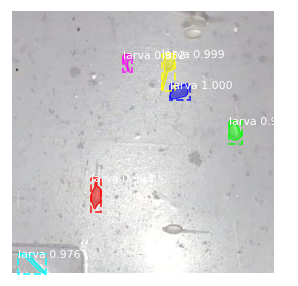

Processing 1 images
image                    shape: (500, 500, 3)         min:   73.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -32.80000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


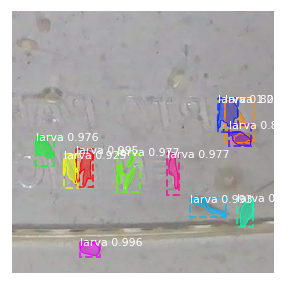

Processing 1 images
image                    shape: (500, 500, 3)         min:   71.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -40.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


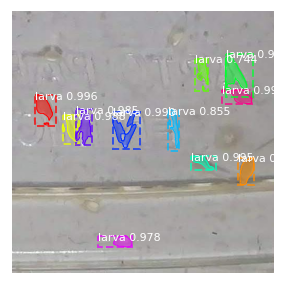

Processing 1 images
image                    shape: (500, 500, 3)         min:   91.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -20.70000  max:  130.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


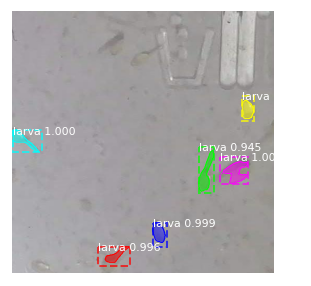

Processing 1 images
image                    shape: (500, 500, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


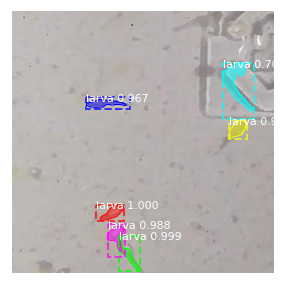

In [16]:
import skimage
#real_test_dir = '/content/MaskRCNN_Video/cascoim/val/'
real_test_dir = 'C://My Proyects//Mask_RCNN//Mask_RCNN//larvaim//val//'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
